In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sklearn as sk
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

C:\Users\liron firuz\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data=pd.read_csv('raw data after delitting empty columns & filling methoods.csv')
data.head()

ID      1#     2#     3#      4#     5#     6#      7#     8#     9#  ...  \
0   1  0.0730  0.071  0.074  0.0740  0.085  0.084  0.0840  0.083  0.805  ...   
1   2  0.0360  0.036  0.032  0.0370  0.064  0.064  0.0650  0.064  0.810  ...   
2   3  0.0660  0.069  0.066  0.0670  0.072  0.069  0.0730  0.074  0.721  ...   
3   4  0.0440  0.032  0.042  0.0520  0.067  0.086  0.0520  0.062  0.821  ...   
4   5  0.0415  0.028  0.028  0.0485  0.049  0.041  0.0415  0.053  0.796  ...   

   778#    779#   780#  781#    782#  786#    787#    788#    789#  EGT  
0   Yes  5.9918  0.005   Yes  42.014    No  2.1030  2.0960 -0.0125   71  
1   Yes  5.9919  0.005   Yes  42.014   Yes  2.1026  2.0953 -0.0110   83  
2   Yes  5.9923  0.005   Yes  42.014   Yes  2.1024  2.0945 -0.0160   77  
3   Yes  5.9921  0.005   Yes  42.010   Yes  2.1025  2.0948 -0.0090   94  
4   Yes  5.9918  0.005   Yes  42.015   Yes  2.1029  2.0947 -0.0122   77  

[5 rows x 568 columns]

In [3]:
column_counts = data.count()
filtered_columns = column_counts[column_counts == -1]
filtered_columns

Series([], dtype: int64)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Columns: 568 entries, ID to EGT
dtypes: float64(441), int64(80), object(47)
memory usage: 71.1+ KB


In [5]:
data.replace({'Plasma':1,'Yes':1 ,'New': 1, 'GE': 1,'Serviceable': 1 ,'Level 1': 1,'No': 0, 'OVH': 0,'LHT': 0,'As is': 0, 'Final machining':2, 'Level 3': 3}, inplace=True)

### Class Imbalance

In [6]:
def categorize_EGT(egt):
    if egt <= 70:
        return 0
    else:
        return 1


data['EGT_Category'] = data['EGT'].apply(categorize_EGT)

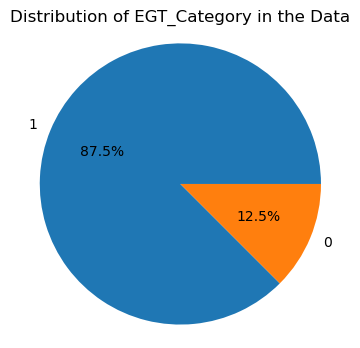

In [7]:
EGT_Category=data['EGT_Category'].value_counts()
plt.figure(figsize=(4, 4))
plt.pie(EGT_Category, labels=EGT_Category.index, autopct='%1.1f%%')
plt.title('Distribution of EGT_Category in the Data') 
plt.axis('equal')  
plt.show()

According to the information we received from the organization, the percentage of failures is 1-12, which means 8% failures

In [8]:
data_test=data.copy()

#### SMOTE

Initial class counts:
 1    10
0     2
Name: EGT_Category, dtype: int64


C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\3616505067.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled[target] = y_resampled


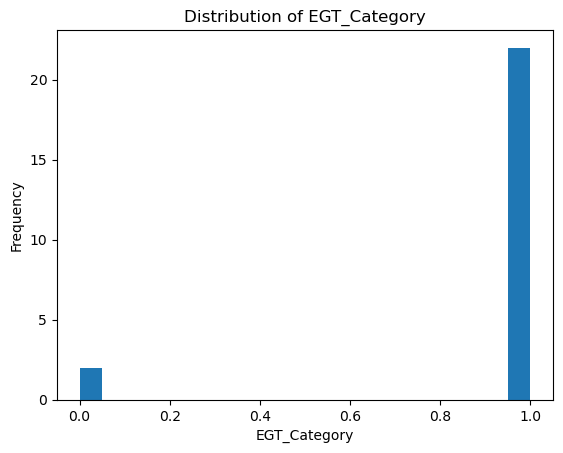

Class counts after resampling:
 1    22
0     2
Name: EGT_Category, dtype: int64


In [9]:
target = "EGT_Category"

# Create the target vector and feature matrix
y = data_test[target]
X = data_test.drop(columns=[target])

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the number of samples in each class
count_class0 = y_train.value_counts().get(0, 0)
count_class1 = y_train.value_counts().get(1, 0)

print("Initial class counts:\n", y_train.value_counts())

# Desired number of samples for class 0 and 1
desired_class0_count = 2
desired_class1_count = 22

# Define custom sampling strategy
sampling_strategy = {
    0: desired_class0_count,
    1: desired_class1_count
}

# Initialize SMOTE with the custom sampling strategy
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Fit and transform the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Convert the resampled data back to DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled[target] = y_resampled

# Plot distribution of target variable
target_variable = target

if y_resampled.dtype == 'object':
    y_resampled.value_counts().plot(kind='bar')
    plt.title('Distribution of ' + target_variable)
    plt.xlabel(target_variable)
    plt.ylabel('Count')
else:
    y_resampled.plot(kind='hist', bins=20)
    plt.title('Distribution of ' + target_variable)
    plt.xlabel(target_variable)
    plt.ylabel('Frequency')

plt.show()

# Save balanced data to CSV
df_resampled.to_csv('path_to_balanced_data_smote.csv', index=False)

print("Class counts after resampling:\n", y_resampled.value_counts())


### Scaling

In [10]:
numerical_columns = make_column_selector(dtype_include=np.number)
categorical_columns= make_column_selector(dtype_exclude=np.number)

Standardization is a safe default choice that works well with many algorithms.

Normalization can be useful for algorithms that assume or benefit from data in a bounded range.

Since there is uncertainty about the identity of the model and we want maximum flexibility, we will examine the execution of models on both approaches

In [11]:
scaler = MinMaxScaler()
numerical_columns_selected = data[numerical_columns(data)]

normalized_numerical_columns = scaler.fit_transform(numerical_columns_selected)
normalized_numerical_data = pd.DataFrame(normalized_numerical_columns, columns=numerical_columns_selected.columns)

normalized_data = pd.concat([normalized_numerical_data, data[categorical_columns(data)]], axis=1)

In [12]:
scaler = MinMaxScaler()
numerical_columns_selected = df_resampled[numerical_columns(df_resampled)]

normalized_numerical_columns = scaler.fit_transform(numerical_columns_selected)
normalized_numerical_data = pd.DataFrame(normalized_numerical_columns, columns=numerical_columns_selected.columns)

normalized_data_smote = pd.concat([normalized_numerical_data, df_resampled[categorical_columns(data)]], axis=1)

In [13]:
scaler = StandardScaler()
numerical_columns_selected = data[numerical_columns(data)]
standardized_numerical_columns = scaler.fit_transform(numerical_columns_selected)
standardized_numerical_data = pd.DataFrame(standardized_numerical_columns, columns=numerical_columns_selected.columns)

standardized_data = pd.concat([standardized_numerical_data, data[categorical_columns(data)]], axis=1)

In [14]:
scaler = StandardScaler()
numerical_columns_selected = df_resampled[numerical_columns(df_resampled)]
standardized_numerical_columns = scaler.fit_transform(numerical_columns_selected)
standardized_numerical_data = pd.DataFrame(standardized_numerical_columns, columns=numerical_columns_selected.columns)

standardized_data_smote = pd.concat([standardized_numerical_data, df_resampled[categorical_columns(data)]], axis=1)

### Feature Selection

#### Pearson correlation

In [16]:
corr_matrix = data_test.corr()
corr_matrix

ID        1#        2#        3#        4#        5#  \
ID            1.000000 -0.168097 -0.112026 -0.026470 -0.187463 -0.333672   
1#           -0.168097  1.000000  0.936499  0.865562  0.898248  0.858377   
2#           -0.112026  0.936499  1.000000  0.946081  0.932182  0.813206   
3#           -0.026470  0.865562  0.946081  1.000000  0.922382  0.794378   
4#           -0.187463  0.898248  0.932182  0.922382  1.000000  0.815880   
...                ...       ...       ...       ...       ...       ...   
787#          0.125053 -0.062860 -0.090515 -0.021918 -0.076019 -0.018927   
788#         -0.056011  0.519494  0.471574  0.551636  0.442350  0.622148   
789#          0.312103 -0.465813 -0.579761 -0.464391 -0.541728 -0.279047   
EGT          -0.388498  0.086993 -0.016423 -0.029165  0.045647  0.271655   
EGT_Category -0.532948  0.094661 -0.070921 -0.222534 -0.099236  0.199406   

                    6#        7#        8#        9#  ...      779#  780#  \
ID           -0.284694 -0.101283 -0.248067 -0.540121  ... -0.063492   NaN   
1#            0.679139  0.647327  0.816218 -0.261136  ...  0.110702   NaN   
2#            0.670644  0.720663  0.865988 -0.299313  ...  0.117752   NaN   
3#            0.735175  0.781645  0.845608 -0.434987  ...  0.200509   NaN   
4#            0.731296  0.694729  0.885542 -0.302708  ...  0.141371   NaN   
...                ...       ...       ...       ...  ...       ...   ...   
787#         -0.016536  0.030106 -0.089984  0.151623  ... -0.011211   NaN   
788#          0.677035  0.822686  0.664257 -0.354189  ... -0.210028   NaN   
789#         -0.215908 -0.486180 -0.569768  0.109095  ... -0.079094   NaN   
EGT           0.303864 -0.085340  0.061188  0.491970  ...  0.213529   NaN   
EGT_Category  0.113843 -0.084385 -0.006871  0.636238  ... -0.221249   NaN   

                  781#      782#      786#      787#      788#      789#  \
ID           -0.364073 -0.371883 -0.112022  0.125053 -0.056011  0.312103   
1#            0.150239  0.397931 -0.482807 -0.062860  0.519494 -0.465813   
2#            0.187473  0.462683 -0.377895 -0.090515  0.471574 -0.579761   
3#            0.122937  0.335228 -0.360881 -0.021918  0.551636 -0.464391   
4#            0.181915  0.426956 -0.328227 -0.076019  0.442350 -0.541728   
...                ...       ...       ...       ...       ...       ...   
787#          0.283841 -0.190584 -0.311532  1.000000  0.171815  0.302533   
788#         -0.127273  0.355281 -0.672727  0.171815  1.000000 -0.103501   
789#         -0.079111 -0.776458  0.141023  0.302533 -0.103501  1.000000   
EGT           0.249766 -0.182920  0.209264  0.245114 -0.045208  0.256916   
EGT_Category -0.097590  0.158035  0.097590  0.050671  0.026615 -0.015105   

                   EGT  EGT_Category  
ID           -0.388498     -0.532948  
1#            0.086993      0.094661  
2#           -0.016423     -0.070921  
3#           -0.029165     -0.222534  
4#            0.045647     -0.099236  
...                ...           ...  
787#          0.245114      0.050671  
788#         -0.045208      0.026615  
789#          0.256916     -0.015105  
EGT           1.000000      0.497376  
EGT_Category  0.497376      1.000000  

[569 rows x 569 columns]

In [17]:
column_name = 'EGT'

# List to store indices of rows where the value in the specified column is greater than 0.4 or less than -0.4
indices_above_0_4_or_below_neg_0_4 = []

# Iterate over the rows and check the value in the specified column
for idx, value in corr_matrix[column_name].items():
    if value > 0.4 or value < -0.4:
        indices_above_0_4_or_below_neg_0_4.append(idx)
        
print(len(indices_above_0_4_or_below_neg_0_4))


61


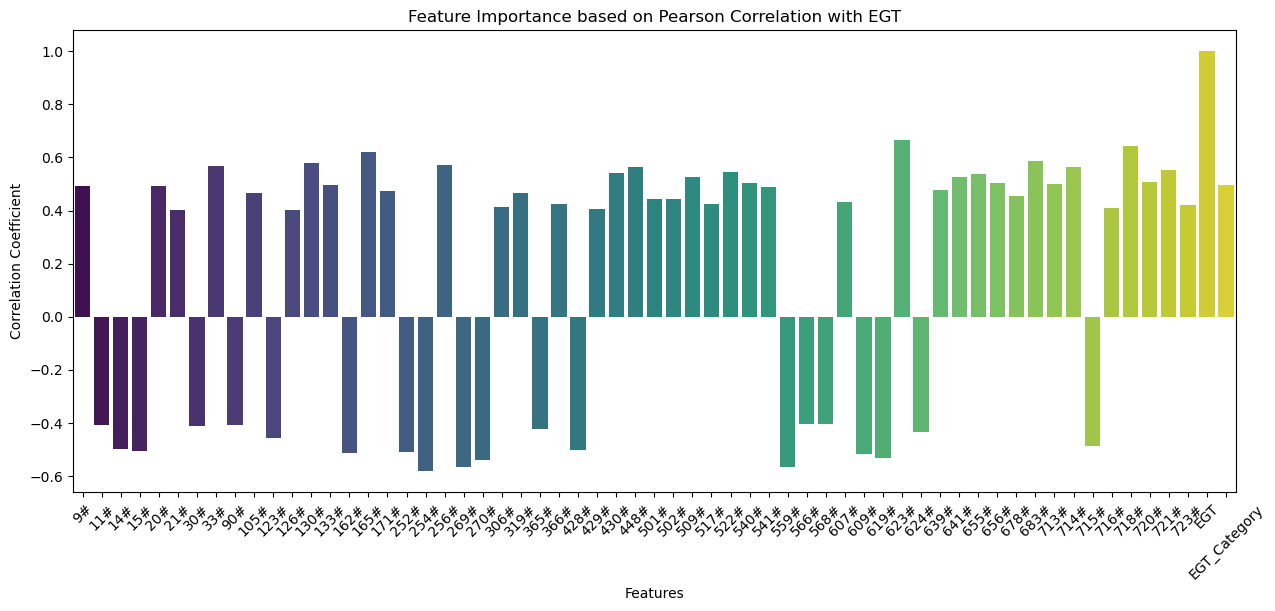

In [18]:
# Extract the correlation values for the selected features
important_features = corr_matrix.loc[indices_above_0_4_or_below_neg_0_4, column_name]

# Create a bar plot for feature importance
plt.figure(figsize=(15, 6))
sns.barplot(x=important_features.index, y=important_features.values, palette="viridis")
plt.title('Feature Importance based on Pearson Correlation with EGT')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

In [19]:
column_name = 'EGT'

# List to store indices of rows where the value in the specified column is greater than 0.5
indices_above_0_5_or_below_neg_0_5 = []

# Iterate over the rows and check the value in the specified column
for idx, value in corr_matrix[column_name].items():
    if value > 0.5 or value < -0.5:
        indices_above_0_5_or_below_neg_0_5.append(idx)
        
print(len(indices_above_0_5_or_below_neg_0_5))

30


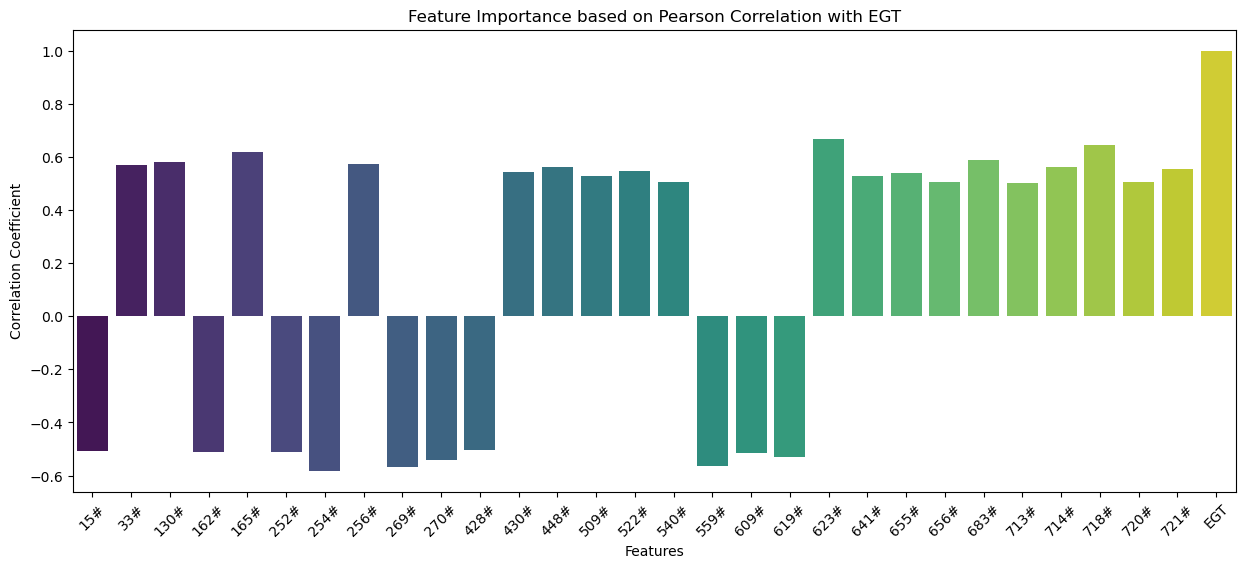

In [20]:
# Extract the correlation values for the selected features
important_features = corr_matrix.loc[indices_above_0_5_or_below_neg_0_5, column_name]

# Create a bar plot for feature importance
plt.figure(figsize=(15, 6))
sns.barplot(x=important_features.index, y=important_features.values, palette="viridis")
plt.title('Feature Importance based on Pearson Correlation with EGT')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

In [21]:
column_name = 'EGT'

# List to store indices of rows where the value in the specified column is greater than 0.6
indices_above_0_6_or_below_neg_0_6 = []

# Iterate over the rows and check the value in the specified column
for idx, value in corr_matrix[column_name].items():
    if value > 0.6 or value < -0.6:
        indices_above_0_6_or_below_neg_0_6.append(idx)
        
print(len(indices_above_0_6_or_below_neg_0_6))

4


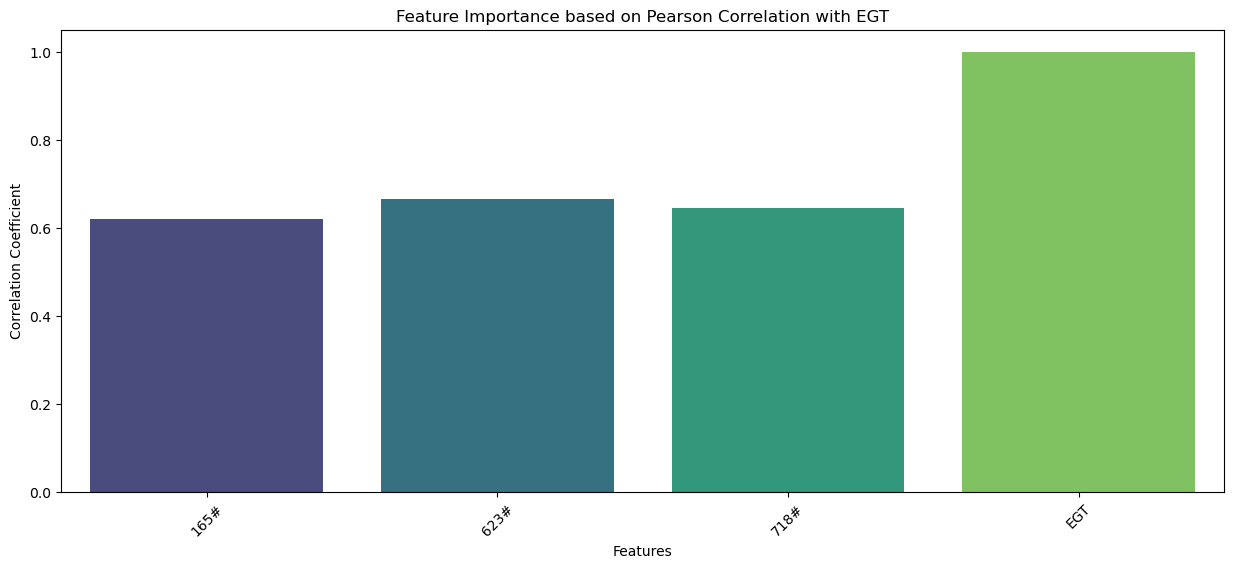

In [22]:
# Extract the correlation values for the selected features
important_features = corr_matrix.loc[indices_above_0_6_or_below_neg_0_6, column_name]

# Create a bar plot for feature importance
plt.figure(figsize=(15, 6))
sns.barplot(x=important_features.index, y=important_features.values, palette="viridis")
plt.title('Feature Importance based on Pearson Correlation with EGT')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

When requesting a correlation above 0.6, 4 features are obtained. In relation to the amount of features in the data set, this reduction is too sharp. We chose to work with correlations above 0.5 which give 30 features

In [23]:
corr_matrix_normalized_data = normalized_data.corr()
column_name = 'EGT'

# List to store indices of rows where the value in the specified column is greater than 0.5
indices_above_0_5_or_below_neg_0_5 = []

# Iterate over the rows and check the value in the specified column
for idx, value in corr_matrix_normalized_data[column_name].iteritems():
    if value > 0.5 or value < -0.5:
        indices_above_0_5_or_below_neg_0_5.append(idx)
        
print(len(indices_above_0_5_or_below_neg_0_5))
Pearson_correlation_normalized_data = normalized_data[indices_above_0_5_or_below_neg_0_5]

30


In [24]:
corr_matrix_normalized_data_somte = normalized_data_smote.corr()
column_name = 'EGT'

# List to store indices of rows where the value in the specified column is greater than 0.5
indices_above_0_5_or_below_neg_0_5 = []

# Iterate over the rows and check the value in the specified column
for idx, value in corr_matrix_normalized_data_somte[column_name].iteritems():
    if value > 0.5 or value < -0.5:
        indices_above_0_5_or_below_neg_0_5.append(idx)
        
print(len(indices_above_0_5_or_below_neg_0_5))
Pearson_correlation_normalized_data_somte = normalized_data_smote[indices_above_0_5_or_below_neg_0_5]

43


In [25]:
corr_matrix_standardized_data = standardized_data.corr()
column_name = 'EGT'

# List to store indices of rows where the value in the specified column is greater than 0.5
indices_above_0_5_or_below_neg_0_5 = []

# Iterate over the rows and check the value in the specified column
for idx, value in corr_matrix_standardized_data[column_name].iteritems():
    if value > 0.5 or value < -0.5:
        indices_above_0_5_or_below_neg_0_5.append(idx)
        
print(len(indices_above_0_5_or_below_neg_0_5))
Pearson_correlation_standardized_data = standardized_data[indices_above_0_5_or_below_neg_0_5]

30


In [26]:
corr_matrix_standardized_data_smote = standardized_data_smote.corr()
column_name = 'EGT'

# List to store indices of rows where the value in the specified column is greater than 0.5
indices_above_0_5_or_below_neg_0_5 = []

# Iterate over the rows and check the value in the specified column
for idx, value in corr_matrix_standardized_data_smote[column_name].iteritems():
    if value > 0.5 or value < -0.5:
        indices_above_0_5_or_below_neg_0_5.append(idx)
        
print(len(indices_above_0_5_or_below_neg_0_5))
Pearson_correlation_standardized_data_somte = standardized_data_smote[indices_above_0_5_or_below_neg_0_5]

43


Normalized data and standardized data give the same number of features. When using the SMOTE model you get a higher number of features

#### feature importance - Random Forest

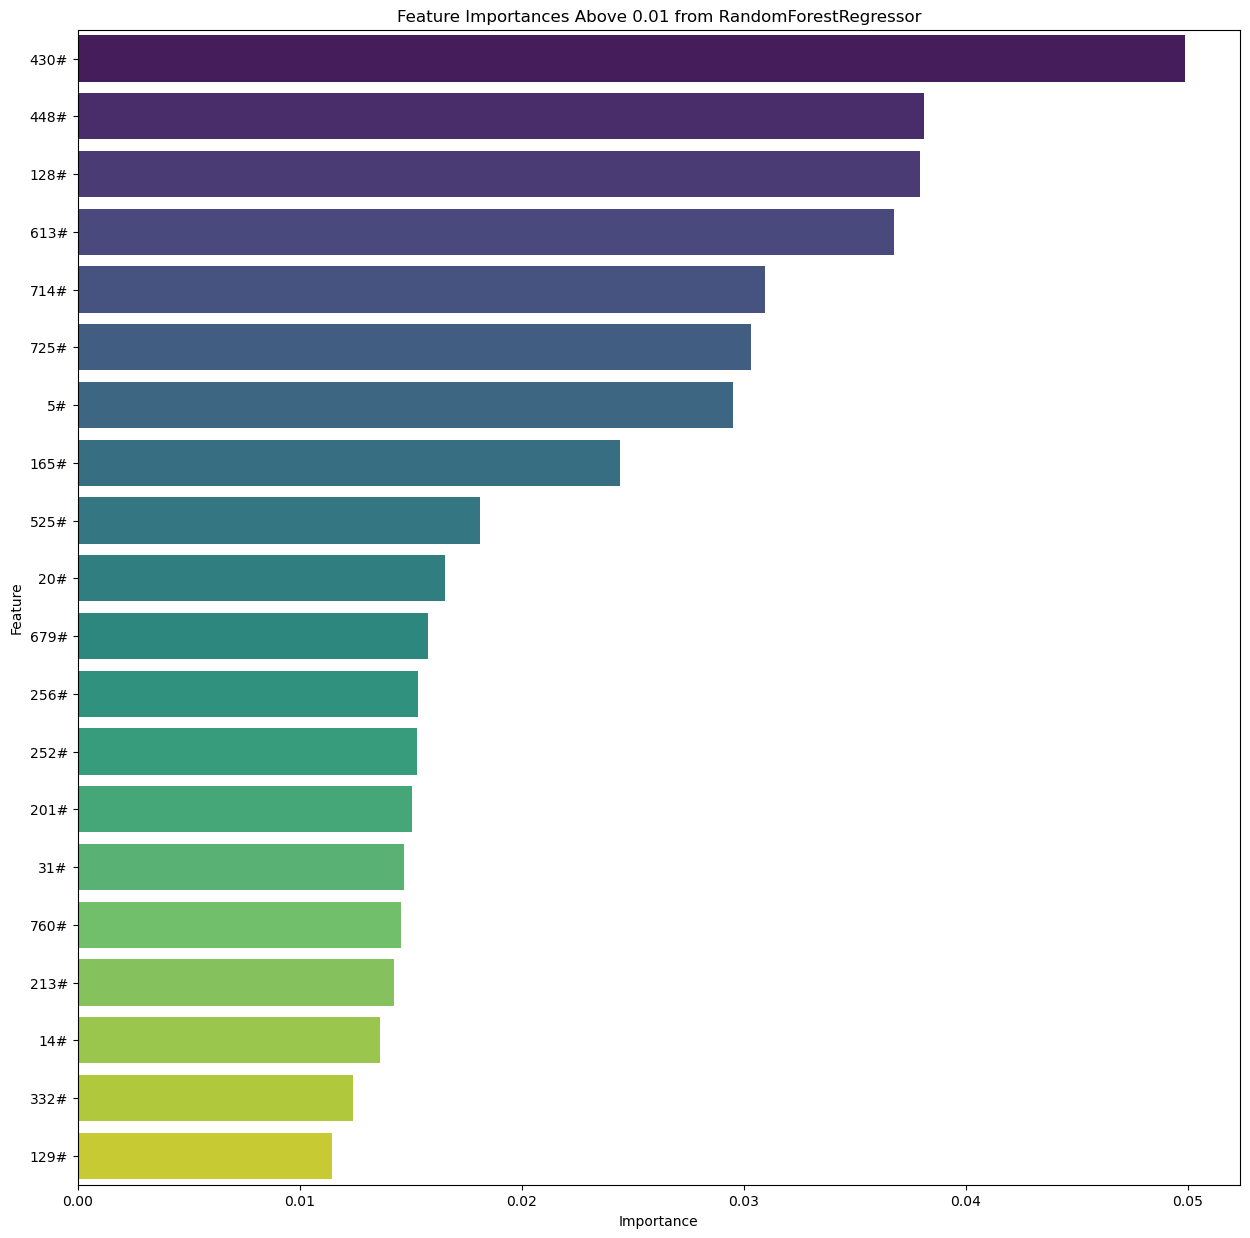

In [27]:
target = "EGT"

# Create the target vector and feature matrix
y = normalized_data[target]
X = normalized_data.drop(columns=[target])

# Initialize and train the RandomForestRegressor with a random seed
random_seed = 42 
model = RandomForestRegressor(random_state=random_seed)
model.fit(X, y)

# Get feature importances
importance = model.feature_importances_

# Create a DataFrame to hold feature names and their importances
features_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Filter features with importance above the threshold
threshold = 0.01
Random_Forest_feature_importance_normalized_data = features_importance_df[features_importance_df['Importance'] > threshold]

# Sort the DataFrame by importance
Random_Forest_feature_importance_normalized_data = Random_Forest_feature_importance_normalized_data.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='Importance', y='Feature', data=Random_Forest_feature_importance_normalized_data, palette='viridis')
plt.title(f'Feature Importances Above {threshold} from RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



In [28]:
len(Random_Forest_feature_importance_normalized_data)

20

In [29]:
# אם מחליטים לשנות את משתנה המטרה לטווחים צריכים להפוך למסווג במקום הרגרסור

#Classifier vs. Regressor: Use RandomForestClassifier for classification problems (discrete labels) and RandomForestRegressor for regression problems (continuous target values).

In [30]:
#Random_Forest_feature_importance_normalized_data
#משאירה בשביל תמר כדי לבדוק שאין שינוי בפיצרים בין הרצות למרות שאני מבטיחה שבדקתי ואין

In [31]:
Random_Forest_feature_importance_normalized_data.set_index('Feature', inplace=True)
important_features = Random_Forest_feature_importance_normalized_data.index

Random_Forest_feature_importance_normalized_data_filtered = normalized_data[important_features]
Random_Forest_feature_importance_normalized_data_filtered["EGT"]=normalized_data["EGT"]
Random_Forest_feature_importance_normalized_data_filtered

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\1497098565.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Random_Forest_feature_importance_normalized_data_filtered["EGT"]=normalized_data["EGT"]


430#      448#      128#  613#      714#      725#        5#  \
0   0.166667  0.205882  0.000000  0.64  0.933333  0.847222  0.493151   
1   0.166667  0.852941  0.285714  0.40  1.000000  0.902778  0.205479   
2   0.166667  0.294118  1.000000  0.80  0.666667  0.208333  0.315068   
3   0.500000  0.647059  0.857143  0.76  1.000000  0.930556  0.246575   
4   0.500000  0.411765  1.000000  0.00  1.000000  0.000000  0.000000   
5   0.833333  0.676471  1.000000  0.00  1.000000  0.888889  0.178082   
6   0.333333  1.000000  0.000000  0.40  1.000000  0.986111  1.000000   
7   1.000000  0.058824  0.285714  0.40  1.000000  1.000000  0.328767   
8   0.500000  0.764706  0.000000  0.52  1.000000  0.902778  0.205479   
9   0.500000  0.294118  0.714286  0.20  1.000000  0.069444  0.287671   
10  0.166667  0.000000  0.000000  0.52  0.600000  0.861111  0.068493   
11  0.500000  0.823529  0.142857  0.40  1.000000  0.069444  0.315068   
12  0.000000  0.500000  1.000000  0.48  1.000000  0.888889  0.054795   
13  0.000000  0.000000  1.000000  1.00  0.333333  0.625000  0.068493   
14  0.166667  0.176471  1.000000  0.80  1.000000  0.625000  0.068493   
15  0.333333  0.647059  1.000000  0.80  0.000000  0.625000  0.191781   

        165#      525#       20#  ...      256#  252#      201#       31#  \
0   0.184211  0.800000  0.471698  ...  0.285714   0.4  0.833333  0.338028   
1   0.105263  0.000000  0.735849  ...  0.571429   0.2  0.388889  0.366197   
2   0.578947  0.900000  0.566038  ...  0.000000   1.0  0.166667  0.000000   
3   0.421053  1.000000  0.622642  ...  0.428571   0.6  0.555556  0.281690   
4   0.434211  0.400000  0.679245  ...  0.285714   0.6  0.222222  0.323944   
5   0.578947  0.500000  0.679245  ...  0.285714   0.7  0.555556  0.577465   
6   0.592105  0.500000  0.226415  ...  0.142857   0.8  0.111111  0.126761   
7   0.368421  1.000000  1.000000  ...  0.571429   0.4  0.722222  0.042254   
8   1.000000  0.300000  0.679245  ...  0.714286   0.2  0.222222  0.295775   
9   0.815789  0.500000  0.000000  ...  0.571429   0.4  0.722222  0.154930   
10  0.513158  0.666667  0.113208  ...  0.142857   0.9  0.833333  0.577465   
11  0.381579  0.900000  0.981132  ...  1.000000   0.0  0.555556  0.042254   
12  0.078947  0.800000  0.245283  ...  0.285714   0.8  0.333333  0.000000   
13  0.197368  0.800000  0.188679  ...  0.142857   0.8  0.000000  0.366197   
14  0.000000  0.800000  0.169811  ...  0.000000   1.0  0.944444  1.000000   
15  0.092105  0.800000  0.150943  ...  0.428571   0.6  1.000000  0.492958   

        760#      213#       14#   332#  129#   EGT  
0   0.999572  0.923077  0.000000  0.000   0.0  0.08  
1   0.999714  0.692308  0.142857  1.000   0.2  0.56  
2   0.999714  0.615385  0.428571  1.000   0.8  0.32  
3   0.999714  1.000000  0.142857  0.000   0.6  1.00  
4   0.000000  1.000000  0.285714  0.600   0.8  0.32  
5   0.999857  0.846154  0.428571  0.425   0.4  0.48  
6   0.999857  0.846154  0.285714  0.250   0.0  0.56  
7   1.000000  0.000000  0.285714  0.675   1.0  0.48  
8   0.999643  0.692308  0.142857  0.350   0.8  0.84  
9   1.000000  0.307692  0.285714  0.550   0.8  0.60  
10  0.999572  0.307692  0.714286  0.050   0.8  0.20  
11  0.999714  0.538462  0.000000  0.150   0.0  0.64  
12  0.999514  1.000000  0.285714  0.175   0.8  0.12  
13  0.999757  0.923077  1.000000  0.950   0.8  0.00  
14  0.999714  0.923077  0.142857  0.225   0.8  0.12  
15  0.999572  0.307692  0.571429  0.900   0.8  0.04  

[16 rows x 21 columns]

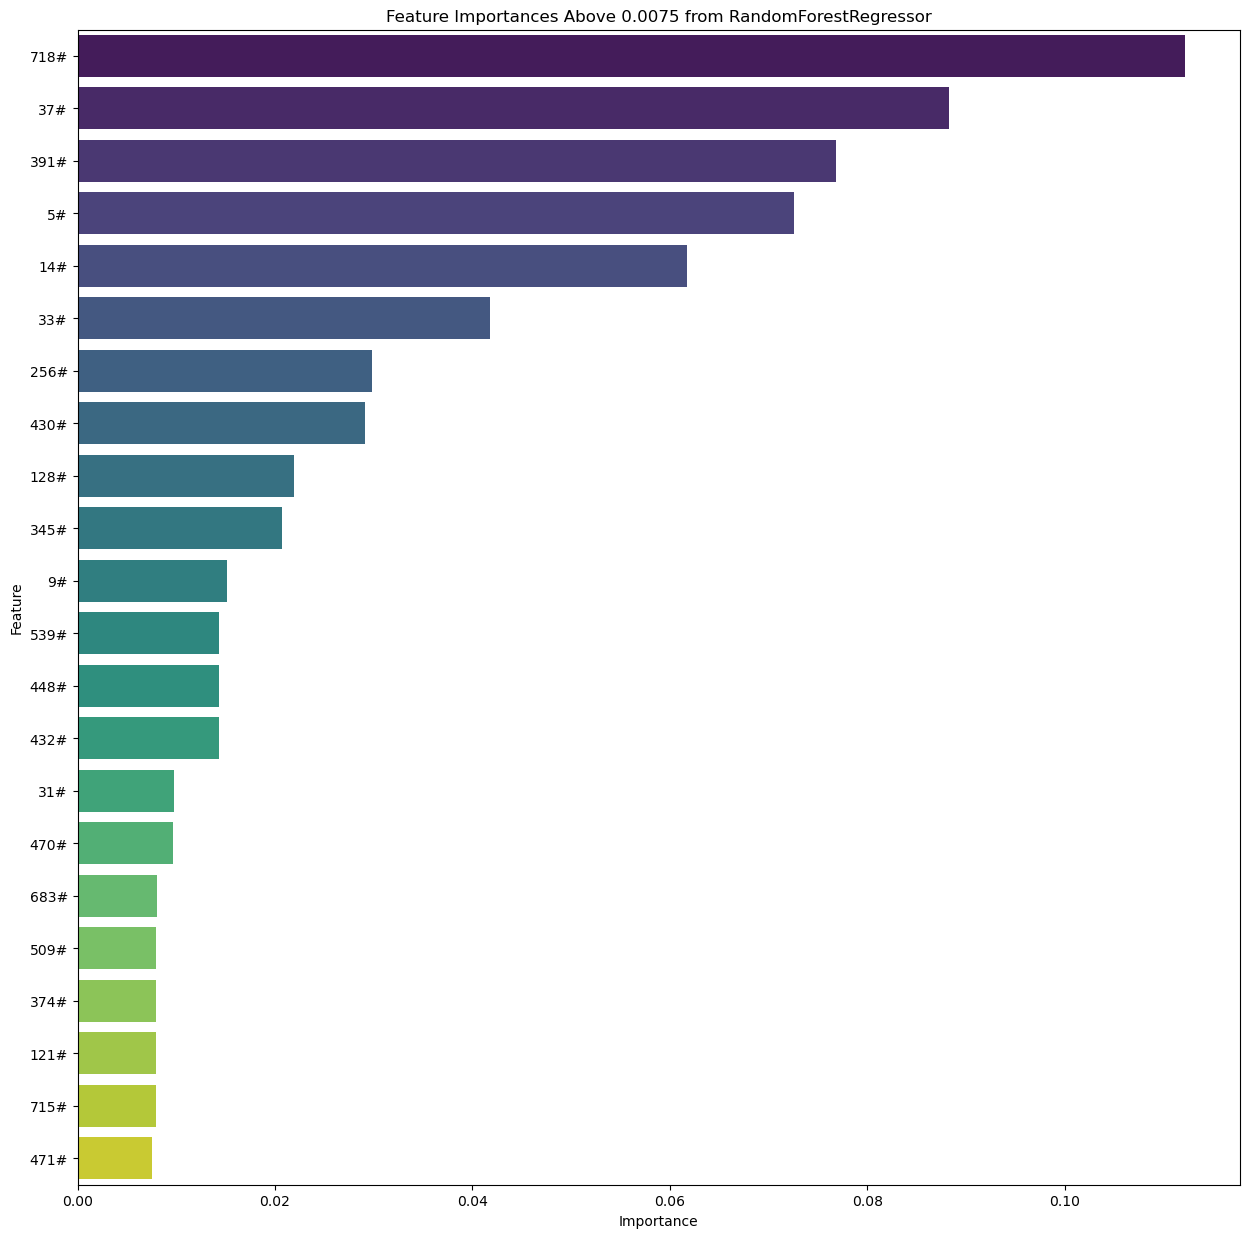

In [32]:
target = "EGT"

# Create the target vector and feature matrix
y = normalized_data_smote[target]
X = normalized_data_smote.drop(columns=[target])

# Initialize and train the RandomForestRegressor with a random seed
random_seed = 42 
model = RandomForestRegressor(random_state=random_seed)
model.fit(X, y)

# Get feature importances
importance = model.feature_importances_

# Create a DataFrame to hold feature names and their importances
features_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Filter features with importance above the threshold
threshold = 0.0075
Random_Forest_feature_importance_normalized_data_smote = features_importance_df[features_importance_df['Importance'] > threshold]

# Sort the DataFrame by importance
Random_Forest_feature_importance_normalized_data_smote = Random_Forest_feature_importance_normalized_data_smote.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='Importance', y='Feature', data=Random_Forest_feature_importance_normalized_data_smote, palette='viridis')
plt.title(f'Feature Importances Above {threshold} from RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



In [33]:
len(Random_Forest_feature_importance_normalized_data_smote)

22

In [34]:
Random_Forest_feature_importance_normalized_data_smote.set_index('Feature', inplace=True)
important_features = Random_Forest_feature_importance_normalized_data_smote.index

Random_Forest_feature_importance_normalized_data_smote_filtered =normalized_data_smote[important_features]
Random_Forest_feature_importance_normalized_data_smote_filtered["EGT"]=normalized_data_smote["EGT"]
Random_Forest_feature_importance_normalized_data_smote_filtered

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\3746840157.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Random_Forest_feature_importance_normalized_data_smote_filtered["EGT"]=normalized_data_smote["EGT"]


718#       37#      391#        5#       14#       33#      256#  \
0   0.000000  0.530612  0.000000  0.068493  1.000000  0.373796  0.142857   
1   1.000000  0.265306  0.000210  0.315068  0.000000  0.658960  1.000000   
2   1.000000  0.040816  0.000180  0.205479  0.142857  0.396917  0.714286   
3   1.000000  0.510204  0.000280  0.287671  0.285714  0.741811  0.571429   
4   0.500000  0.877551  0.000270  0.315068  0.428571  0.123314  0.000000   
5   0.000000  0.448980  1.000000  0.191781  0.571429  0.104046  0.428571   
6   1.000000  0.591837  0.000320  0.000000  0.285714  0.312139  0.285714   
7   1.000000  0.367347  0.000280  0.328767  0.285714  0.000000  0.571429   
8   0.500000  1.000000  0.000260  0.068493  0.714286  0.678227  0.142857   
9   0.000000  0.714286  0.000270  0.054795  0.285714  0.048170  0.285714   
10  1.000000  0.530612  0.000220  0.246575  0.142857  1.000000  0.428571   
11  1.000000  0.000000  0.000240  1.000000  0.285714  0.610790  0.142857   
12  0.166854  0.809631  0.000267  0.059366  0.428732  0.258425  0.238042   
13  1.000000  0.399419  0.000286  0.281797  0.285714  0.044594  0.530609   
14  0.349112  0.643038  0.000273  0.136094  0.285714  0.290328  0.385460   
15  1.000000  0.502982  0.000218  0.244257  0.142857  0.965979  0.444689   
16  1.000000  0.011347  0.000223  0.779122  0.246000  0.551333  0.301715   
17  1.000000  0.285371  0.000217  0.295708  0.017556  0.637648  0.956109   
18  0.000389  0.714508  0.000270  0.054805  0.286048  0.048660  0.285603   
19  0.996106  0.047333  0.000181  0.206333  0.145082  0.394786  0.708723   
20  1.000000  0.251592  0.000233  0.126880  0.197503  0.364488  0.550349   
21  0.694173  0.809789  0.000268  0.153610  0.547851  0.702920  0.309292   
22  0.996467  0.513665  0.000280  0.286122  0.288743  0.741362  0.568400   
23  1.000000  0.586659  0.000319  0.007582  0.285714  0.304940  0.292304   

        430#      128#      345#  ...      432#       31#      470#      683#  \
0   0.000000  1.000000  0.010309  ...  1.000000  0.634146  0.000000  0.310345   
1   0.500000  0.142857  0.007981  ...  0.500000  0.073171  0.364486  0.000000   
2   0.500000  0.000000  0.000998  ...  0.666667  0.512195  0.439252  0.758621   
3   0.500000  0.714286  0.001663  ...  0.666667  0.268293  0.448598  0.655172   
4   0.166667  1.000000  0.006984  ...  0.333333  0.000000  0.869159  0.482759   
5   0.333333  1.000000  1.000000  ...  0.333333  0.853659  0.495327  0.172414   
6   0.500000  1.000000  0.003658  ...  0.333333  0.560976  0.738318  0.275862   
7   1.000000  0.285714  0.000333  ...  0.500000  0.073171  0.644860  0.310345   
8   0.166667  0.000000  0.003991  ...  0.666667  1.000000  0.317757  0.551724   
9   0.000000  1.000000  0.002328  ...  0.000000  0.000000  1.000000  0.482759   
10  0.500000  0.857143  0.000000  ...  1.000000  0.487805  0.299065  1.000000   
11  0.333333  0.000000  0.009312  ...  0.633333  0.219512  0.345794  0.517241   
12  0.055618  0.666291  0.002883  ...  0.222472  0.333709  0.772330  0.482759   
13  0.928567  0.387762  0.000808  ...  0.476189  0.142862  0.658212  0.275862   
14  0.174556  0.900254  0.002096  ...  0.232741  0.093664  0.807499  0.517241   
15  0.500000  0.808790  0.000056  ...  0.981196  0.489181  0.306974  0.965517   
16  0.379667  0.000000  0.007000  ...  0.642600  0.300878  0.371776  0.551724   
17  0.500000  0.195526  0.007716  ...  0.489759  0.103145  0.387457  0.000000   
18  0.000130  0.999221  0.002329  ...  0.000519  0.000779  0.999469  0.482759   
19  0.497404  0.007788  0.001044  ...  0.664071  0.508206  0.442601  0.724138   
20  0.500000  0.382518  0.002015  ...  0.539161  0.530855  0.553650  0.551724   
21  0.296116  0.277391  0.003087  ...  0.666667  0.715844  0.368569  0.586207   
22  0.497645  0.709238  0.001679  ...  0.666667  0.273463  0.447674  0.620690   
23  0.511531  0.983527  0.003581  ...  0.337177  0.549726  0.736162  0.275862   

        509#      374#      121#      715#      471#   EGT  
0   0.500000  1.0000

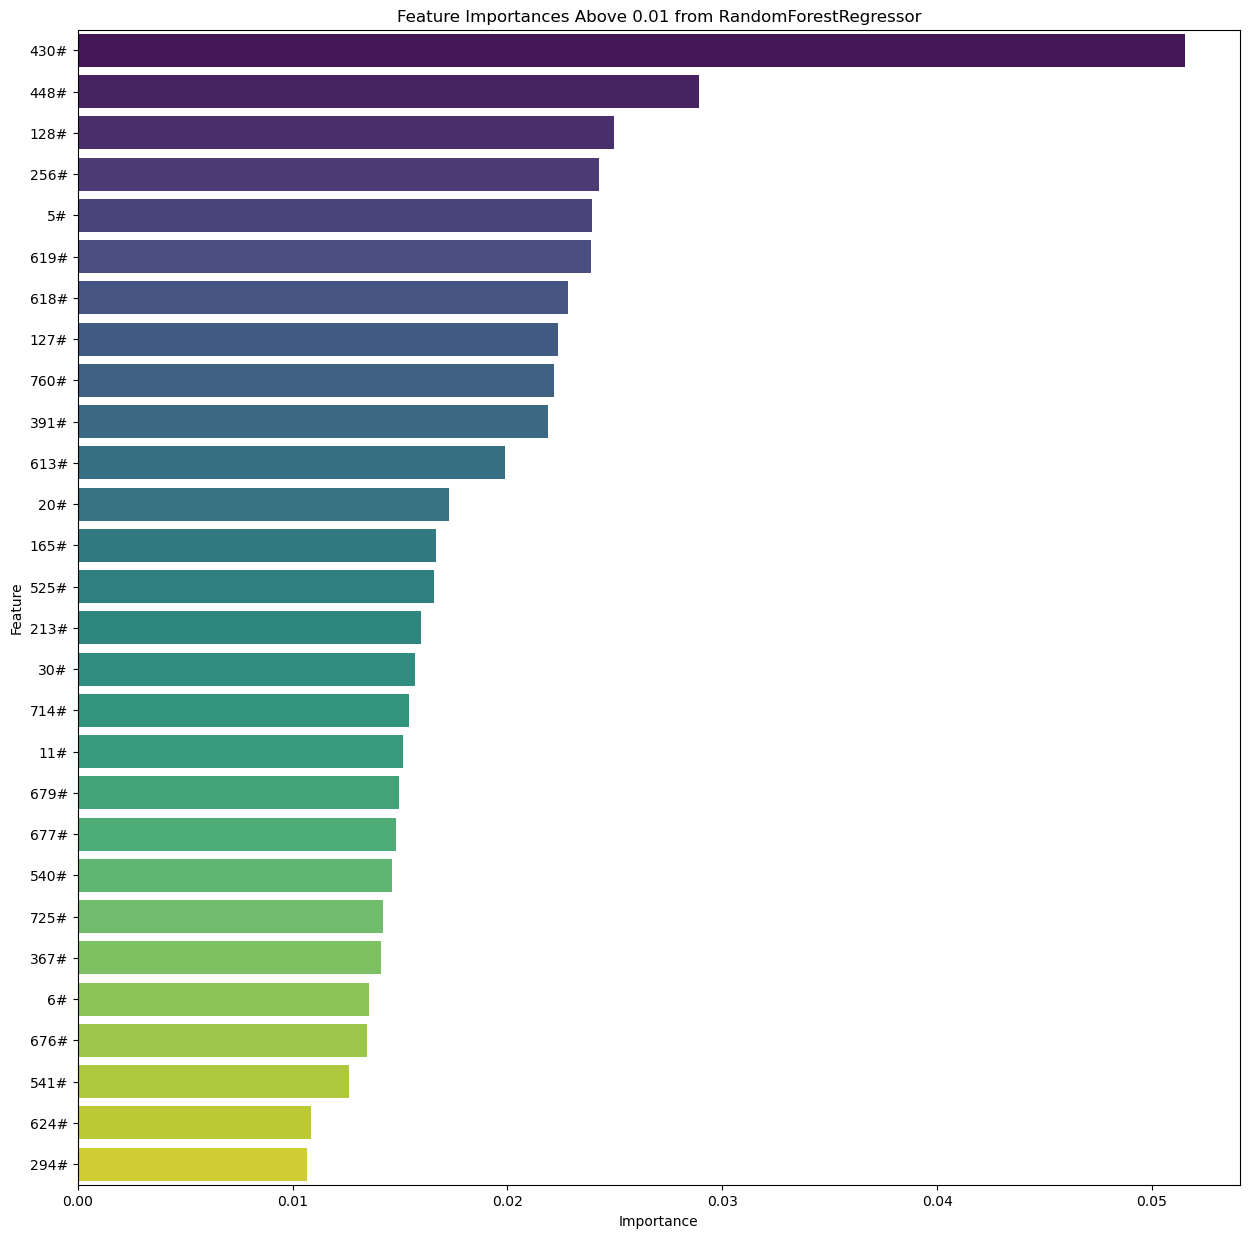

In [35]:
target = "EGT"

# Create the target vector and feature matrix
y = standardized_data[target]
X = standardized_data.drop(columns=[target])

# Initialize and train the RandomForestRegressor with a random seed
random_seed = 43 
model = RandomForestRegressor(random_state=random_seed)
model.fit(X, y)

# Get feature importances
importance = model.feature_importances_

# Create a DataFrame to hold feature names and their importances
features_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Filter features with importance above the threshold
threshold = 0.01
Random_Forest_feature_importance_standardized_data = features_importance_df[features_importance_df['Importance'] > threshold]

# Sort the DataFrame by importance
Random_Forest_feature_importance_standardized_data = Random_Forest_feature_importance_standardized_data.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='Importance', y='Feature', data=Random_Forest_feature_importance_standardized_data, palette='viridis')
plt.title(f'Feature Importances Above {threshold} from RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



In [36]:
len(Random_Forest_feature_importance_standardized_data)

28

In [37]:
# אם מחליטים לשנות את משתנה המטרה לטווחים צריכים להפוך למסווג במקום הרגרסור

#Classifier vs. Regressor: Use RandomForestClassifier for classification problems (discrete labels) and RandomForestRegressor for regression problems (continuous target values).

In [38]:
Random_Forest_feature_importance_standardized_data.set_index('Feature', inplace=True)
important_features = Random_Forest_feature_importance_standardized_data.index

Random_Forest_feature_importance_standardized_data_filtered = standardized_data[important_features]
Random_Forest_feature_importance_standardized_data_filtered["EGT"]=standardized_data["EGT"]
Random_Forest_feature_importance_standardized_data_filtered

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\2791950861.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Random_Forest_feature_importance_standardized_data_filtered["EGT"]=standardized_data["EGT"]


430#      448#      128#      256#        5#      619#      618#  \
0  -0.729153 -0.808304 -1.331531 -0.306364  1.047726  0.651217  0.932577   
1  -0.729153  1.253457 -0.676008  0.782929 -0.200628 -0.506502 -0.096473   
2  -0.729153 -0.527155  0.962799 -1.395656  0.274935  0.651217 -0.096473   
3   0.498894  0.597442  0.635038  0.238283 -0.022292 -1.664222 -0.096473   
4   0.498894 -0.152289  0.962799 -0.306364 -1.092311  0.651217 -0.096473   
5   1.726942  0.691158  0.962799 -0.306364 -0.319519 -1.664222 -1.125524   
6  -0.115129  1.722039 -1.331531 -0.851010  3.247209  0.651217 -0.096473   
7   2.340965 -1.276886 -0.676008  0.782929  0.334381 -1.664222 -2.154575   
8   0.498894  0.972308 -1.331531  1.327575 -0.200628  0.651217  0.418052   
9   0.498894 -0.527155  0.307276  0.782929  0.156044 -1.664222 -2.154575   
10 -0.729153 -1.464319 -1.331531 -0.851010 -0.795083  0.651217  0.932577   
11  0.498894  1.159740 -1.003770  2.416868  0.274935  0.651217  0.932577   
12 -1.343177  0.128860  0.962799 -0.306364 -0.854529  0.651217  0.932577   
13 -1.343177 -1.464319  0.962799 -0.851010 -0.795083  0.651217  0.932577   
14 -0.729153 -0.902020  0.962799 -1.395656 -0.795083  0.651217 -0.096473   
15 -0.115129  0.597442  0.962799  0.238283 -0.260074  0.651217  0.932577   

        127#      760#      391#  ...      677#      540#      725#      367#  \
0   3.853092  0.257554 -0.258136  ...  0.377964 -0.816497  0.561912  0.577350   
1  -0.138600  0.258144 -0.258383  ... -1.133893  0.000000  0.721745 -0.577350   
2  -0.316009  0.258144 -0.258053  ... -1.133893 -0.816497 -1.276165  2.886751   
3  -0.360361  0.258144 -0.258259  ...  1.889822  0.816497  0.801661 -0.577350   
4  -0.138600 -3.872983 -0.257846  ...  0.377964 -0.816497 -1.875538  0.577350   
5  -0.360361  0.258734 -0.258012  ...  0.377964  1.632993  0.681787 -0.577350   
6  -0.138600  0.258734 -0.258177  ... -1.133893  0.816497  0.961494 -0.577350   
7  -0.404713  0.259324 -0.258012  ... -1.133893  0.000000  1.001452 -0.577350   
8  -0.138600  0.257849 -0.258425  ... -1.133893  0.816497  0.721745 -0.577350   
9  -0.360361  0.259324 -0.258012  ...  1.889822 -1.632993 -1.675747 -0.577350   
10 -0.138600  0.257554 -0.258094  ...  0.377964  0.816497  0.601870 -0.577350   
11 -0.404713  0.258144 -0.258301  ... -1.133893  1.632993 -1.675747 -0.577350   
12 -0.138600  0.257318 -0.258053  ...  0.377964  0.000000  0.681787  1.732051   
13 -0.271657  0.258321 -0.259168  ...  0.377964 -0.816497 -0.077419 -0.577350   
14 -0.271657  0.258144 -0.258053  ...  0.377964  0.000000 -0.077419 -0.577350   
15 -0.271657  0.257554  3.872983  ...  0.377964 -1.632993 -0.077419  0.577350   

          6#      676#      541#      624#      294#       EGT  
0   0.817546 -1.096250 -1.290994  0.503903  1.065036 -1.106777  
1  -0.329887 -1.572556 -1.290994 -0.391925 -0.979833  0.566461  
2  -0.043029  0.570824  0.774597  1.399731 -0.639021 -0.270158  
3   0.932289 -0.977173  0.774597  0.503903  0.383413  2.100263  
4  -1.649434  1.404360  0.774597 -1.287753  0.042601 -0.270158  
5   0.415944 -1.096250  0.774597 -1.287753  0.383413  0.287588  
6   2.997668 -0.500866 -0.258199 -0.391925 -1.320644  0.566461  
7   0.301201 -0.977173  0.774597 -0.391925 -0.639021  0.287588  
8  -0.329887  1.285284 -0.258199 -0.391925  0.042601  1.542517  
9  -0.674117 -0.619943  0.774597  0.503903 -0.639021  0.705897  
10 -0.903603  0.451747  0.774597 -0.391925 -0.298210 -0.688468  
11  0.186458  1.285284  1.807392 -2.183581 -0.639021  0.845334  
12 -0.674117  0.808977 -1.290994  0.503903  2.428282 -0.967341  
13 -0.043029 -0.381790 -0.258199  1.399731 -1.320644 -1.385651  
14 -0.444630  0.011163 -1.290994  0.503903  1.405847 -0.967341  
15 -0.559373  1.404360 -1.290994  1.399731  0.724224 -1.246214  

[16 rows x 29 columns]

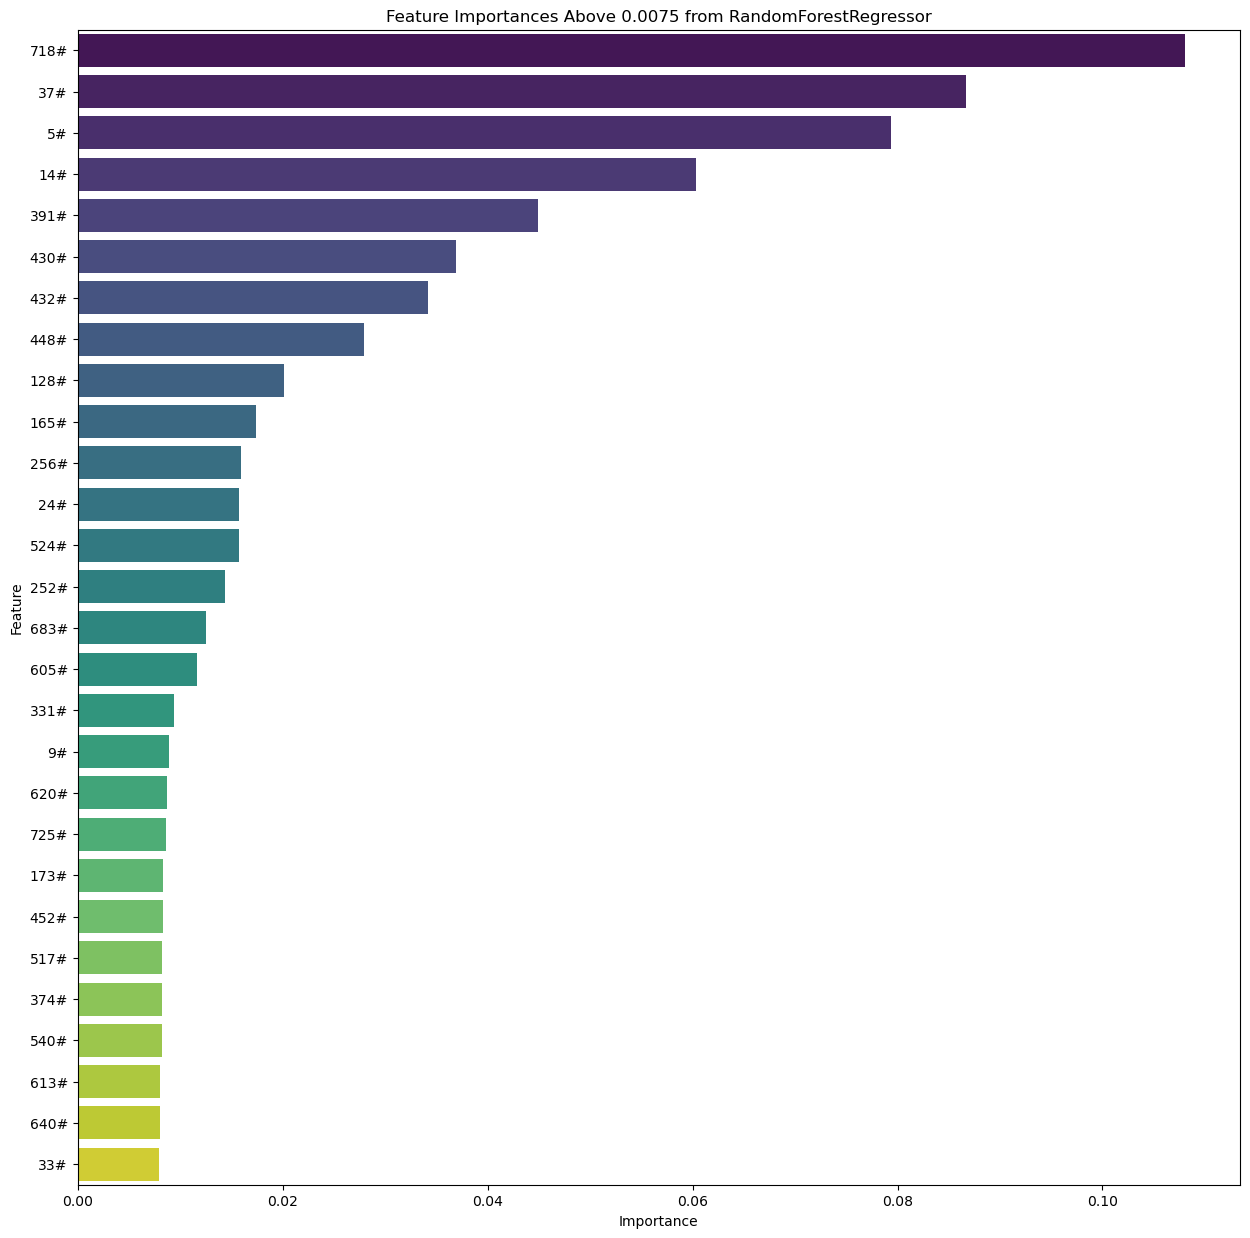

In [39]:
target = "EGT"

# Create the target vector and feature matrix
y = standardized_data_smote[target]
X = standardized_data_smote.drop(columns=[target])

# Initialize and train the RandomForestRegressor with a random seed
random_seed = 43 
model = RandomForestRegressor(random_state=random_seed)
model.fit(X, y)

# Get feature importances
importance = model.feature_importances_

# Create a DataFrame to hold feature names and their importances
features_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Filter features with importance above the threshold
threshold = 0.0075
Random_Forest_feature_importance_standardized_data_smote = features_importance_df[features_importance_df['Importance'] > threshold]

# Sort the DataFrame by importance
Random_Forest_feature_importance_standardized_data_smote = Random_Forest_feature_importance_standardized_data_smote.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='Importance', y='Feature', data=Random_Forest_feature_importance_standardized_data_smote, palette='viridis')
plt.title(f'Feature Importances Above {threshold} from RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



In [40]:
len(Random_Forest_feature_importance_standardized_data_smote)

28

In [41]:
Random_Forest_feature_importance_standardized_data_smote.set_index('Feature', inplace=True)
important_features = Random_Forest_feature_importance_standardized_data_smote.index

Random_Forest_feature_importance_standardized_data_smote_filtered = standardized_data_smote[important_features]
Random_Forest_feature_importance_standardized_data_smote_filtered["EGT"]=standardized_data_smote["EGT"]
Random_Forest_feature_importance_standardized_data_smote_filtered

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\156296665.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Random_Forest_feature_importance_standardized_data_smote_filtered["EGT"]=standardized_data_smote["EGT"]


718#       37#        5#       14#      391#      430#      432#  \
0  -1.804806  0.195014 -0.757143  3.184640 -0.209725 -1.543371  1.801341   
1   0.713074 -0.773712  0.343739 -1.471858 -0.208674  0.439285 -0.086948   
2   0.713074 -1.593403 -0.145542 -0.806644 -0.208824  0.439285  0.542482   
3   0.713074  0.120496  0.221419 -0.141430 -0.208324  0.439285  0.542482   
4  -0.545866  1.461808  0.343739  0.523784 -0.208374 -0.882486 -0.716378   
5  -1.804806 -0.103056 -0.206702  1.188998  4.795831 -0.221600 -0.716378   
6   0.713074  0.418566 -1.062944 -0.141430 -0.208124  0.439285 -0.716378   
7   0.713074 -0.401125  0.404899 -0.141430 -0.208324  2.421942 -0.086948   
8  -0.545866  1.908913 -0.757143  1.854212 -0.208424 -0.882486  0.542482   
9  -1.804806  0.865670 -0.818303 -0.141430 -0.208374 -1.543371 -1.975237   
10  0.713074  0.195014  0.037938 -0.806644 -0.208624  0.439285  1.801341   
11  0.713074 -1.742437  3.401746 -0.141430 -0.208524 -0.221600  0.416596   
12 -1.384687  1.213809 -0.797894  0.524533 -0.208391 -1.322828 -1.135053   
13  0.713074 -0.284018  0.195193 -0.141430 -0.208295  2.138686 -0.176873   
14 -0.925785  0.605521 -0.455324 -0.141430 -0.208357 -0.851203 -1.096273   
15  0.713074  0.094126  0.027588 -0.806644 -0.208635  0.439285  1.730327   
16  0.713074 -1.701005  2.415595 -0.326361 -0.208608 -0.037873  0.451592   
17  0.713074 -0.700450  0.257302 -1.390107 -0.208640  0.439285 -0.125625   
18 -1.803825  0.866482 -0.818256 -0.139876 -0.208374 -1.542857 -1.973277   
19  0.703269 -1.569607 -0.141731 -0.796282 -0.208821  0.428991  0.532677   
20  0.713074 -0.823788 -0.496465 -0.552188 -0.208556  0.439285  0.060945   
21 -0.056961  1.214387 -0.377122  1.079210 -0.208385 -0.369180  0.542482   
22  0.704178  0.133134  0.214504 -0.127328 -0.208325  0.429945  0.542482   
23  0.713074  0.399662 -1.029092 -0.141430 -0.208128  0.485010 -0.701862   

        448#      128#      165#  ...      725#      173#      452#      517#  \
0  -1.639673  1.126631 -1.109449  ...  0.061817  0.934255 -0.576439  0.253990   
1   1.203493 -1.043101 -0.404244  ... -1.461128  1.362361 -0.210385  0.253990   
2   1.000410 -1.404723  1.963229  ...  0.823289  0.078044  0.277687  0.344294   
3  -0.624257  0.403387  1.258024  ... -1.461128 -0.778167  1.619885  0.344294   
4  -0.624257  1.126631  0.351332  ... -1.080392 -0.207360 -1.674602  0.344294   
5   0.594243  1.126631 -1.512423  ...  0.061817 -0.350062  0.277687 -4.170944   
6  -0.218090  1.126631 -0.202757  ... -1.651496 -0.064658 -1.552584  0.795818   
7  -1.436590 -0.681479 -0.454616  ...  1.089805  2.361274  1.497867 -0.107230   
8  -1.639673 -1.404723  0.099473  ...  0.709068 -1.063571 -2.162674  0.253990   
9   0.086535  1.126631 -1.562795  ...  0.785216 -1.206273  0.277687 -1.010277   
10  0.594243  0.765009 -0.253129  ...  0.899436 -0.350062  0.155669  0.795818   
11  1.812743 -1.404723  0.401704  ...  1.051731  0.791553  0.765759  0.344294   
12 -0.489516  0.281896 -1.008082  ...  0.759805 -1.158652 -0.536683 -0.588381   
13 -1.262507 -0.423160 -0.418634  ...  0.698164  2.014688  1.062059  0.021786   
14 -0.161611  0.874138 -0.578015  ...  0.000991 -1.056816  0.746264 -0.537381   
15  0.617156  0.642611 -0.128101  ...  0.895141 -0.325912  0.162552  0.770347   
16  1.586913 -1.404723  0.835810  ...  0.988224  0.593197  0.630074  0.344294   
17  1.116141 -0.909777 -0.391864  ... -1.472826  1.274674 -0.292860  0.287283   
18  0.085191  1.124660 -1.561500  ...  0.785156 -1.206162  0.275786 -1.009293   
19  0.987756 -1.385008  1.950674  ...  0.808463  0.075821  0.262482  0.344294   
20  0.534311 -0.436433  1.134699  ... -0.123362  0.023458 -0.422425  0.517011   
21 -1.245339 -0.702549  0.549393  ... -0.133721 -0.952735 -0.693729  0.289059   
22 -0.631432  0.390610  1.249837  ... -1.445793 -0.780184  1.593156  0.343656   
23 -0.246192  1.084932 -0.208566  ... -1.588275 -0.008710 -1.482233  0.774992   

        374#      540#      613#      640#       33#       EGT  
0   2.153650 -0.

#### Select K Best

##### Mutual Information

In [42]:
target = "EGT"

y = normalized_data[target]
X = normalized_data.drop(columns=[target])

random_seed = 44
k_best = SelectKBest(score_func=mutual_info_regression, k='all')
model = k_best  # Use the instance of SelectKBest directly
model.fit(X, y)

# Get mutual information scores
mi_scores = k_best.scores_

# Create a DataFrame to display mutual information scores
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information Score': mi_scores})

# Filter features with mutual information score above the threshold
threshold = 0.2
filtered_mi_df = mi_df[mi_df['Mutual Information Score'] > threshold]

# Sort the DataFrame by mutual information score
filtered_mi_df = filtered_mi_df.sort_values(by='Mutual Information Score', ascending=False)

print(len(filtered_mi_df))


31


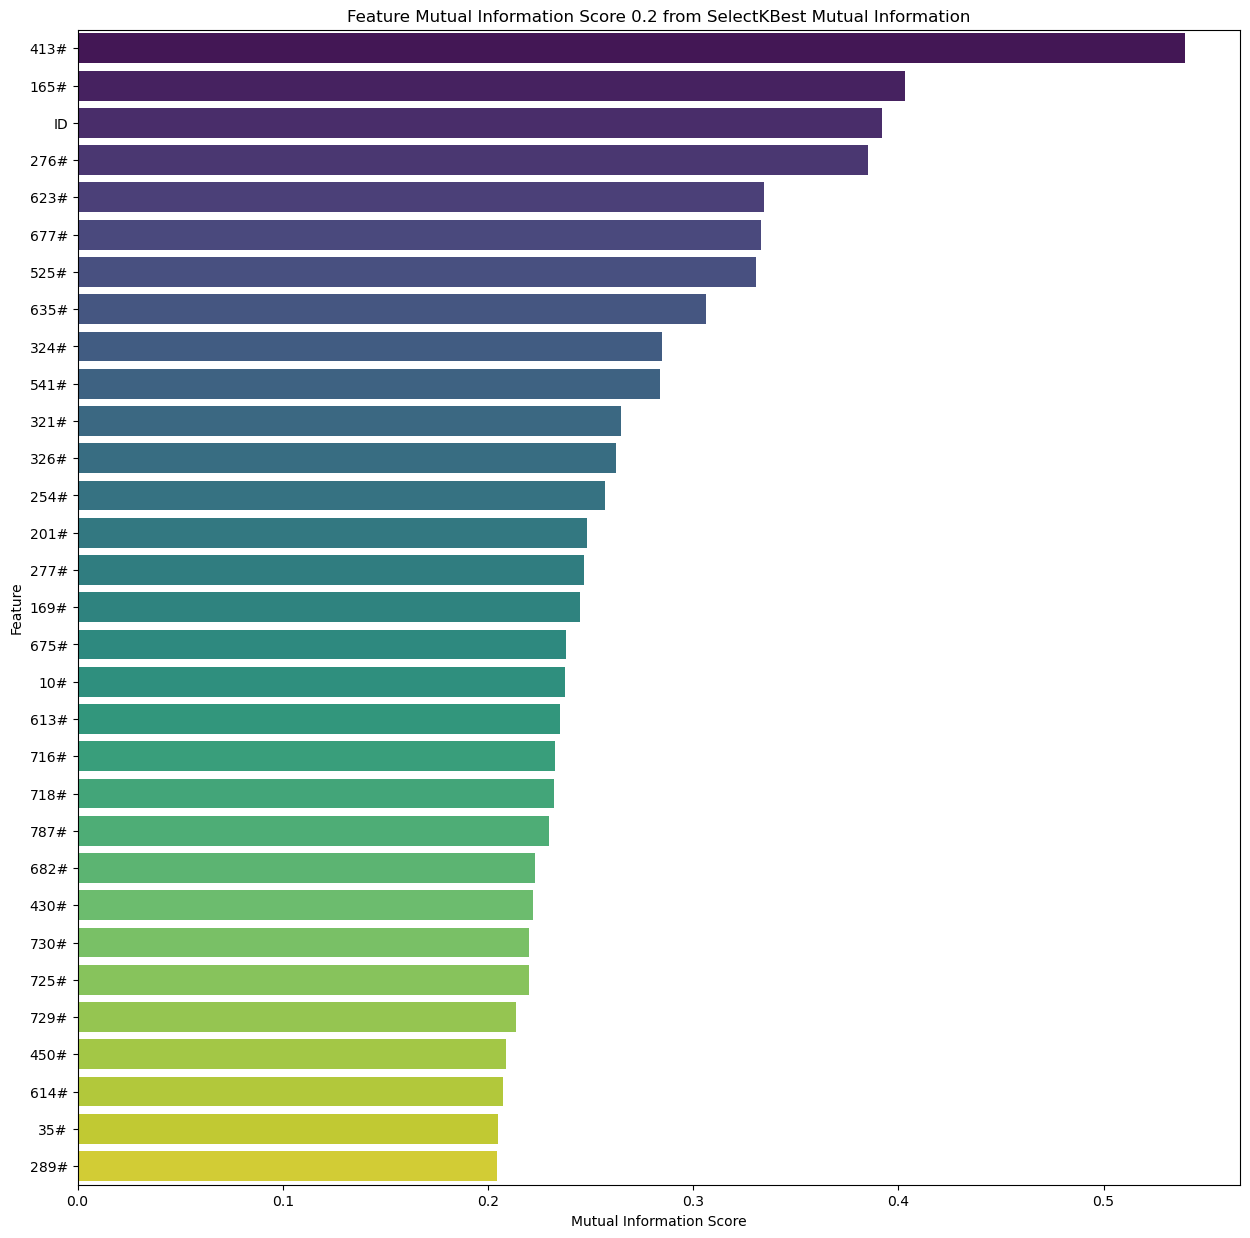

In [43]:
# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='Mutual Information Score', y='Feature', data=filtered_mi_df, palette='viridis')
plt.title(f'Feature Mutual Information Score {threshold} from SelectKBest Mutual Information')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.show()


In [44]:
filtered_mi_df.set_index('Feature', inplace=True)
important_features = filtered_mi_df.index

SelectKBest_Mutual_Information_normalized_data_filtered = normalized_data[important_features]
SelectKBest_Mutual_Information_normalized_data_filtered["EGT"]=normalized_data["EGT"]
SelectKBest_Mutual_Information_normalized_data_filtered

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\94451195.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SelectKBest_Mutual_Information_normalized_data_filtered["EGT"]=normalized_data["EGT"]


413#      165#        ID  276#      623#  677#      525#      635#  \
0   0.354839  0.184211  0.000000  0.25  0.375000   0.5  0.800000  0.285714   
1   0.516129  0.105263  0.066667  0.50  1.000000   0.0  0.000000  0.904762   
2   0.193548  0.578947  0.133333  0.00  0.392857   0.0  0.900000  0.809524   
3   0.516129  0.421053  0.200000  0.50  0.392863   1.0  1.000000  0.428571   
4   1.000000  0.434211  0.266667  0.00  0.392863   0.5  0.400000  0.190476   
5   0.677419  0.578947  0.333333  0.50  0.375000   0.5  0.500000  0.666667   
6   0.516129  0.592105  0.400000  0.50  0.392863   0.0  0.500000  0.761905   
7   0.838710  0.368421  0.466667  0.50  0.392863   0.0  1.000000  0.523810   
8   0.193548  1.000000  0.533333  1.00  1.000000   0.0  0.300000  0.000000   
9   0.516129  0.815789  0.600000  0.25  0.392863   1.0  0.500000  0.190476   
10  1.000000  0.513158  0.666667  0.25  0.392863   0.5  0.666667  0.333333   
11  0.516129  0.381579  0.733333  0.75  0.392863   0.0  0.900000  0.523810   
12  0.000000  0.078947  0.800000  1.00  0.000000   0.5  0.800000  0.238095   
13  0.193548  0.197368  0.866667  0.25  0.000000   0.5  0.800000  1.000000   
14  0.032258  0.000000  0.933333  0.25  0.000000   0.5  0.800000  0.285714   
15  0.032258  0.092105  1.000000  0.75  0.000000   0.5  0.800000  0.238095   

    324#      541#  ...      682#      430#      730#      725#      729#  \
0   0.00  0.000000  ...  0.459459  0.166667  0.083333  0.847222  0.636364   
1   0.50  0.000000  ...  1.000000  0.166667  0.250000  0.902778  0.909091   
2   0.75  0.666667  ...  0.810811  0.166667  0.083333  0.208333  0.000000   
3   0.25  0.666667  ...  0.135135  0.500000  0.333333  0.930556  0.545455   
4   0.25  0.666667  ...  0.702703  0.500000  0.000000  0.000000  0.872727   
5   0.25  0.666667  ...  0.540541  0.833333  0.083333  0.888889  0.727273   
6   1.00  0.333333  ...  0.675676  0.333333  0.166667  0.986111  0.727273   
7   0.25  0.666667  ...  0.675676  1.000000  0.083333  1.000000  0.636364   
8   0.00  0.333333  ...  0.594595  0.500000  0.166667  0.902778  0.545455   
9   0.00  0.666667  ...  0.513514  0.500000  0.250000  0.069444  1.000000   
10  0.00  0.666667  ...  0.621622  0.166667  0.083333  0.861111  0.727273   
11  0.25  1.000000  ...  0.000000  0.500000  0.250000  0.069444  0.727273   
12  0.00  0.000000  ...  0.324324  0.000000  1.000000  0.888889  0.545455   
13  0.75  0.333333  ...  0.216216  0.000000  0.000000  0.625000  0.545455   
14  0.00  0.000000  ...  0.513514  0.166667  0.166667  0.625000  0.636364   
15  0.00  0.000000  ...  0.486486  0.333333  0.166667  0.625000  0.545455   

        450#   614#       35#      289#   EGT  
0   0.000000  1.000  0.000000  0.307692  0.08  
1   0.575758  0.500  0.080717  0.692308  0.56  
2   0.696970  0.375  0.450673  0.846154  0.32  
3   1.000000  0.250  0.822870  1.000000  1.00  
4   0.212121  0.250  0.190583  0.461538  0.32  
5   0.515152  0.500  0.208520  0.461538  0.48  
6   0.636364  0.500  1.000000  0.000000  0.56  
7   0.454545  0.000  0.228700  0.038462  0.48  
8   0.212121  1.000  0.778027  0.538462  0.84  
9   0.515152  0.500  0.948430  0.730769  0.60  
10  0.727273  0.375  0.937220  0.461538  0.20  
11  0.515152  0.750  0.215247  0.615385  0.64  
12  0.303030  0.500  0.372197  0.346154  0.12  
13  0.969697  0.750  0.239910  0.884615  0.00  
14  0.424242  0.500  0.463528  0.115385  0.12  
15  0.151515  0.750  0.479821  0.230769  0.04  

[16 rows x 32 columns]

In [45]:
target = "EGT"

y = normalized_data_smote[target]
X = normalized_data_smote.drop(columns=[target])

random_seed = 44
k_best = SelectKBest(score_func=mutual_info_regression, k='all')
model = k_best  # Use the instance of SelectKBest directly
model.fit(X, y)

# Get mutual information scores
mi_scores = k_best.scores_

# Create a DataFrame to display mutual information scores
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information Score': mi_scores})

# Filter features with mutual information score above the threshold
threshold = 0.35
filtered_mi_df = mi_df[mi_df['Mutual Information Score'] > threshold]

# Sort the DataFrame by mutual information score
filtered_mi_df = filtered_mi_df.sort_values(by='Mutual Information Score', ascending=False)

print(len(filtered_mi_df))

62


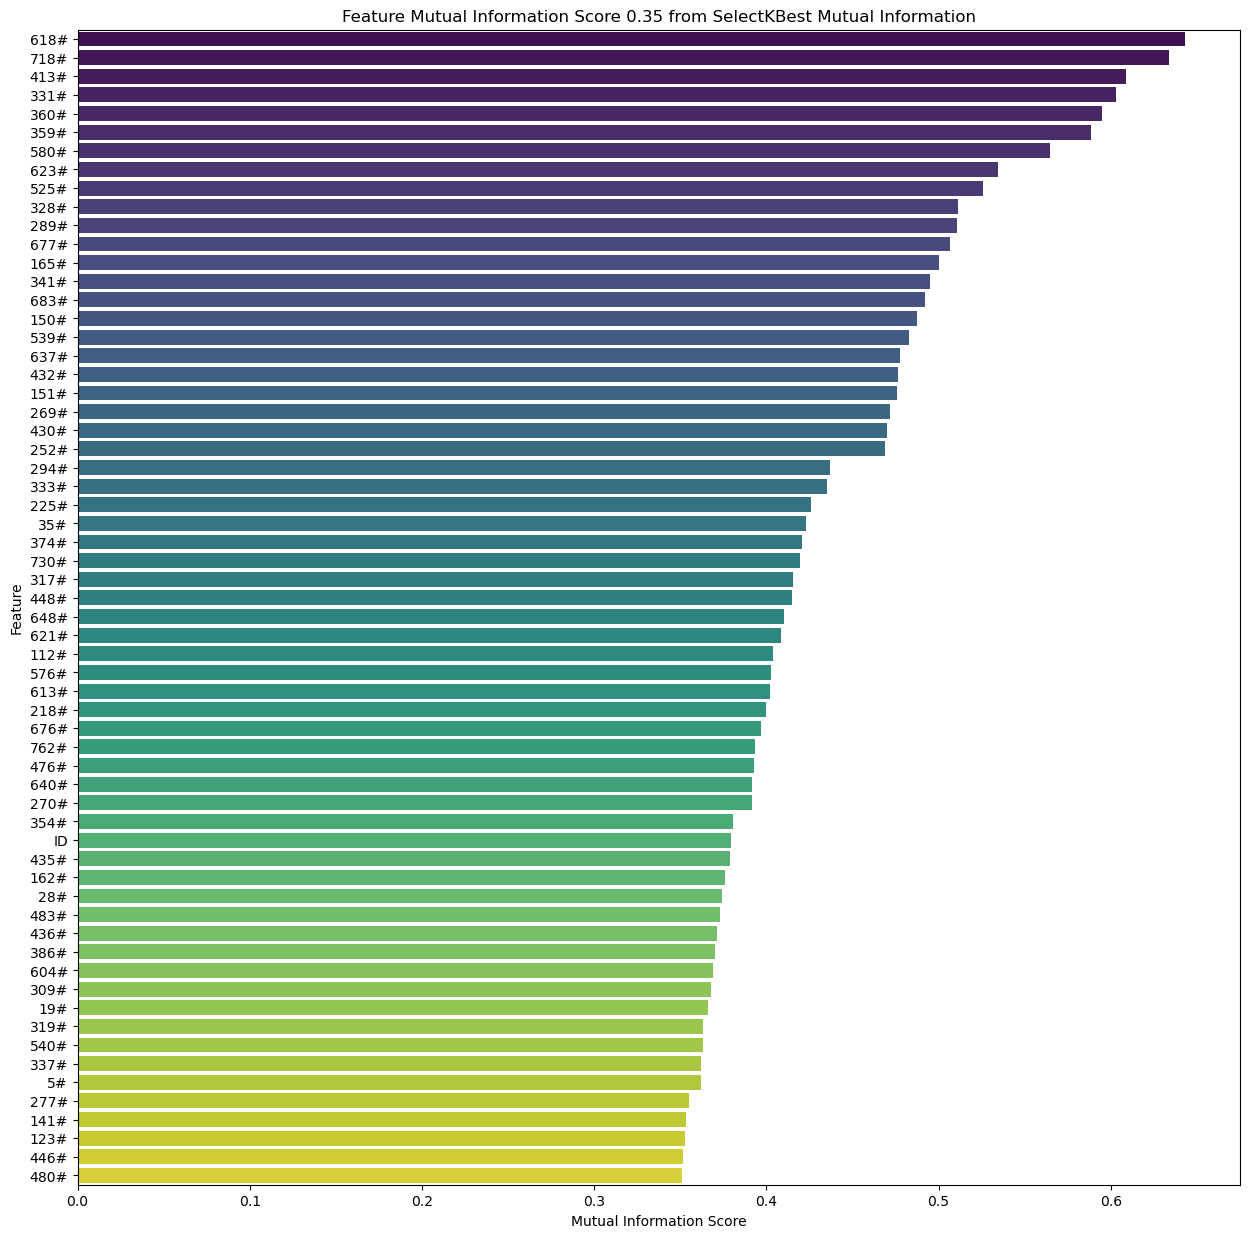

In [46]:
# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='Mutual Information Score', y='Feature', data=filtered_mi_df, palette='viridis')
plt.title(f'Feature Mutual Information Score {threshold} from SelectKBest Mutual Information')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.show()


In [47]:
filtered_mi_df.set_index('Feature', inplace=True)
important_features = filtered_mi_df.index

SelectKBest_Mutual_Information_normalized_data_smote_filtered = normalized_data_smote[important_features]
SelectKBest_Mutual_Information_normalized_data_smote_filtered["EGT"]=normalized_data_smote["EGT"]
SelectKBest_Mutual_Information_normalized_data_smote_filtered

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\2451697095.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SelectKBest_Mutual_Information_normalized_data_smote_filtered["EGT"]=normalized_data_smote["EGT"]


618#      718#      413#      331#      360#      359#      580#  \
0   1.000000  0.000000  0.193548  0.833333  0.619048  0.380952  1.000000   
1   1.000000  1.000000  0.516129  0.361111  0.571429  0.428571  0.750000   
2   0.833333  1.000000  0.193548  0.250000  0.714286  0.285714  0.125000   
3   0.000000  1.000000  0.516129  0.500000  0.619048  0.380952  0.875000   
4   0.666667  0.500000  0.193548  1.000000  1.000000  0.000000  0.125000   
5   1.000000  0.000000  0.032258  0.944444  1.000000  0.000000  0.125000   
6   0.666667  1.000000  1.000000  0.583333  0.428571  0.571429  0.500000   
7   0.000000  1.000000  0.838710  0.722222  0.333333  0.666667  0.125000   
8   1.000000  0.500000  1.000000  0.000000  0.000000  1.000000  0.000000   
9   1.000000  0.000000  0.000000  0.138889  1.000000  0.000000  0.125000   
10  0.666667  1.000000  0.516129  0.222222  0.666667  0.333333  0.125000   
11  0.666667  1.000000  0.516129  0.388889  0.619048  0.380952  0.750000   
12  1.000000  0.166854  0.333709  0.092540  0.619048  0.333333  0.083286   
13  0.095245  1.000000  0.861753  0.702380  0.333333  0.619048  0.178575   
14  0.650888  0.349112  0.180187  0.264957  0.857143  0.095238  0.386834   
15  0.676069  1.000000  0.497932  0.223789  0.666667  0.285714  0.125000   
16  0.713000  1.000000  0.426451  0.350278  0.619048  0.333333  0.576249   
17  0.979518  1.000000  0.545862  0.374766  0.523810  0.428571  0.734638   
18  1.000000  0.000389  0.000779  0.138781  0.952381  0.000000  0.124903   
19  0.832035  0.996106  0.193548  0.255841  0.714286  0.238095  0.125000   
20  0.769580  1.000000  0.502031  0.377506  0.571429  0.380952  0.268444   
21  0.611653  0.694173  0.812090  0.194173  0.238095  0.714286  0.339803   
22  0.007066  0.996467  0.519548  0.496467  0.571429  0.380952  0.868817   
23  0.651292  1.000000  0.996280  0.586536  0.380952  0.571429  0.491352   

        623#      525#      328#  ...      319#      540#      337#        5#  \
0   0.000000  0.714286  1.000000  ...  0.666667  0.250000  0.192982  0.068493   
1   0.392863  0.857143  0.757576  ...  0.333333  1.000000  0.368421  0.315068   
2   1.000000  0.000000  0.333333  ...  1.000000  0.750000  0.087719  0.205479   
3   0.392863  0.285714  0.000000  ...  0.333333  0.000000  0.368421  0.287671   
4   0.392857  0.857143  0.878788  ...  0.000000  0.250000  1.000000  0.315068   
5   0.000000  0.714286  0.363636  ...  0.000000  0.000000  0.368421  0.191781   
6   0.392863  0.142857  0.272727  ...  0.333333  0.250000  0.175439  0.000000   
7   0.392863  1.000000  0.030303  ...  0.333333  0.500000  0.052632  0.328767   
8   0.392863  0.523810  0.515152  ...  0.333333  0.750000  0.000000  0.068493   
9   0.000000  0.714286  0.303030  ...  0.666667  0.500000  0.122807  0.054795   
10  0.392863  1.000000  0.151515  ...  0.666667  0.750000  0.017544  0.246575   
11  0.392863  0.285714  0.818182  ...  0.333333  0.750000  0.000000  1.000000   
12  0.131102  0.650722  0.373817  ...  0.555430  0.583427  0.081825  0.059366   
13  0.392863  0.877543  0.064937  ...  0.333333  0.464283  0.070177  0.281797   
14  0.137153  0.564666  0.197239  ...  0.550296  0.325444  0.208554  0.136094   
15  0.427112  0.943588  0.161772  ...  0.685471  0.750000  0.021503  0.244257   
16  0.561647  0.206285  0.683393  ...  0.518667  0.750000  0.024386  0.779122   
17  0.392863  0.813252  0.727783  ...  0.333333  0.953915  0.356563  0.295708   
18  0.000306  0.714137  0.303195  ...  0.666407  0.500195  0.122711  0.054805   
19  0.995271  0.006676  0.337582  ...  0.992212  0.746106  0.094825  0.206333   
20  0.767759  0.054645  0.310150  ...  0.744988  0.558741  0.121274  0.126880   
21  0.392863  0.431346  0.315094  ...  0.333333  0.458740  0.143075  0.153610   
22  0.392863  0.287397  0.003640  ...  0.333333  0.005300  0.365818  0.286122   
23  0.392863  0.162625  0.267136  ...  0.333333  0.255766  0.172606  0.007582   

        277#      141#      123#  446#      480#   EGT  
0   1.000000  0.600000  

In [48]:
target = "EGT"

y = standardized_data[target]
X = standardized_data.drop(columns=[target])

random_seed = 45
k_best = SelectKBest(score_func=mutual_info_regression, k='all')
model = k_best  # Use the instance of SelectKBest directly
model.fit(X, y)

# Get mutual information scores
mi_scores = k_best.scores_

# Create a DataFrame to display mutual information scores
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information Score': mi_scores})

# Filter features with mutual information score above the threshold
threshold = 0.2
filtered_mi_df = mi_df[mi_df['Mutual Information Score'] > threshold]

# Sort the DataFrame by mutual information score
filtered_mi_df = filtered_mi_df.sort_values(by='Mutual Information Score', ascending=False)

print(len(filtered_mi_df))


29


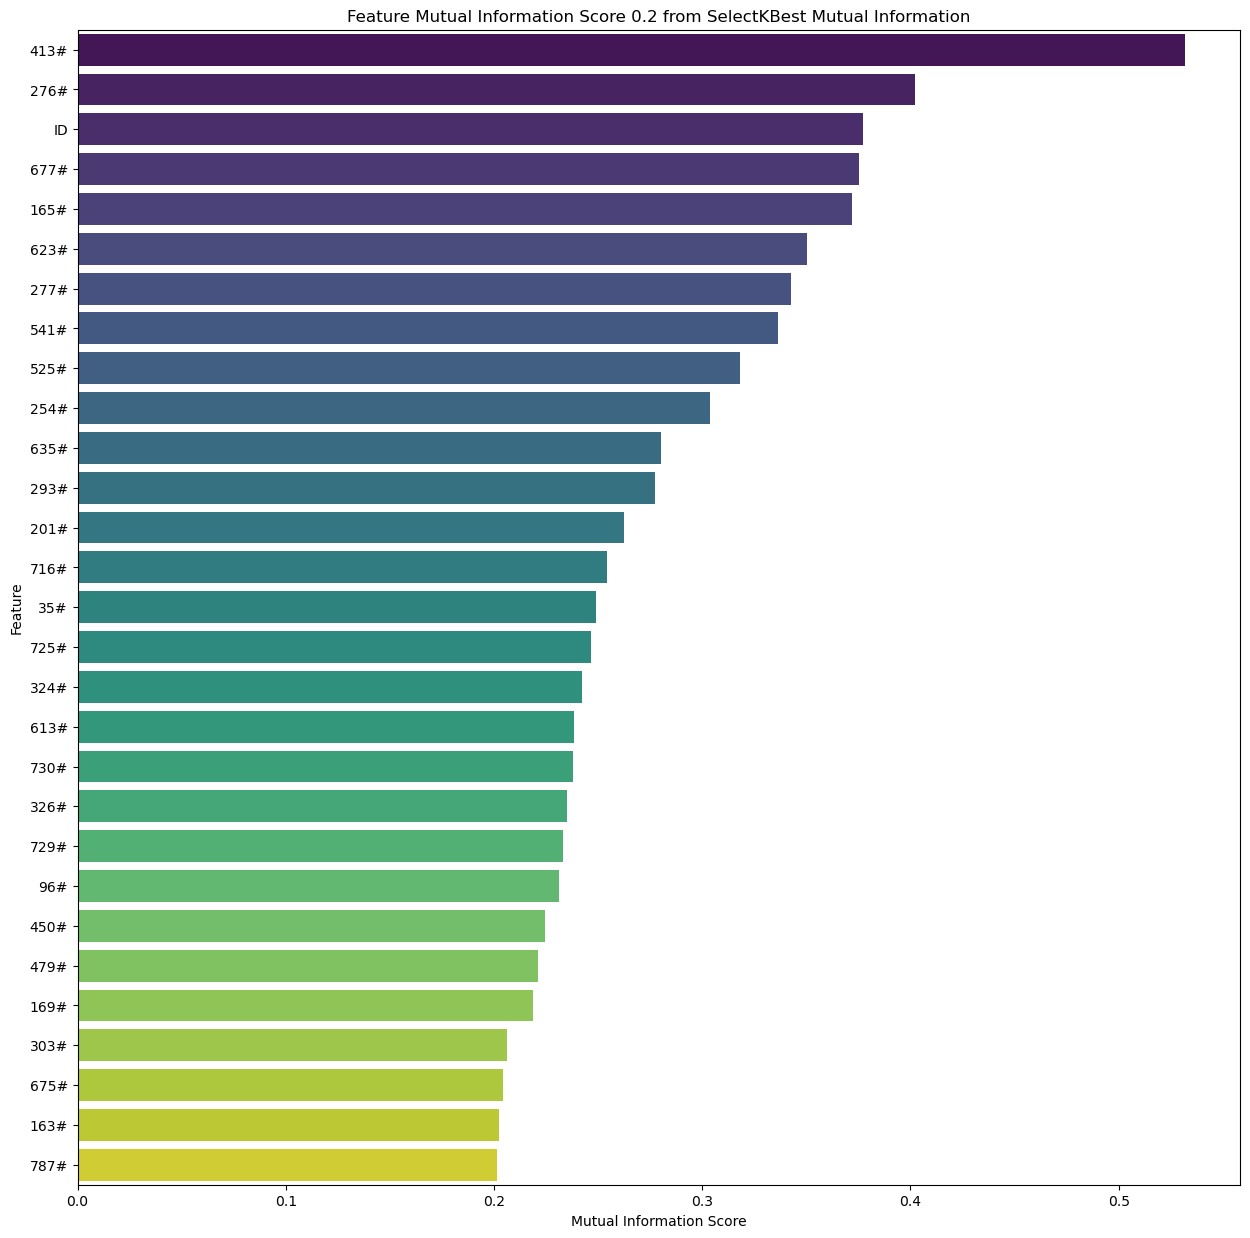

In [49]:
# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='Mutual Information Score', y='Feature', data=filtered_mi_df, palette='viridis')
plt.title(f'Feature Mutual Information Score {threshold} from SelectKBest Mutual Information')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.show()


In [50]:
filtered_mi_df.set_index('Feature', inplace=True)
important_features = filtered_mi_df.index

SelectKBest_Mutual_Information_standardized_data_filtered = standardized_data[important_features]
SelectKBest_Mutual_Information_standardized_data_filtered["EGT"]=standardized_data["EGT"]
SelectKBest_Mutual_Information_standardized_data_filtered

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\1204564475.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SelectKBest_Mutual_Information_standardized_data_filtered["EGT"]=standardized_data["EGT"]


413#      276#        ID      677#      165#      623#      277#  \
0  -0.281681 -0.686114 -1.626978  0.377964 -0.780701  0.023083  1.032676   
1   0.230466  0.158334 -1.410048 -1.133893 -1.071194  2.178267 -0.911185   
2  -0.793829 -1.530561 -1.193118 -1.133893  0.671766  0.084661  0.060746   
3   0.230466  0.158334 -0.976187  1.889822  0.090779  0.084678  1.032676   
4   1.766909 -1.530561 -0.759257  0.377964  0.139195  0.084678  1.032676   
5   0.742614  0.158334 -0.542326  0.377964  0.671766  0.023083 -0.911185   
6   0.230466  0.158334 -0.325396 -1.133893  0.720181  0.084678 -0.911185   
7   1.254761  0.158334 -0.108465 -1.133893 -0.102883  0.084678  0.060746   
8  -0.793829  1.847229  0.108465 -1.133893  2.221063  2.178267  0.060746   
9   0.230466 -0.686114  0.325396  1.889822  1.543245  0.084678  0.060746   
10  1.766909 -0.686114  0.542326  0.377964  0.429688  0.084678  1.032676   
11  0.230466  1.002782  0.759257 -1.133893 -0.054467  0.084678  0.060746   
12 -1.408406  1.847229  0.976187  0.377964 -1.168025 -1.270027 -1.883116   
13 -0.793829 -0.686114  1.193118  0.377964 -0.732285 -1.270027  1.032676   
14 -1.305976 -0.686114  1.410048  0.377964 -1.458518 -1.270027  1.032676   
15 -1.305976  1.002782  1.626978  0.377964 -1.119609 -1.270027 -1.883116   

        541#          525#      254#  ...      729#       96#      450#  \
0  -1.290994  4.966167e-01  1.245174  ... -0.042258  0.209980 -1.828486   
1  -1.290994 -2.483083e+00 -1.053609  ...  1.225474  0.209980  0.301245   
2   0.774597  8.690792e-01 -0.670478  ... -3.000298 -0.461957  0.749609   
3   0.774597  1.241542e+00  0.095783  ... -0.464835  0.209980  1.870520   
4   0.774597 -9.932334e-01  0.478913  ...  1.056443 -0.461957 -1.043848   
5   0.774597 -6.207709e-01  0.478913  ...  0.380319  0.209980  0.077063   
6  -0.258199 -6.207709e-01 -1.819870  ...  0.380319  0.209980  0.525427   
7   0.774597  1.241542e+00 -0.670478  ... -0.042258  0.209980 -0.147120   
8  -0.258199 -1.365696e+00 -1.053609  ... -0.464835  2.897728 -1.043848   
9   0.774597 -6.207709e-01 -0.287348  ...  1.648051 -0.461957  0.077063   
10  0.774597  1.163945e-07 -0.287348  ...  0.380319 -1.805830  0.861700   
11  1.807392  8.690792e-01 -0.670478  ...  0.380319 -1.805830  0.077063   
12 -1.290994  4.966167e-01  1.628305  ... -0.464835  0.209980 -0.707575   
13 -0.258199  4.966167e-01 -0.287348  ... -0.464835  0.209980  1.758429   
14 -1.290994  4.966167e-01  1.628305  ... -0.042258  0.209980 -0.259211   
15 -1.290994  4.966167e-01  1.245174  ... -0.464835  0.209980 -1.268031   

            479#      169#      303#      675#      163#      787#       EGT  
0  -9.540048e-01 -0.709937 -0.617018  0.179605 -1.114844 -0.026812 -1.106777  
1   4.770024e-01 -0.879474  0.041135  1.616448 -1.311944 -0.884811  0.566461  
2   1.049405e+00  1.381022 -1.275170 -1.257237  0.117028 -1.313810 -0.270158  
3   1.908010e-01 -1.162036  0.041135  1.616448  0.461952 -1.099310  2.100263  
4  -9.540048e-01  0.589848 -1.275170  1.616448  0.067753 -0.241312 -0.270158  
5  -8.943802e-09  1.267997  0.041135 -1.257237  0.659051  1.903684  0.287588  
6  -1.812609e+00  0.420311  0.041135 -1.257237  1.693824 -0.670311  0.566461  
7   1.908010e-01 -0.031788  0.041135 -1.257237 -0.030797  1.474685  0.287588  
8   7.632038e-01  0.759386  2.673743 -1.257237 -1.164119  1.474685  1.542517  
9   4.770024e-01  0.024724 -0.617018  0.179605 -0.868470  0.402187  0.705897  
10  7.632038e-01  0.533336 -1.275170  0.179605  1.348900 -0.884811 -0.688468  
11 -9.540048e-02  2.002659  0.699287  0.179605  0.412677  1.260185  0.845334  
12 -1.526408e+00 -1.162036  1.357439  0.179605 -0.769920 -0.026812 -0.967341  
13 -1.240206e+00 -0.879474 -0.617018  0.179605  1.940198 -0.241312 -1.385651  
14  7.632038e-01 -1.162036  0.699287  0.179605 -0.769920 -1.099310 -0.967341  
15  1.908010e+00 -0.992499  0.041135  0.179605 -0.671370 -0.026812 -1.246214  

[16 rows x 30 columns]

In [51]:
target = "EGT"

y = standardized_data_smote[target]
X = standardized_data_smote.drop(columns=[target])

random_seed = 45
k_best = SelectKBest(score_func=mutual_info_regression, k='all')
model = k_best  # Use the instance of SelectKBest directly
model.fit(X, y)

# Get mutual information scores
mi_scores = k_best.scores_

# Create a DataFrame to display mutual information scores
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information Score': mi_scores})

# Filter features with mutual information score above the threshold
threshold = 0.35
filtered_mi_df = mi_df[mi_df['Mutual Information Score'] > threshold]

# Sort the DataFrame by mutual information score
filtered_mi_df = filtered_mi_df.sort_values(by='Mutual Information Score', ascending=False)

print(len(filtered_mi_df))


64


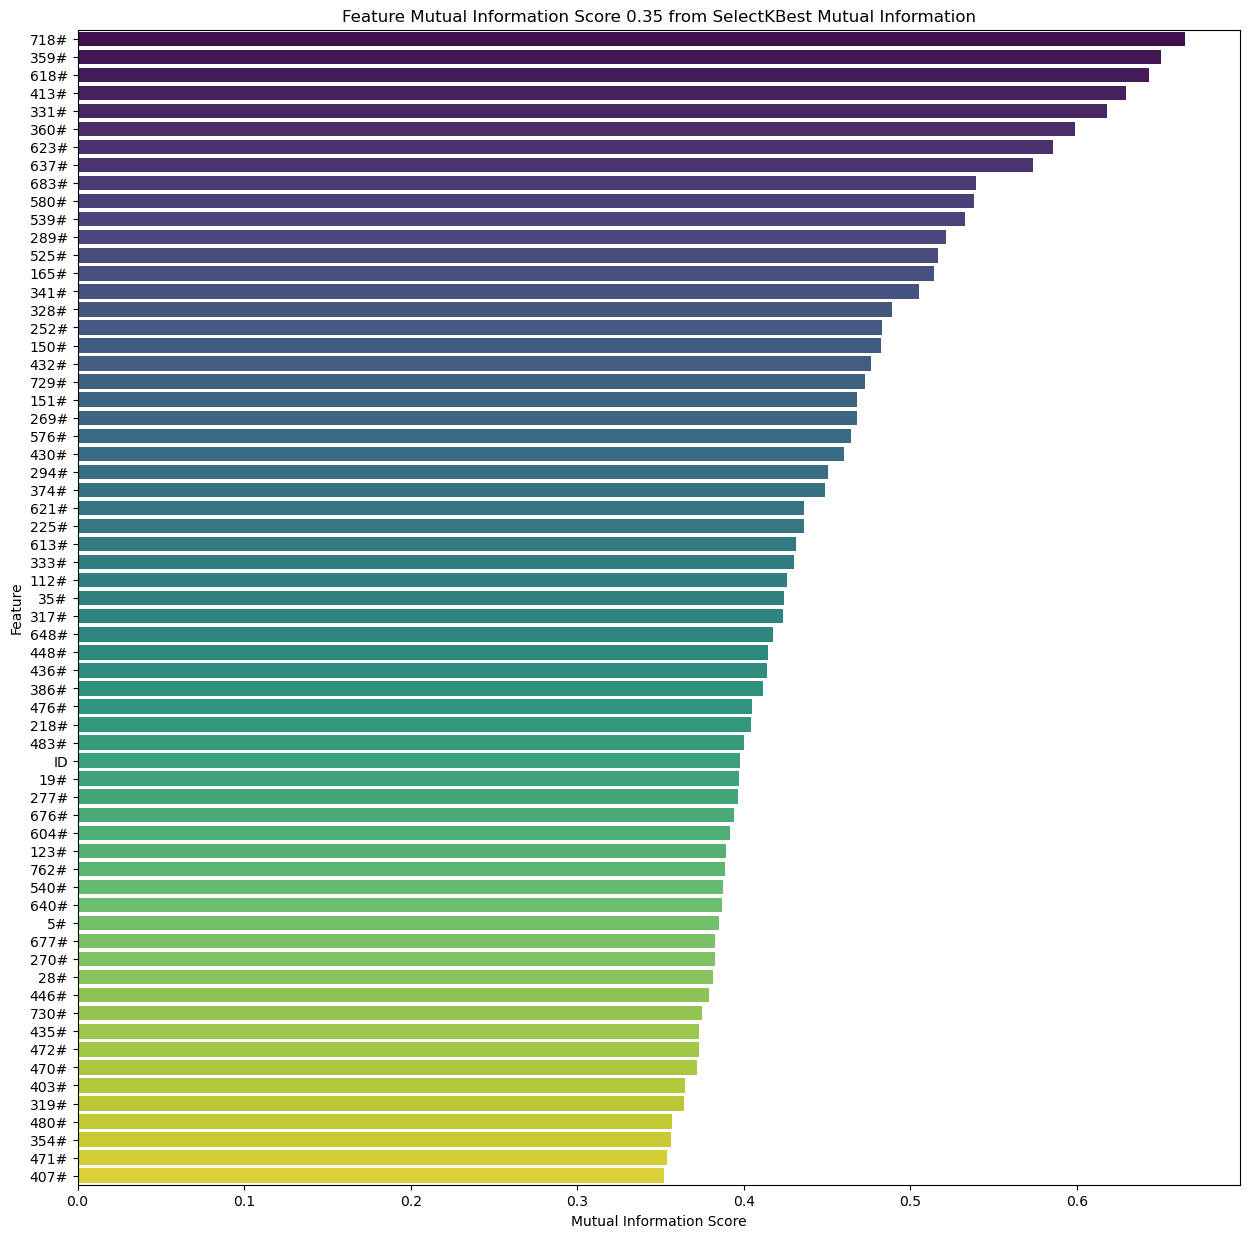

In [52]:
# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='Mutual Information Score', y='Feature', data=filtered_mi_df, palette='viridis')
plt.title(f'Feature Mutual Information Score {threshold} from SelectKBest Mutual Information')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.show()


In [53]:
filtered_mi_df.set_index('Feature', inplace=True)
important_features = filtered_mi_df.index

SelectKBest_Mutual_Information_standardized_data_smote_filtered = standardized_data_smote[important_features]
SelectKBest_Mutual_Information_standardized_data_smote_filtered["EGT"]=standardized_data_smote["EGT"]
SelectKBest_Mutual_Information_standardized_data_smote_filtered

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\4039946596.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SelectKBest_Mutual_Information_standardized_data_smote_filtered["EGT"]=standardized_data_smote["EGT"]


718#      359#      618#      413#      331#      360#      623#  \
0  -1.804806  0.057248  0.953421 -0.906121  1.572987  0.040729 -1.450916   
1   0.713074  0.253528  0.953421  0.134524 -0.210170 -0.154768  0.047870   
2   0.713074 -0.335312  0.445854 -0.906121 -0.629737  0.431723  2.364123   
3   0.713074  0.057248 -2.091982  0.134524  0.314288  0.040729  0.047870   
4  -0.545866 -1.512992 -0.061713 -0.906121  2.202337  1.604705  0.047851   
5  -1.804806 -1.512992  0.953421 -1.426444  1.992554  1.604705 -1.450916   
6   0.713074  0.842368 -0.061713  1.695492  0.628963 -0.741260  0.047870   
7   0.713074  1.234929 -2.091982  1.175169  1.153421 -1.132254  0.047870   
8  -0.545866  2.608889  0.953421  1.695492 -1.573761 -2.500733  0.047870   
9  -1.804806 -1.512992  0.953421 -1.530508 -1.049303  1.604705 -1.450916   
10  0.713074 -0.139032 -0.061713  0.134524 -0.734628  0.236226  0.047870   
11  0.713074  0.057248 -0.061713  0.134524 -0.105279  0.040729  0.047870   
12 -1.384687 -0.139032  0.953421 -0.453964 -1.224319  0.040729 -0.950758   
13  0.713074  1.038649 -1.801924  1.249506  1.078493 -1.132254  0.047870   
14 -0.925785 -1.120432 -0.109764 -0.949226 -0.573258  1.018214 -0.927673   
15  0.713074 -0.335312 -0.033081  0.075820 -0.728711  0.236226  0.178533   
16  0.713074 -0.139032  0.079391 -0.154777 -0.251079  0.040729  0.691791   
17  0.713074  0.253528  0.891044  0.230441 -0.158608 -0.350266  0.047870   
18 -1.803825 -1.512992  0.953421 -1.527996 -1.049712  1.409208 -1.449749   
19  0.703269 -0.531592  0.441901 -0.906121 -0.607679  0.431723  2.346083   
20  0.713074  0.057248  0.251700  0.089044 -0.148261 -0.154768  1.478113   
21 -0.056961  1.431209 -0.229252  1.089295 -0.840543 -1.523248  0.047870   
22  0.704178  0.057248 -2.070463  0.145554  0.300946 -0.154768  0.047870   
23  0.713074  0.842368 -0.108536  1.683492  0.641058 -0.936757  0.047870   

        637#      683#      580#  ...      435#      472#      470#      403#  \
0  -1.073418 -0.692904  2.072298  ...  1.967656 -2.515379 -2.210787  0.049206   
1   1.870135 -1.950611  1.247344  ... -0.261173 -0.789376 -0.701677  0.581978   
2  -0.484707  1.123785 -0.815041  ...  0.481770 -0.264071 -0.392116  0.049206   
3  -0.484707  0.704549  1.659821  ...  0.977065 -0.339114 -0.353421 -1.549108   
4  -0.484707  0.005823 -0.815041  ... -0.508821  0.111147  1.387858 -1.016337   
5   1.281425 -1.251884 -0.815041  ... -1.499412 -0.564245 -0.159946  1.647521   
6   1.281425 -0.832649  0.422390  ... -0.508821  1.011671  0.846127  0.049206   
7   1.281425 -0.692904 -0.815041  ... -0.261173 -0.189027  0.459176  0.049206   
8  -1.073418  0.285313 -1.227518  ...  0.481770 -0.864420 -0.895153 -0.483565   
9  -1.073418  0.005823 -0.815041  ... -1.895648  2.137325  1.929590  1.647521   
10  0.104003  2.102001 -0.815041  ...  1.472360 -0.339114 -0.972543  0.581978   
11 -0.484707  0.145568  1.247344  ...  0.432240 -0.451680 -0.779068 -2.081880   
12 -1.073418  0.005823 -0.952688  ... -1.102283  1.135617  0.986949  0.936359   
13  1.281425 -0.832649 -0.638253  ... -0.296554 -0.017487  0.514458  0.049206   
14 -0.867892  0.145568  0.048962  ... -0.892751  1.272771  1.132564  0.531541   
15  0.070793  1.962256 -0.815041  ...  1.416479 -0.334881 -0.939800  0.551923   
16 -0.484707  0.285313  0.673998  ...  0.446009 -0.399524 -0.671495 -1.489435   
17  1.833960 -1.950611  1.196653  ... -0.276391 -0.678707 -0.606569  0.549240   
18 -1.073418  0.005823 -0.815362  ... -1.893797  2.134987  1.927390  1.645861   
19 -0.484707  0.984039 -0.815041  ...  0.474054 -0.261148 -0.378253  0.040907   
20  0.190871  0.285313 -0.341701  ...  0.102850  0.223924  0.081535  0.049206   
21 -0.844794  0.425058 -0.106229  ...  0.674116 -0.660419 -0.684773 -0.897366   
22 -0.488867  0.564804  1.639418  ...  0.973565 -0.342826 -0.357249 -1.541579   
23  1.281425 -0.832649  0.393852  ... -0.503110  0.983980  0.837203  0.049206   

        319#      480#      354#      471#      407#       EGT  
0   0.771725 -0.

##### f_regression

In [54]:
# Assuming standardized_data is already defined
target = "EGT"

y = normalized_data[target]
X = normalized_data.drop(columns=[target])

random_seed = 46
k_best = SelectKBest(score_func=f_regression, k='all')
model = k_best  # Use the instance of SelectKBest directly
model.fit(X, y)

# Get mutual information scores
f_scores = k_best.scores_

# Create a DataFrame to display f_regression scores
f_df = pd.DataFrame({'Feature': X.columns, 'F Score': f_scores})

# Filter features with f_regression score above the threshold
threshold = 4
filtered_f_df = f_df[f_df['F Score'] > threshold]

# Sort the DataFrame by f_regression score
filtered_f_df = filtered_f_df.sort_values(by='F Score', ascending=False)

print(len(filtered_f_df))


38


C:\Users\liron firuz\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms


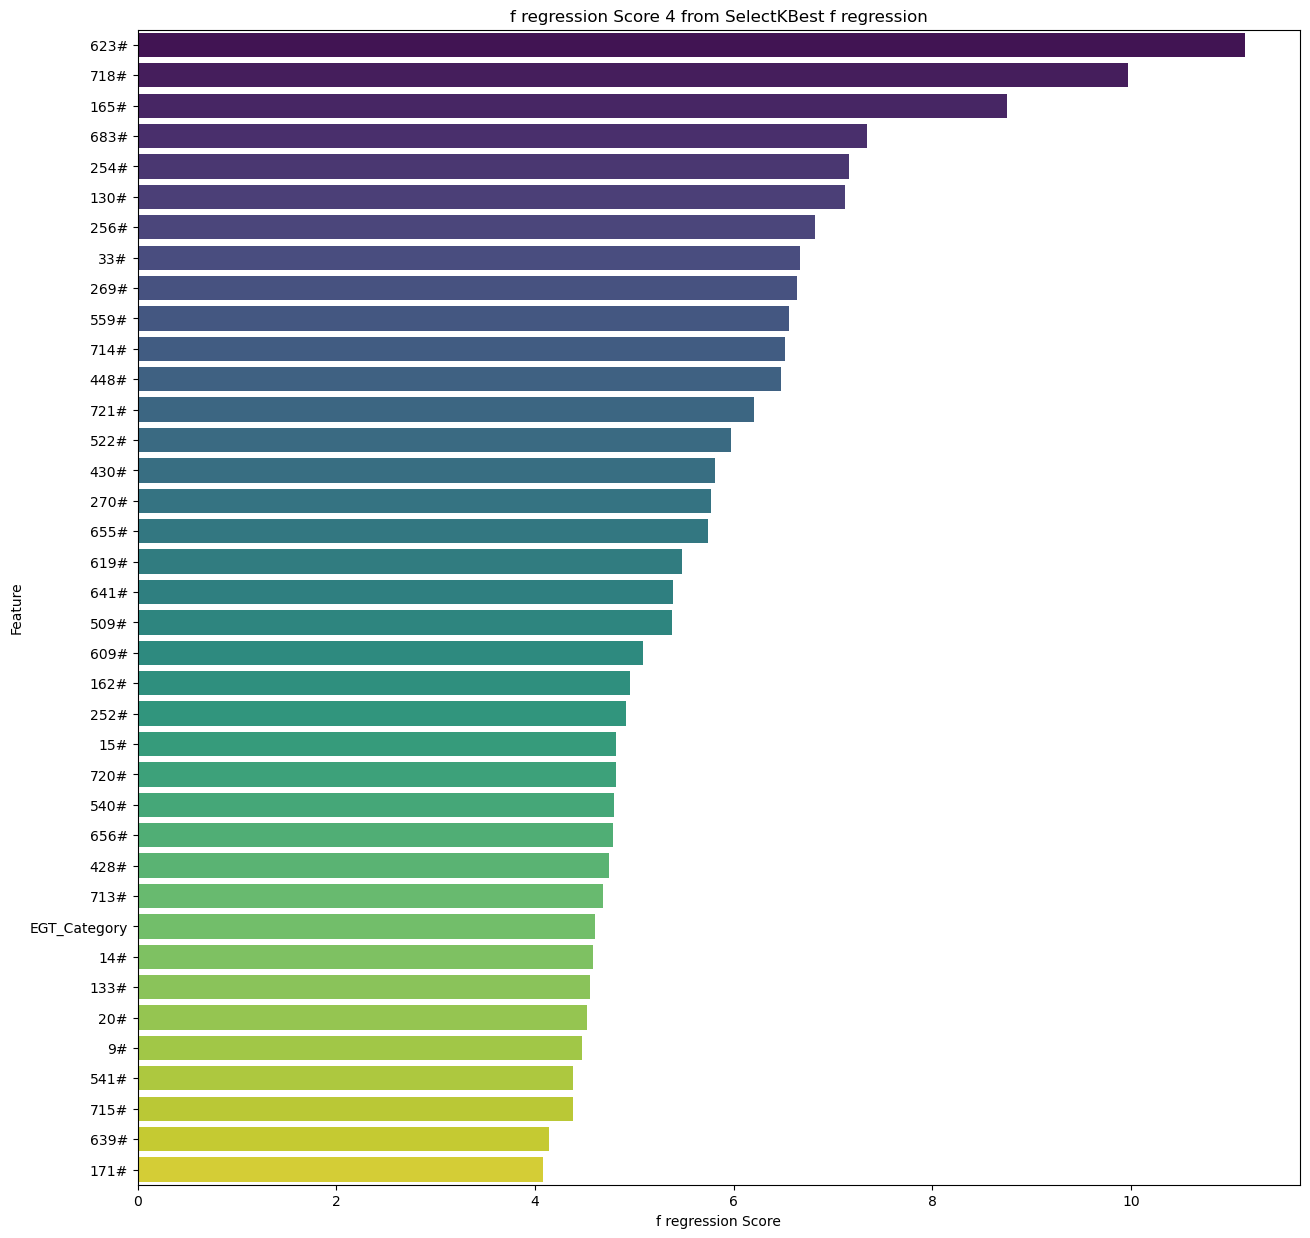

In [55]:
# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='F Score', y='Feature', data=filtered_f_df, palette='viridis')
plt.title(f'f regression Score {threshold} from SelectKBest f regression')
plt.xlabel('f regression Score')
plt.ylabel('Feature')
plt.show()


In [56]:
filtered_f_df.set_index('Feature', inplace=True)
important_features = filtered_f_df.index

SelectKBest_f_regression_normalized_data_filtered = normalized_data[important_features]
SelectKBest_f_regression_normalized_data_filtered["EGT"]=normalized_data["EGT"]
SelectKBest_f_regression_normalized_data_filtered

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\4237698278.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SelectKBest_f_regression_normalized_data_filtered["EGT"]=normalized_data["EGT"]


623#  718#      165#      683#      254#  130#      256#       33#  \
0   0.375000   1.0  0.184211  0.000000  0.888889   0.5  0.285714  0.196532   
1   1.000000   1.0  0.105263  0.818182  0.222222   1.0  0.571429  0.196532   
2   0.392857   0.5  0.578947  0.545455  0.333333   1.0  0.000000  0.123314   
3   0.392863   1.0  0.421053  1.000000  0.555556   1.0  0.428571  1.000000   
4   0.392863   1.0  0.434211  0.363636  0.666667   1.0  0.285714  0.312139   
5   0.375000   1.0  0.578947  0.424242  0.666667   0.5  0.285714  0.614644   
6   0.392863   1.0  0.592105  0.575758  0.000000   1.0  0.142857  0.610790   
7   0.392863   1.0  0.368421  0.393939  0.333333   0.0  0.571429  0.000000   
8   1.000000   1.0  1.000000  0.787879  0.222222   1.0  0.714286  0.396917   
9   0.392863   1.0  0.815789  0.696970  0.444444   0.5  0.571429  0.741811   
10  0.392863   0.5  0.513158  0.606061  0.444444   1.0  0.142857  0.678227   
11  0.392863   1.0  0.381579  0.121212  0.333333   1.0  1.000000  0.658960   
12  0.000000   0.0  0.078947  0.545455  1.000000   0.5  0.285714  0.048170   
13  0.000000   0.0  0.197368  0.393939  0.444444   0.0  0.142857  0.373796   
14  0.000000   1.0  0.000000  0.545455  1.000000   0.0  0.000000  0.403725   
15  0.000000   0.0  0.092105  0.272727  0.888889   0.0  0.428571  0.104046   

        269#      559#  ...  EGT_Category       14#      133#       20#  \
0   0.444444  0.500000  ...           1.0  0.000000  0.000000  0.471698   
1   0.444444  0.375000  ...           1.0  0.142857  0.830508  0.735849   
2   0.814815  0.750000  ...           1.0  0.428571  0.813559  0.566038   
3   0.259259  0.000000  ...           1.0  0.142857  0.542373  0.622642   
4   0.000000  0.125000  ...           1.0  0.285714  0.406780  0.679245   
5   1.000000  0.250000  ...           1.0  0.428571  0.423729  0.679245   
6   1.000000  0.125000  ...           1.0  0.285714  0.881356  0.226415   
7   0.629630  0.125000  ...           1.0  0.285714  0.711864  1.000000   
8   0.185185  0.125000  ...           1.0  0.142857  0.949153  0.679245   
9   0.259259  0.125000  ...           1.0  0.285714  0.966102  0.000000   
10  1.000000  0.125000  ...           1.0  0.714286  1.000000  0.113208   
11  0.629630  0.250000  ...           1.0  0.000000  0.728814  0.981132   
12  1.000000  0.316666  ...           1.0  0.285714  0.576271  0.245283   
13  1.000000  0.250000  ...           0.0  1.000000  0.406780  0.188679   
14  1.000000  1.000000  ...           1.0  0.142857  0.406780  0.169811   
15  1.000000  0.625000  ...           0.0  0.571429  0.440678  0.150943   

          9#      541#  715#   639#      171#   EGT  
0   0.865385  0.000000   0.2  0.100  0.447368  0.08  
1   0.884615  0.000000   0.0  0.400  0.447368  0.56  
2   0.542308  0.666667   0.0  0.000  0.368421  0.32  
3   0.926923  0.666667   0.0  1.000  1.000000  1.00  
4   0.830769  0.666667   0.0  0.175  0.710526  0.32  
5   0.511538  0.666667   0.0  0.450  0.473684  0.48  
6   0.146154  0.333333   0.0  0.225  0.157895  0.56  
7   0.692308  0.666667   0.0  0.275  0.710526  0.48  
8   1.000000  0.333333   0.0  0.225  0.421053  0.84  
9   0.611538  0.666667   0.0  0.250  0.131579  0.60  
10  0.842308  0.666667   0.0  0.550  0.000000  0.20  
11  0.761538  1.000000   0.0  0.500  0.421053  0.64  
12  0.696154  0.000000   1.0  0.175  0.184211  0.12  
13  0.238462  0.333333   1.0  0.425  0.000000  0.00  
14  0.276923  0.000000   0.0  0.075  0.447368  0.12  
15  0.000000  0.000000   0.0  0.375  0.421053  0.04  

[16 rows x 39 columns]

In [57]:
# Assuming standardized_data is already defined
target = "EGT"

y = normalized_data_smote[target]
X = normalized_data_smote.drop(columns=[target])

random_seed = 46
k_best = SelectKBest(score_func=f_regression, k='all')
model = k_best  # Use the instance of SelectKBest directly
model.fit(X, y)

# Get mutual information scores
f_scores = k_best.scores_

# Create a DataFrame to display f_regression scores
f_df = pd.DataFrame({'Feature': X.columns, 'F Score': f_scores})

# Filter features with f_regression score above the threshold
threshold = 8
filtered_f_df = f_df[f_df['F Score'] > threshold]

# Sort the DataFrame by f_regression score
filtered_f_df = filtered_f_df.sort_values(by='F Score', ascending=False)

print(len(filtered_f_df))


35


C:\Users\liron firuz\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms


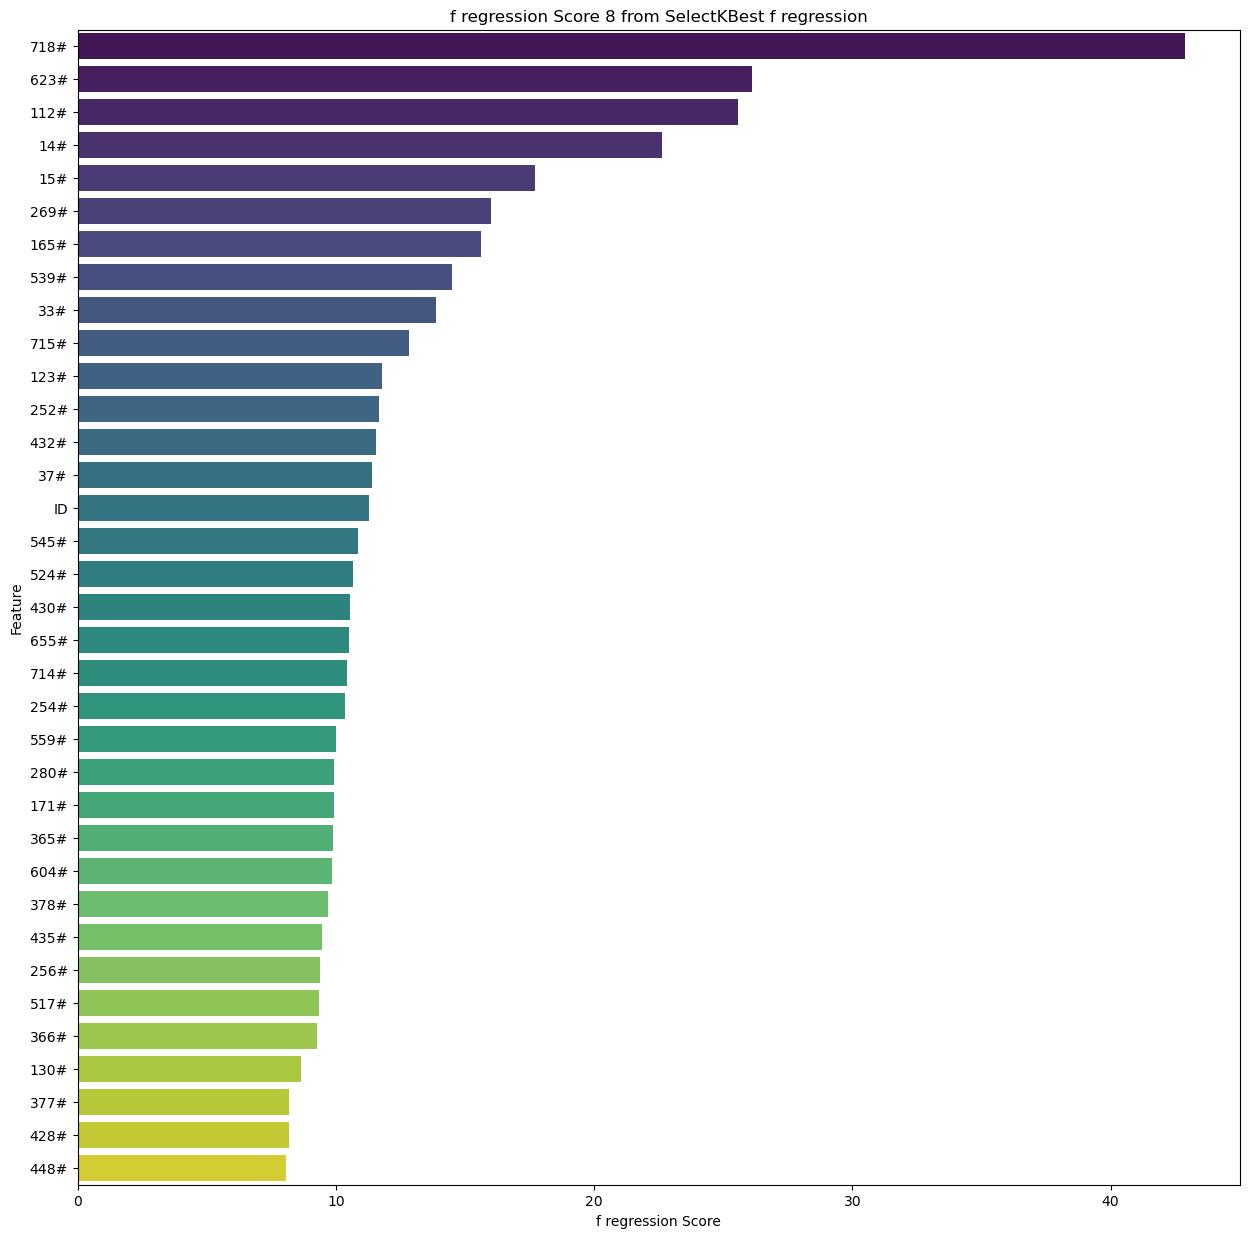

In [58]:
# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='F Score', y='Feature', data=filtered_f_df, palette='viridis')
plt.title(f'f regression Score {threshold} from SelectKBest f regression')
plt.xlabel('f regression Score')
plt.ylabel('Feature')
plt.show()

In [59]:
filtered_f_df.set_index('Feature', inplace=True)
important_features = filtered_f_df.index

SelectKBest_f_regression_normalized_data_smote_filtered = normalized_data_smote[important_features]
SelectKBest_f_regression_normalized_data_smote_filtered["EGT"]=normalized_data_smote["EGT"]
SelectKBest_f_regression_normalized_data_smote_filtered

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\320388466.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SelectKBest_f_regression_normalized_data_smote_filtered["EGT"]=normalized_data_smote["EGT"]


718#      623#  112#       14#       15#      269#      165#  \
0   0.000000  0.000000   1.0  1.000000  1.000000  1.000000  0.128571   
1   1.000000  0.392863   1.0  0.000000  0.000000  0.629630  0.328571   
2   1.000000  1.000000   0.0  0.142857  0.142857  0.185185  1.000000   
3   1.000000  0.392863   1.0  0.285714  0.428571  0.259259  0.800000   
4   0.500000  0.392857   1.0  0.428571  0.571429  0.814815  0.542857   
5   0.000000  0.000000   1.0  0.571429  0.571429  1.000000  0.014286   
6   1.000000  0.392863   1.0  0.285714  0.142857  0.000000  0.385714   
7   1.000000  0.392863   1.0  0.285714  0.142857  0.629630  0.314286   
8   0.500000  0.392863   1.0  0.714286  0.714286  1.000000  0.471429   
9   0.000000  0.000000   1.0  0.285714  0.285714  1.000000  0.000000   
10  1.000000  0.392863   0.0  0.142857  0.000000  0.259259  0.371429   
11  1.000000  0.392863   1.0  0.285714  0.428571  1.000000  0.557143   
12  0.166854  0.131102   1.0  0.428732  0.428732  1.000000  0.157320   
13  1.000000  0.392863   1.0  0.285714  0.142857  0.539676  0.324490   
14  0.349112  0.137153   1.0  0.285714  0.335587  0.741399  0.279289   
15  1.000000  0.427112   0.0  0.142857  0.008059  0.255081  0.406887   
16  1.000000  0.561647   0.0  0.246000  0.349143  0.773480  0.680258   
17  1.000000  0.392863   1.0  0.017556  0.008778  0.590941  0.332083   
18  0.000389  0.000306   1.0  0.286048  0.286048  1.000000  0.000367   
19  0.996106  0.995271   0.0  0.145082  0.146195  0.190089  0.996440   
20  1.000000  0.767759   0.0  0.197503  0.142857  0.114348  0.765024   
21  0.694173  0.392863   1.0  0.547851  0.603329  0.712336  0.599028   
22  0.996467  0.392863   1.0  0.288743  0.430590  0.264494  0.797678   
23  1.000000  0.392863   1.0  0.285714  0.142857  0.014521  0.384067   

        539#       33#      715#  ...      378#      435#      256#      517#  \
0   0.250000  0.373796  1.000000  ...  0.400000  1.000000  0.142857  0.890909   
1   0.750000  0.658960  0.000000  ...  0.200000  0.423077  1.000000  0.890909   
2   0.250000  0.396917  0.000000  ...  0.400000  0.615385  0.714286  0.909091   
3   0.750000  0.741811  0.000000  ...  0.200000  0.743590  0.571429  0.909091   
4   0.500000  0.123314  0.000000  ...  0.200000  0.358974  0.000000  0.909091   
5   0.500000  0.104046  0.000000  ...  0.400000  0.102564  0.428571  0.000000   
6   0.500000  0.312139  0.000000  ...  0.400000  0.358974  0.285714  1.000000   
7   0.750000  0.000000  0.000000  ...  0.600000  0.423077  0.571429  0.818182   
8   0.250000  0.678227  0.000000  ...  0.000000  0.615385  0.142857  0.890909   
9   0.000000  0.048170  1.000000  ...  0.200000  0.000000  0.285714  0.636364   
10  1.000000  1.000000  0.000000  ...  1.000000  0.871795  0.428571  1.000000   
11  0.750000  0.610790  0.000000  ...  0.200000  0.602564  0.142857  0.909091   
12  0.083427  0.258425  0.666291  ...  0.133258  0.205359  0.238042  0.721308   
13  0.714283  0.044594  0.000000  ...  0.571427  0.413919  0.530609  0.844158   
14  0.261834  0.290328  0.650888  ...  0.200000  0.259596  0.385460  0.731576   
15  0.957691  0.965979  0.000000  ...  0.966153  0.857330  0.444689  0.994872   
16  0.610999  0.551333  0.000000  ...  0.255600  0.606128  0.301715  0.909091   
17  0.734638  0.637648  0.000000  ...  0.212289  0.419138  0.956109  0.897612   
18  0.000195  0.048660  0.999221  ...  0.199844  0.000479  0.285603  0.636562   
19  0.251947  0.394786  0.000000  ...  0.398442  0.613388  0.708723  0.909091   
20  0.345630  0.364488  0.000000  ...  0.400000  0.517303  0.550349  0.943865   
21  0.444173  0.702920  0.000000  ...  0.077669  0.665173  0.309292  0.897970   
22  0.746467  0.741362  0.000000  ...  0.198587  0.742684  0.568400  0.908962   
23  0.505766  0.304940  0.000000  ...  0.404612  0.360453  0.292304  0.995807   

    366#      130#      377#      428#      448#   EGT  
0   0.50  0.000000  0.000000  0.500000  0.000000  0.00  
1   1.00  1.000000  0.166667  0.250000  0.823529  0.64  
2   1.00  

In [60]:
# Assuming standardized_data is already defined
target = "EGT"

y = standardized_data[target]
X = standardized_data.drop(columns=[target])

random_seed = 47
k_best = SelectKBest(score_func=f_regression, k='all')
model = k_best  # Use the instance of SelectKBest directly
model.fit(X, y)

# Get mutual information scores
f_scores = k_best.scores_

# Create a DataFrame to display f_regression scores
f_df = pd.DataFrame({'Feature': X.columns, 'F Score': f_scores})

# Filter features with f_regression score above the threshold
threshold = 4
filtered_f_df = f_df[f_df['F Score'] > threshold]

# Sort the DataFrame by f_regression score
filtered_f_df = filtered_f_df.sort_values(by='F Score', ascending=False)

print(len(filtered_f_df))


38


C:\Users\liron firuz\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms


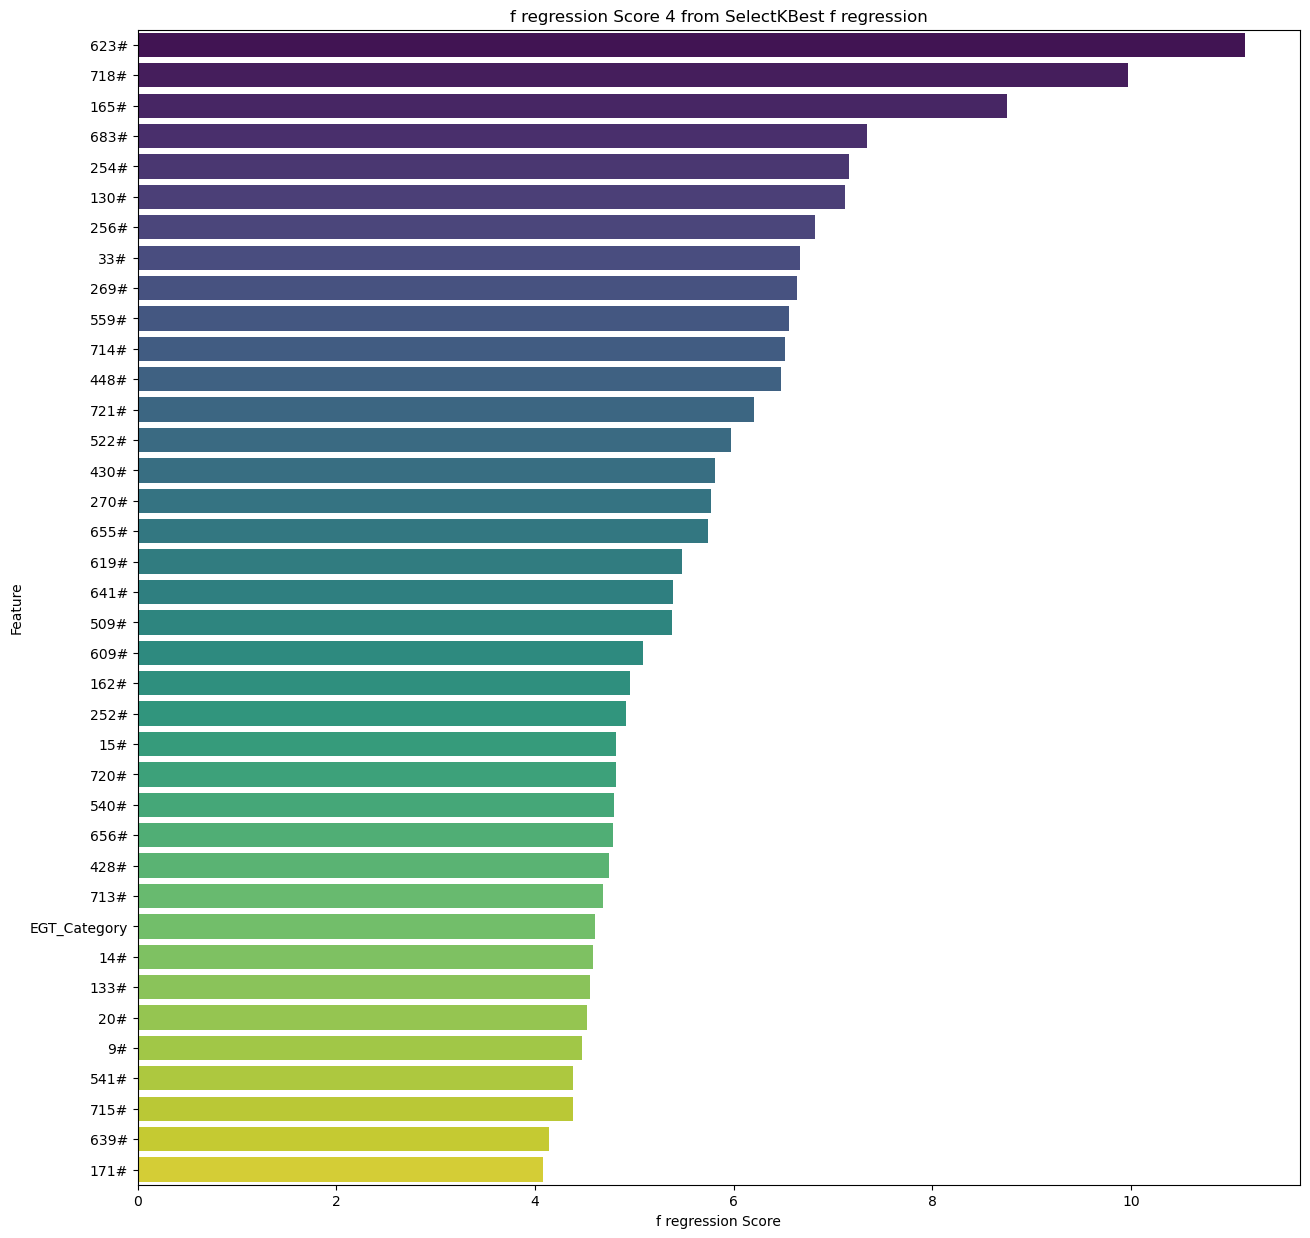

In [61]:
# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='F Score', y='Feature', data=filtered_f_df, palette='viridis')
plt.title(f'f regression Score {threshold} from SelectKBest f regression')
plt.xlabel('f regression Score')
plt.ylabel('Feature')
plt.show()


In [62]:
filtered_f_df.set_index('Feature', inplace=True)
important_features = filtered_f_df.index

SelectKBest_f_regression_standardized_data_filtered = standardized_data[important_features]
SelectKBest_f_regression_standardized_data_filtered["EGT"]=standardized_data["EGT"]
SelectKBest_f_regression_standardized_data_filtered

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\799058427.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SelectKBest_f_regression_standardized_data_filtered["EGT"]=standardized_data["EGT"]


623#      718#      165#      683#      254#      130#      256#  \
0   0.023083  0.632456 -0.780701 -2.035442  1.245174 -0.301511 -0.306364   
1   2.178267  0.632456 -1.071194  1.257857 -1.053609  0.904534  0.782929   
2   0.084661 -0.632456  0.671766  0.160091 -0.670478  0.904534 -1.395656   
3   0.084678  0.632456  0.090779  1.989702  0.095783  0.904534  0.238283   
4   0.084678  0.632456  0.139195 -0.571753  0.478913  0.904534 -0.306364   
5   0.023083  0.632456  0.671766 -0.327805  0.478913 -0.301511 -0.306364   
6   0.084678  0.632456  0.720181  0.282065 -1.819870  0.904534 -0.851010   
7   0.084678  0.632456 -0.102883 -0.449779 -0.670478 -1.507557  0.782929   
8   2.178267  0.632456  2.221063  1.135883 -1.053609  0.904534  1.327575   
9   0.084678  0.632456  1.543245  0.769961 -0.287348 -0.301511  0.782929   
10  0.084678 -0.632456  0.429688  0.404039 -0.287348  0.904534 -0.851010   
11  0.084678  0.632456 -0.054467 -1.547546 -0.670478  0.904534  2.416868   
12 -1.270027 -1.897367 -1.168025  0.160091  1.628305 -0.301511 -0.306364   
13 -1.270027 -1.897367 -0.732285 -0.449779 -0.287348 -1.507557 -0.851010   
14 -1.270027  0.632456 -1.458518  0.160091  1.628305 -1.507557 -1.395656   
15 -1.270027 -1.897367 -1.119609 -0.937675  1.245174 -1.507557  0.238283   

             33#      269#      559#  ...  EGT_Category       14#      133#  \
0  -7.410568e-01 -0.643268  0.692677  ...      0.377964 -1.260252 -2.360684   
1  -7.410568e-01 -0.643268  0.220397  ...      0.377964 -0.700140  0.749864   
2  -1.002931e+00  0.428845  1.637237  ...      0.377964  0.420084  0.686384   
3   2.132663e+00 -1.179324 -1.196442  ...      0.377964 -0.700140 -0.329305   
4  -3.275719e-01 -1.929803 -0.724162  ...      0.377964 -0.140028 -0.837150   
5   7.543802e-01  0.964901 -0.251883  ...      0.377964  0.420084 -0.773669   
6   7.405973e-01  0.964901 -0.724162  ...      0.377964 -0.140028  0.940306   
7  -1.443981e+00 -0.107211 -0.724162  ...      0.377964 -0.140028  0.305500   
8  -2.434966e-02 -1.393746 -0.724162  ...      0.377964 -0.700140  1.194228   
9   1.209214e+00 -1.179324 -0.724162  ...      0.377964 -0.140028  1.257709   
10  9.817968e-01  0.964901 -0.724162  ...      0.377964  1.540308  1.384670   
11  9.128827e-01 -0.107211 -0.251883  ...      0.377964 -1.260252  0.368981   
12 -1.271696e+00  0.964901 -0.000001  ...      0.377964 -0.140028 -0.202344   
13 -1.070466e-01  0.964901 -0.251883  ...     -2.645751  2.660532 -0.837150   
14 -2.153568e-10  0.964901  2.581797  ...      0.377964 -0.700140 -0.837150   
15 -1.071845e+00  0.964901  1.164957  ...     -2.645751  0.980196 -0.710189   

         20#        9#      541#      715#      639#      171#       EGT  
0   0.007688  0.854336 -1.290994  0.189661 -0.969087  0.197685 -1.106777  
1   0.868743  0.919739 -1.290994 -0.417254  0.323029  0.197685  0.566461  
2   0.315207 -0.244446  0.774597 -0.417254 -1.399793 -0.108408 -0.270158  
3   0.499719  1.063628  0.774597 -0.417254  2.907262  2.340335  2.100263  
4   0.684231  0.736609  0.774597 -0.417254 -0.646058  1.217994 -0.270158  
5   0.684231 -0.349092  0.774597 -0.417254  0.538382  0.299716  0.287588  
6  -0.791863 -1.591762 -0.258199 -0.417254 -0.430706 -0.924655  0.566461  
7   1.729797  0.265703  0.774597 -0.417254 -0.215353  1.217994  0.287588  
8   0.684231  1.312162 -0.258199 -0.417254 -0.430706  0.095654  1.542517  
9  -1.529909 -0.008993  0.774597 -0.417254 -0.323029 -1.026686  0.705897  
10 -1.160886  0.775851  0.774597 -0.417254  0.969087 -1.536841 -0.688468  
11  1.668293  0.501156  1.807392 -0.417254  0.753735  0.095654  0.845334  
12 -0.730359  0.278783 -1.290994  2.617319 -0.646058 -0.822624 -0.967341  
13 -0.914870 -1.277825 -0.258199  2.617319  0.430706 -1.536841 -1.385651  
14 -0.976374 -1.147017 -1.290994 -0.417254 -1.076764  0.197685 -0.967341  
15 -1.037878 -2.088830 -1.290994 -0.417254  0.215353  0.095654 -1.246214  

[16 rows x 39 columns]

In [63]:
# Assuming standardized_data is already defined
target = "EGT"

y = standardized_data_smote[target]
X = standardized_data_smote.drop(columns=[target])

random_seed = 47
k_best = SelectKBest(score_func=f_regression, k='all')
model = k_best  # Use the instance of SelectKBest directly
model.fit(X, y)

# Get mutual information scores
f_scores = k_best.scores_

# Create a DataFrame to display f_regression scores
f_df = pd.DataFrame({'Feature': X.columns, 'F Score': f_scores})

# Filter features with f_regression score above the threshold
threshold = 8
filtered_f_df = f_df[f_df['F Score'] > threshold]

# Sort the DataFrame by f_regression score
filtered_f_df = filtered_f_df.sort_values(by='F Score', ascending=False)

print(len(filtered_f_df))


35


C:\Users\liron firuz\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms


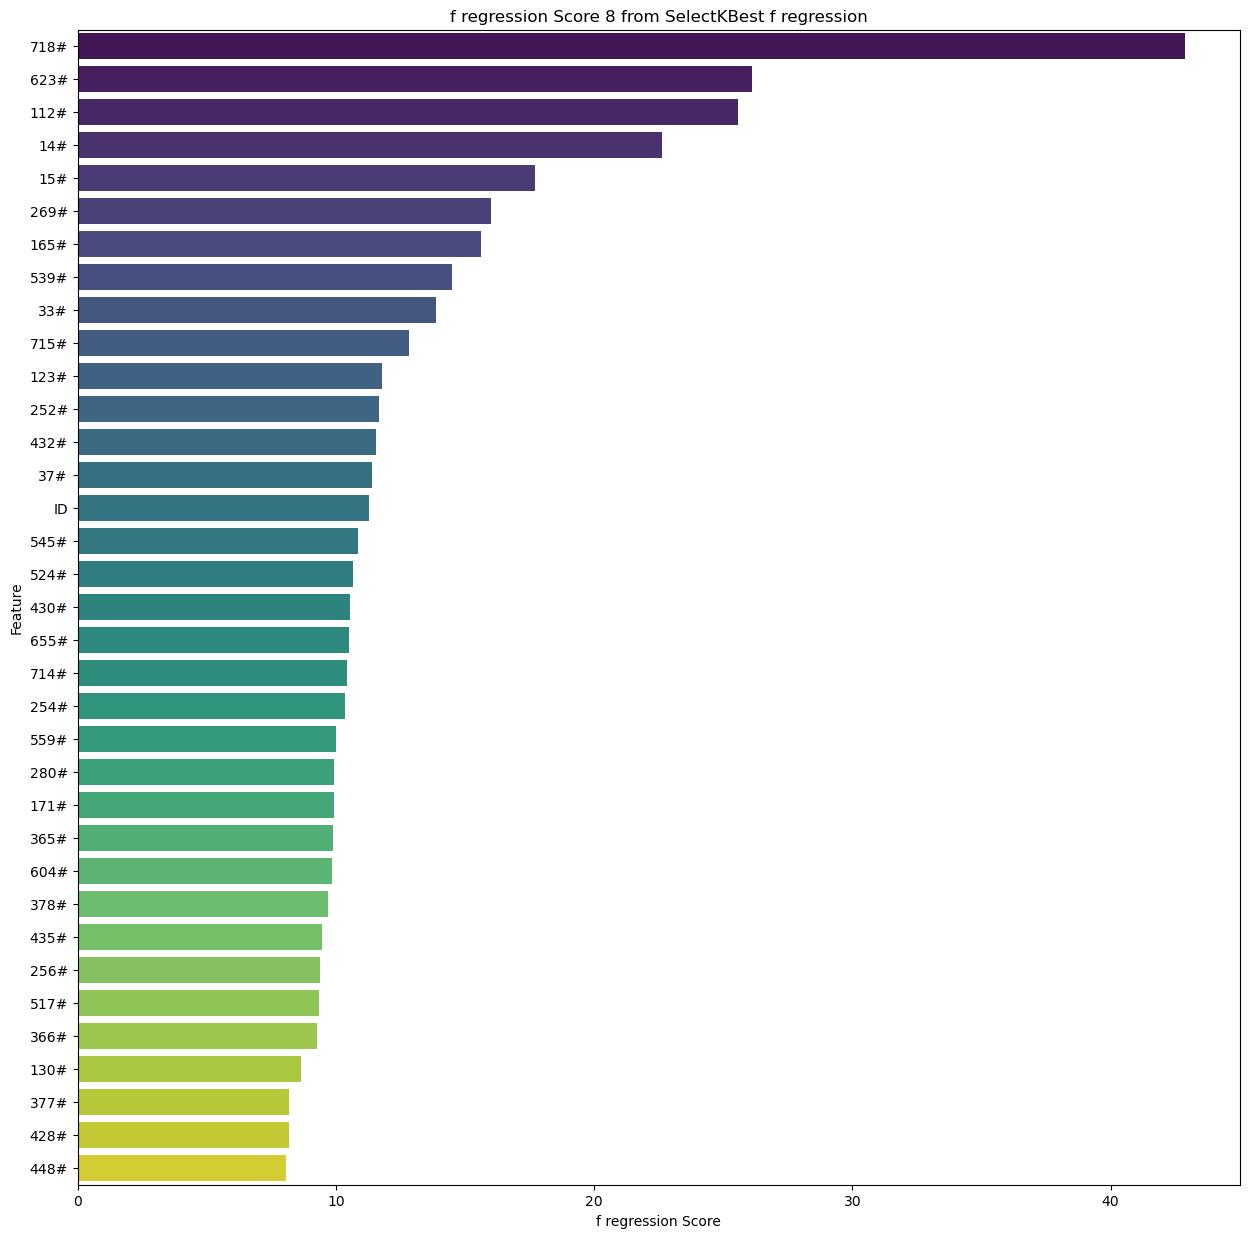

In [64]:
# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='F Score', y='Feature', data=filtered_f_df, palette='viridis')
plt.title(f'f regression Score {threshold} from SelectKBest f regression')
plt.xlabel('f regression Score')
plt.ylabel('Feature')
plt.show()


In [65]:
filtered_f_df.set_index('Feature', inplace=True)
important_features = filtered_f_df.index

SelectKBest_f_regression_standardized_data_smote_filtered = standardized_data_smote[important_features]
SelectKBest_f_regression_standardized_data_smote_filtered["EGT"]=standardized_data_smote["EGT"]
SelectKBest_f_regression_standardized_data_smote_filtered

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\2914696990.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SelectKBest_f_regression_standardized_data_smote_filtered["EGT"]=standardized_data_smote["EGT"]


718#      623#      112#       14#       15#      269#      165#  \
0  -1.804806 -1.450916  0.577350  3.184640  2.766104  1.187659 -1.109449   
1   0.713074  0.047870  0.577350 -1.471858 -1.246038  0.134685 -0.404244   
2   0.713074  2.364123 -1.732051 -0.806644 -0.672875 -1.128885  1.963229   
3   0.713074  0.047870  0.577350 -0.141430  0.473451 -0.918290  1.258024   
4  -0.545866  0.047851  0.577350  0.523784  1.046614  0.661172  0.351332   
5  -1.804806 -1.450916  0.577350  1.188998  1.046614  1.187659 -1.512423   
6   0.713074  0.047870  0.577350 -0.141430 -0.672875 -1.655372 -0.202757   
7   0.713074  0.047870  0.577350 -0.141430 -0.672875  0.134685 -0.454616   
8  -0.545866  0.047870  0.577350  1.854212  1.619777  1.187659  0.099473   
9  -1.804806 -1.450916  0.577350 -0.141430 -0.099712  1.187659 -1.562795   
10  0.713074  0.047870 -1.732051 -0.806644 -1.246038 -0.918290 -0.253129   
11  0.713074  0.047870  0.577350 -0.141430  0.473451  1.187659  0.401704   
12 -1.384687 -0.950758  0.577350  0.524533  0.474096  1.187659 -1.008082   
13  0.713074  0.047870  0.577350 -0.141430 -0.672875 -0.121055 -0.418634   
14 -0.925785 -0.927673  0.577350 -0.141430  0.100386  0.452448 -0.578015   
15  0.713074  0.178533 -1.732051 -0.806644 -1.213705 -0.930170 -0.128101   
16  0.713074  0.691791 -1.732051 -0.326361  0.154771  0.543657  0.835810   
17  0.713074  0.047870  0.577350 -1.390107 -1.210819  0.024691 -0.391864   
18 -1.803825 -1.449749  0.577350 -0.139876 -0.098373  1.187659 -1.561500   
19  0.703269  2.346083 -1.732051 -0.796282 -0.659483 -1.114943  1.950674   
20  0.713074  1.478113 -1.732051 -0.552188 -0.672875 -1.330276  1.134699   
21 -0.056961  0.047870  0.577350  1.079210  1.174605  0.369821  0.549393   
22  0.704178  0.047870  0.577350 -0.127328  0.481551 -0.903408  1.249837   
23  0.713074  0.047870  0.577350 -0.141430 -0.672875 -1.614089 -0.208566   

        539#       33#      715#  ...      378#      435#      256#      517#  \
0  -0.877248 -0.199623  2.285799  ...  0.239976  1.967656 -1.171418  0.253990   
1   0.904856  0.788567 -0.501251  ... -0.593445 -0.261173  2.342905  0.253990   
2  -0.877248 -0.119500 -0.501251  ...  0.239976  0.481770  1.171464  0.344294   
3   0.904856  1.075677 -0.501251  ... -0.593445  0.977065  0.585743  0.344294   
4   0.013804 -1.067629 -0.501251  ... -0.593445 -0.508821 -1.757139  0.344294   
5   0.013804 -1.134399 -0.501251  ...  0.239976 -1.499412  0.000023 -4.170944   
6   0.013804 -0.413286 -0.501251  ...  0.239976 -0.508821 -0.585698  0.795818   
7   0.904856 -1.494955 -0.501251  ...  1.073397 -0.261173  0.585743 -0.107230   
8  -0.877248  0.855337 -0.501251  ... -1.426865  0.481770 -1.171418  0.253990   
9  -1.768300 -1.328031  2.285799  ... -0.593445 -1.895648 -0.585698 -1.010277   
10  1.795907  1.970390 -0.501251  ...  2.740238  1.472360  0.000023  0.795818   
11  0.904856  0.621643 -0.501251  ... -0.593445  0.432240 -1.171418  0.344294   
12 -1.470948 -0.599422  1.355736  ... -0.871564 -1.102283 -0.781158 -0.588381   
13  0.777554 -1.340420 -0.501251  ...  0.954328 -0.296554  0.418383  0.021786   
14 -0.835070 -0.488869  1.312808  ... -0.593445 -0.892751 -0.176734 -0.537381   
15  1.645110  1.852496 -0.501251  ...  2.599194  1.416479  0.066106  0.770347   
16  0.409429  0.415605 -0.501251  ... -0.361753  0.446009 -0.520094  0.344294   
17  0.850103  0.714717 -0.501251  ... -0.542233 -0.276391  2.162951  0.287283   
18 -1.767606 -1.326330  2.283629  ... -0.594094 -1.893797 -0.586154 -1.009293   
19 -0.870308 -0.126884 -0.501251  ...  0.233485  0.474054  1.148655  0.344294   
20 -0.536404 -0.231879 -0.501251  ...  0.239976  0.102850  0.499317  0.517011   
21 -0.185174  0.940905 -0.501251  ... -1.103209  0.674116 -0.489030  0.289059   
22  0.892263  1.074120 -0.501251  ... -0.599334  0.973565  0.573327  0.343656   
23  0.034354 -0.438232 -0.501251  ...  0.259197 -0.503110 -0.558681  0.774992   

        366#      130#      377#      428#      448#       EGT  
0  -0.939336 -1.

#### PCA

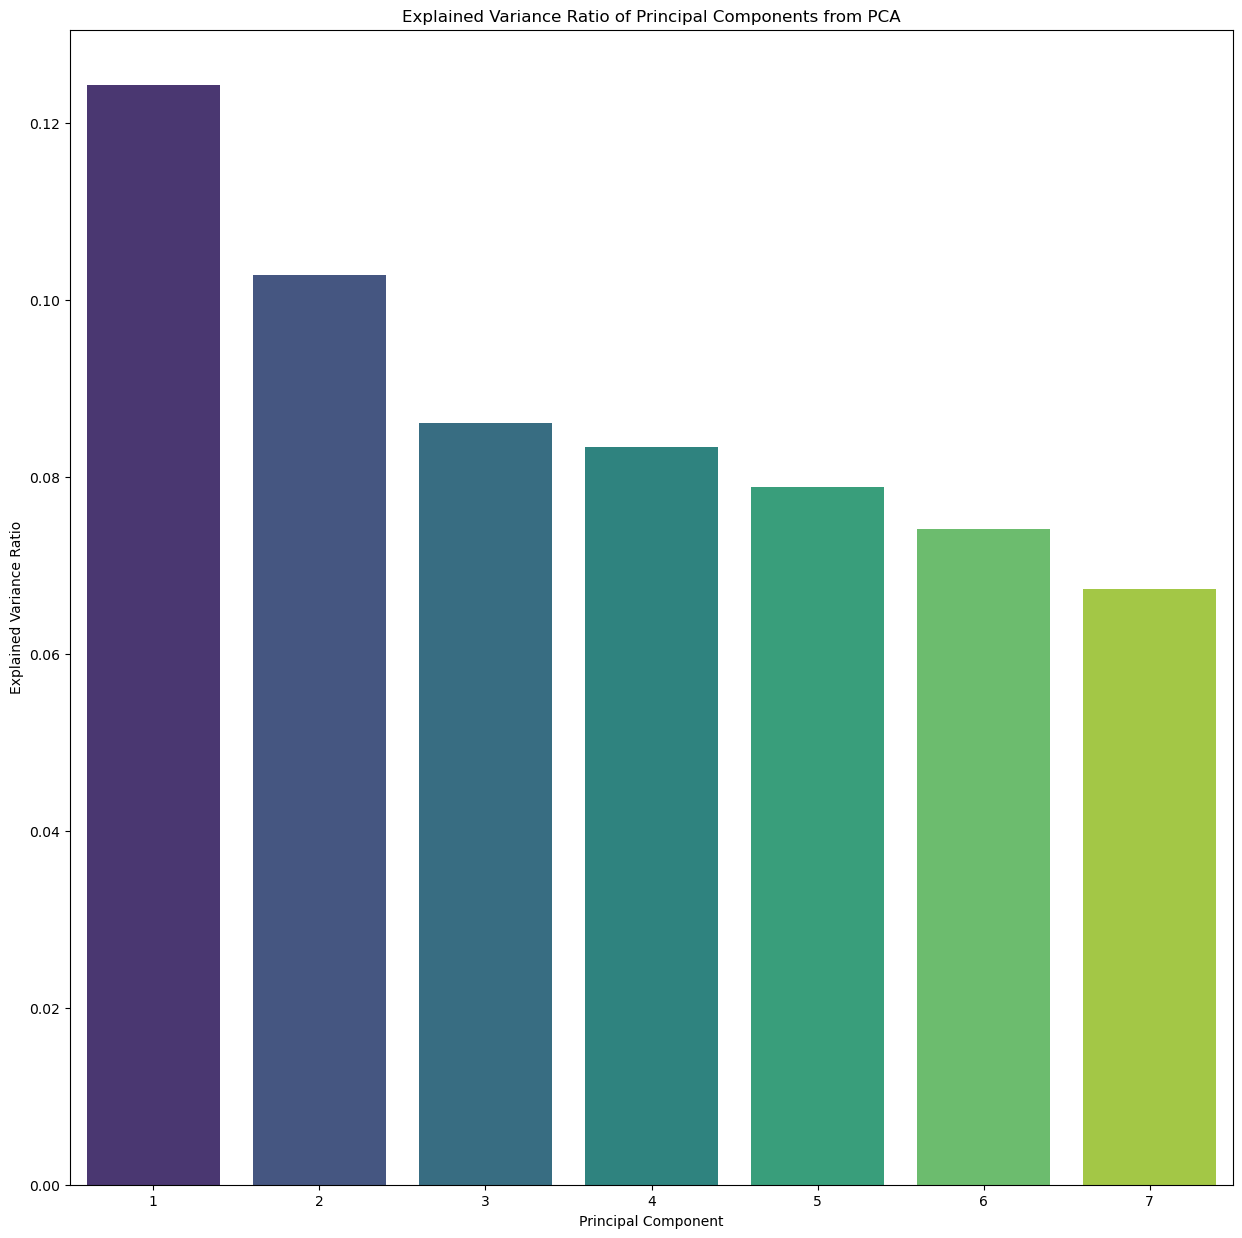

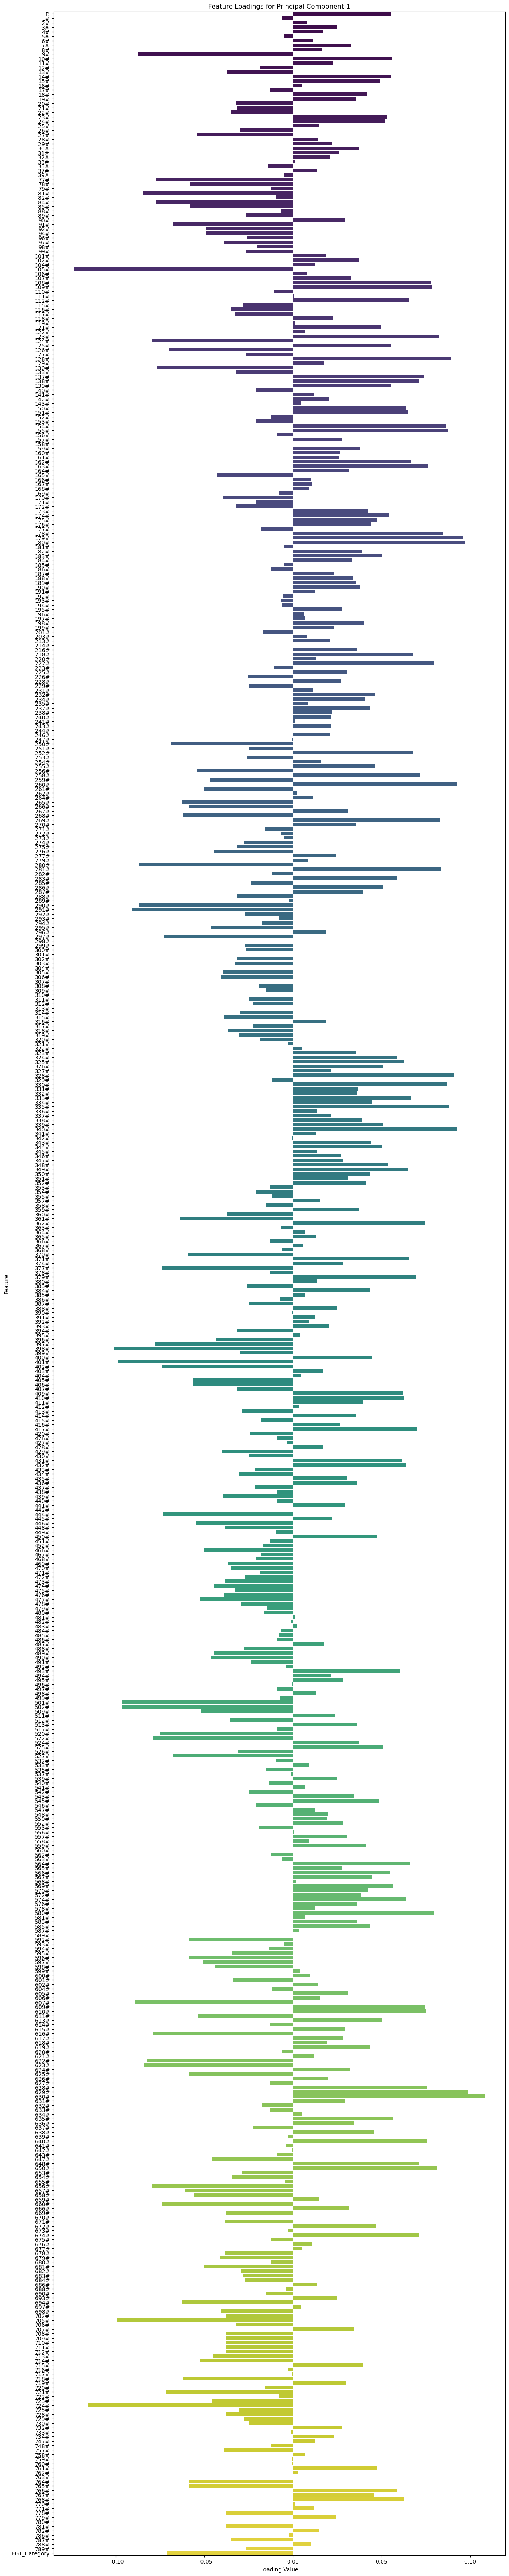

Top features for each principal component above the threshold:
PC1: ['105#', '724#', '630#', '398#', '705#', '629#', '401#', '180#', '501#', '502#']
PC2: ['94#', '92#', '102#', '85#', '78#', '112#', '716#', '721#', '477#', '91#']
PC3: ['119#', '115#', '716#', '384#', '426#', '85#', '78#', '81#', '84#', '77#']
PC4: ['111#', '101#', '102#', '723#', '351#', '371#', '370#', '112#', '125#', '386#']
PC5: ['527#', '694#', '143#', '105#', '326#', '770#', '713#', '407#', '417#', '324#']
PC6: ['92#', '94#', '327#', '126#', '782#', '353#', '617#', '694#', '417#', '130#']
PC7: ['650#', '401#', '240#', '231#', '225#', '228#', '115#', '246#', '353#', '532#']


In [66]:
target = "EGT"

y = normalized_data[target]
X = normalized_data.drop(columns=[target])

random_seed = 48

# Initialize PCA
n_components = min(len(X.columns), len(X))  # You can set the number of components as needed
pca = PCA(n_components=n_components, random_state=random_seed)

# Fit PCA model
pca.fit(X)

# Transform the data
X_pca = pca.transform(X)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a DataFrame to display explained variance ratio for each principal component
pca_df = pd.DataFrame({'Principal Component': range(1, n_components + 1),
                       'Explained Variance Ratio': explained_variance_ratio})

# Filter principal components by explained variance ratio threshold
threshold = 0.06
filtered_pca_df = pca_df[pca_df['Explained Variance Ratio'] > threshold]

# Sort the DataFrame by explained variance ratio
sorted_pca_df = filtered_pca_df.sort_values(by='Explained Variance Ratio', ascending=False)

plt.figure(figsize=(15, 15))
sns.barplot(y='Explained Variance Ratio', x='Principal Component', data=sorted_pca_df, palette='viridis')
plt.title('Explained Variance Ratio of Principal Components from PCA')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.show()

# Get the principal components
principal_components = pca.components_

# Create a DataFrame for feature loadings
loadings_df = pd.DataFrame(principal_components.T, columns=[f'PC{i+1}' for i in range(n_components)], index=X.columns)

# Plotting the feature loadings for the first principal component (PC1)
plt.figure(figsize=(15, 85))
sns.barplot(x=loadings_df['PC1'].values, y=loadings_df.index, palette='viridis')
plt.title('Feature Loadings for Principal Component 1')
plt.xlabel('Loading Value')
plt.ylabel('Feature')
plt.show()

# Identify the most influential features for each principal component above the threshold
top_features = {}
for pc in sorted_pca_df['Principal Component']:
    pc_name = f'PC{pc}'
    top_features[pc_name] = loadings_df[pc_name].abs().sort_values(ascending=False).head(10).index.tolist()

print("Top features for each principal component above the threshold:")
for pc, features in top_features.items():
    print(f"{pc}: {features}")


In [67]:
text = """
PC1: ['105#', '724#', '630#', '398#', '705#', '629#', '401#', '180#', '501#', '502#']
PC2: ['94#', '92#', '102#', '85#', '78#', '112#', '716#', '721#', '477#', '91#']
PC3: ['119#', '115#', '716#', '384#', '426#', '85#', '78#', '81#', '84#', '77#']
PC4: ['111#', '101#', '102#', '723#', '351#', '371#', '370#', '112#', '125#', '386#']
PC5: ['527#', '694#', '143#', '105#', '326#', '770#', '713#', '407#', '417#', '324#']
PC6: ['92#', '94#', '327#', '126#', '782#', '353#', '617#', '694#', '417#', '130#']
PC7: ['650#', '401#', '240#', '231#', '225#', '228#', '115#', '246#', '353#', '532#']
"""

# Extract numbers from the text
numbers = re.findall(r'\d+#', text)

# Count occurrences of each number
count = Counter(numbers)

# Get all the keys from the dictionary
unique_numbers = list(count.keys())

In [68]:
pca_normalized_data=normalized_data[unique_numbers]
pca_normalized_data['EGT']=normalized_data['EGT']
pca_normalized_data

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\803458478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_normalized_data['EGT']=normalized_data['EGT']


105#  724#  630#      398#      705#  629#  401#   180#  501#  502#  ...  \
0    1.0   1.0   0.0  0.862069  1.000000   0.0   1.0  0.250   1.0   1.0  ...   
1    1.0   1.0   0.0  0.931034  1.000000   0.0   1.0  0.075   1.0   1.0  ...   
2    0.0   0.0   0.5  0.000000  0.000000   0.0   0.0  0.750   1.0   1.0  ...   
3    1.0   1.0   0.0  0.241379  0.000000   0.0   1.0  0.700   1.0   1.0  ...   
4    0.0   0.0   0.0  0.137931  0.000000   0.0   1.0  0.775   1.0   1.0  ...   
5    0.0   1.0   0.0  0.034483  0.000000   0.0   0.0  0.850   1.0   1.0  ...   
6    1.0   1.0   0.0  0.103448  0.000000   0.0   0.0  0.925   1.0   1.0  ...   
7    0.0   1.0   0.0  0.000000  0.000000   0.0   1.0  1.000   1.0   1.0  ...   
8    1.0   1.0   0.0  0.775862  1.000000   0.0   1.0  0.125   1.0   1.0  ...   
9    1.0   0.0   0.0  0.862069  0.000000   0.0   0.0  0.000   1.0   1.0  ...   
10   1.0   1.0   0.0  0.689655  0.000000   0.0   1.0  0.125   1.0   1.0  ...   
11   0.0   0.0   1.0  0.241379  0.333333   1.0   1.0  0.700   1.0   1.0  ...   
12   0.0   1.0   0.5  1.000000  0.000000   0.5   0.0  0.025   1.0   1.0  ...   
13   0.0   0.0   1.0  0.275862  0.000000   1.0   0.0  0.800   0.0   0.0  ...   
14   0.0   0.0   1.0  0.137931  0.000000   1.0   0.0  0.650   0.0   0.0  ...   
15   0.0   0.0   0.0  0.034483  0.000000   0.0   1.0  0.850   1.0   1.0  ...   

    617#  130#  650#      240#  231#      225#      228#      246#      532#  \
0    0.9   0.5   1.0  0.000000  0.00  0.039216  0.203390  0.075758  0.000000   
1    1.0   1.0   0.0  1.000000  1.00  1.000000  1.000000  1.000000  0.000000   
2    1.0   1.0   1.0  0.446154  0.05  0.313725  0.169492  0.696970  1.000000   
3    0.5   1.0   1.0  0.169231  1.00  0.274510  0.779661  0.303030  0.333333   
4    1.0   1.0   1.0  0.784615  0.65  0.156863  0.338983  0.696970  0.333333   
5    0.5   0.5   1.0  0.200000  0.00  0.000000  0.237288  0.000000  0.000000   
6    0.5   1.0   1.0  0.876923  0.70  0.254902  0.000000  0.651515  0.000000   
7    0.0   0.0   0.0  1.000000  1.00  0.764706  0.779661  0.924242  0.000000   
8    1.0   1.0   0.0  0.723077  0.90  0.509804  0.203390  0.621212  0.000000   
9    0.0   0.5   1.0  0.184615  0.80  0.627451  0.135593  0.242424  1.000000   
10   1.0   1.0   0.0  0.492308  0.80  0.039216  0.389831  0.848485  0.000000   
11   1.0   1.0   0.0  1.000000  1.00  0.725490  0.796610  0.848485  0.000000   
12   0.5   0.5   1.0  0.184615  0.65  0.117647  0.220339  0.151515  0.333333   
13   1.0   0.0   1.0  1.000000  1.00  1.000000  1.000000  1.000000  0.000000   
14   1.0   0.0   1.0  0.107692  1.00  0.666667  0.508475  0.121212  0.000000   
15   1.0   0.0   1.0  0.600000  0.80  0.509804  0.033898  0.742424  0.000000   

     EGT  
0   0.08  
1   0.56  
2   0.32  
3   1.00  
4   0.32  
5   0.48  
6   0.56  
7   0.48  
8   0.84  
9   0.60  
10  0.20  
11  0.64  
12  0.12  
13  0.00  
14  0.12  
15  0.04  

[16 rows x 58 columns]

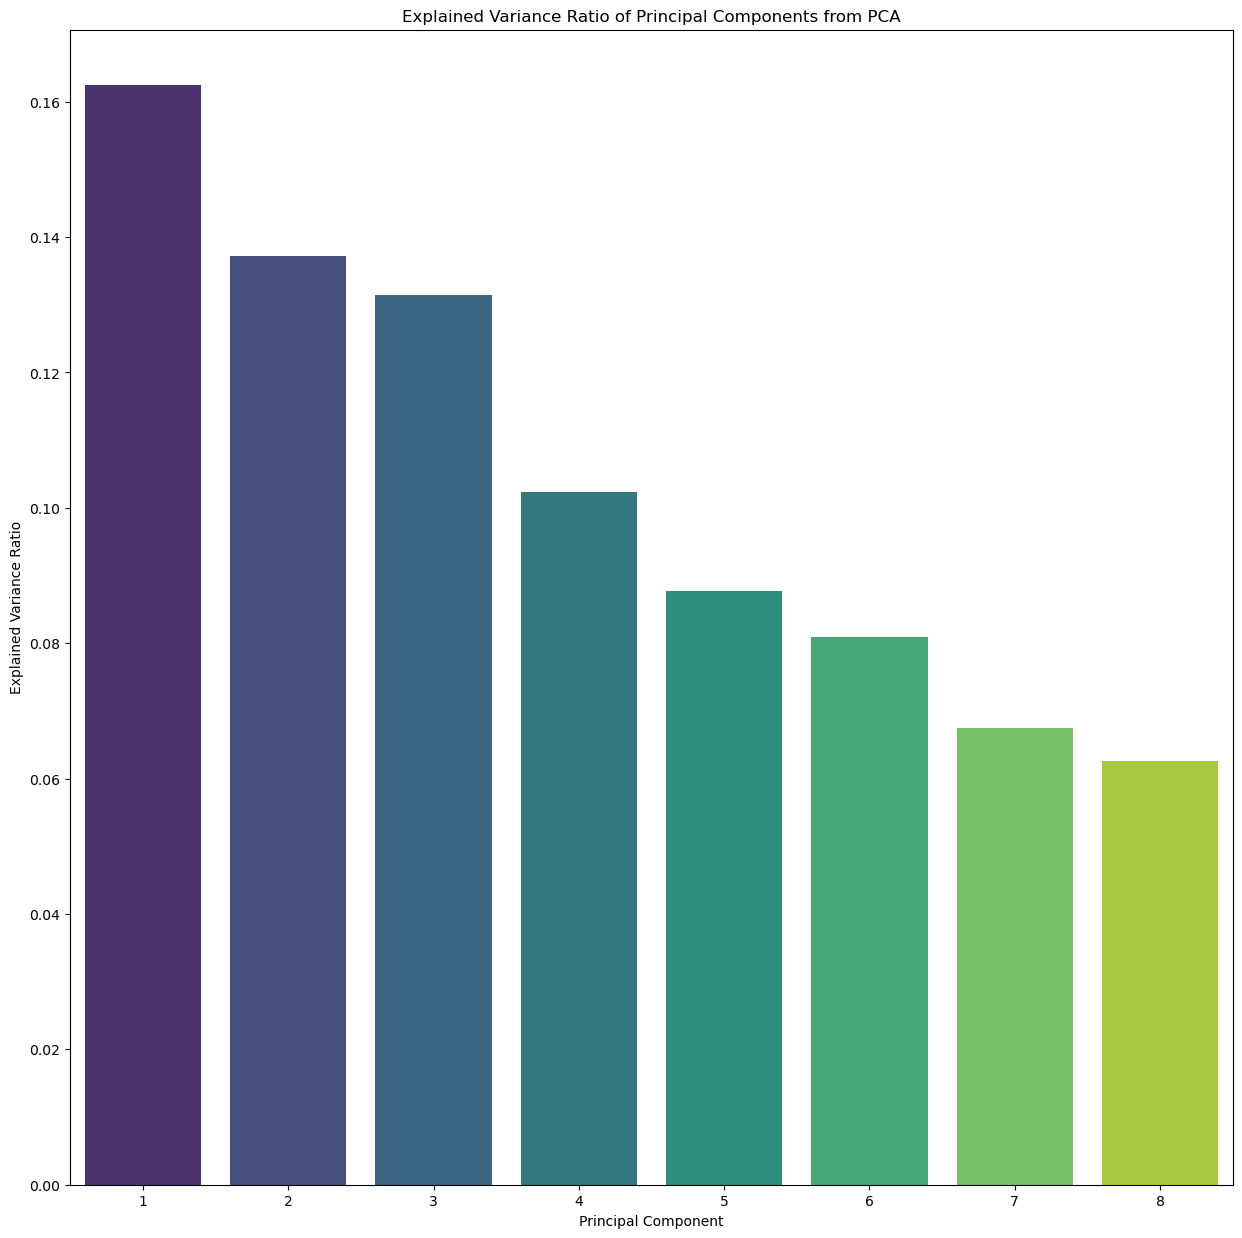

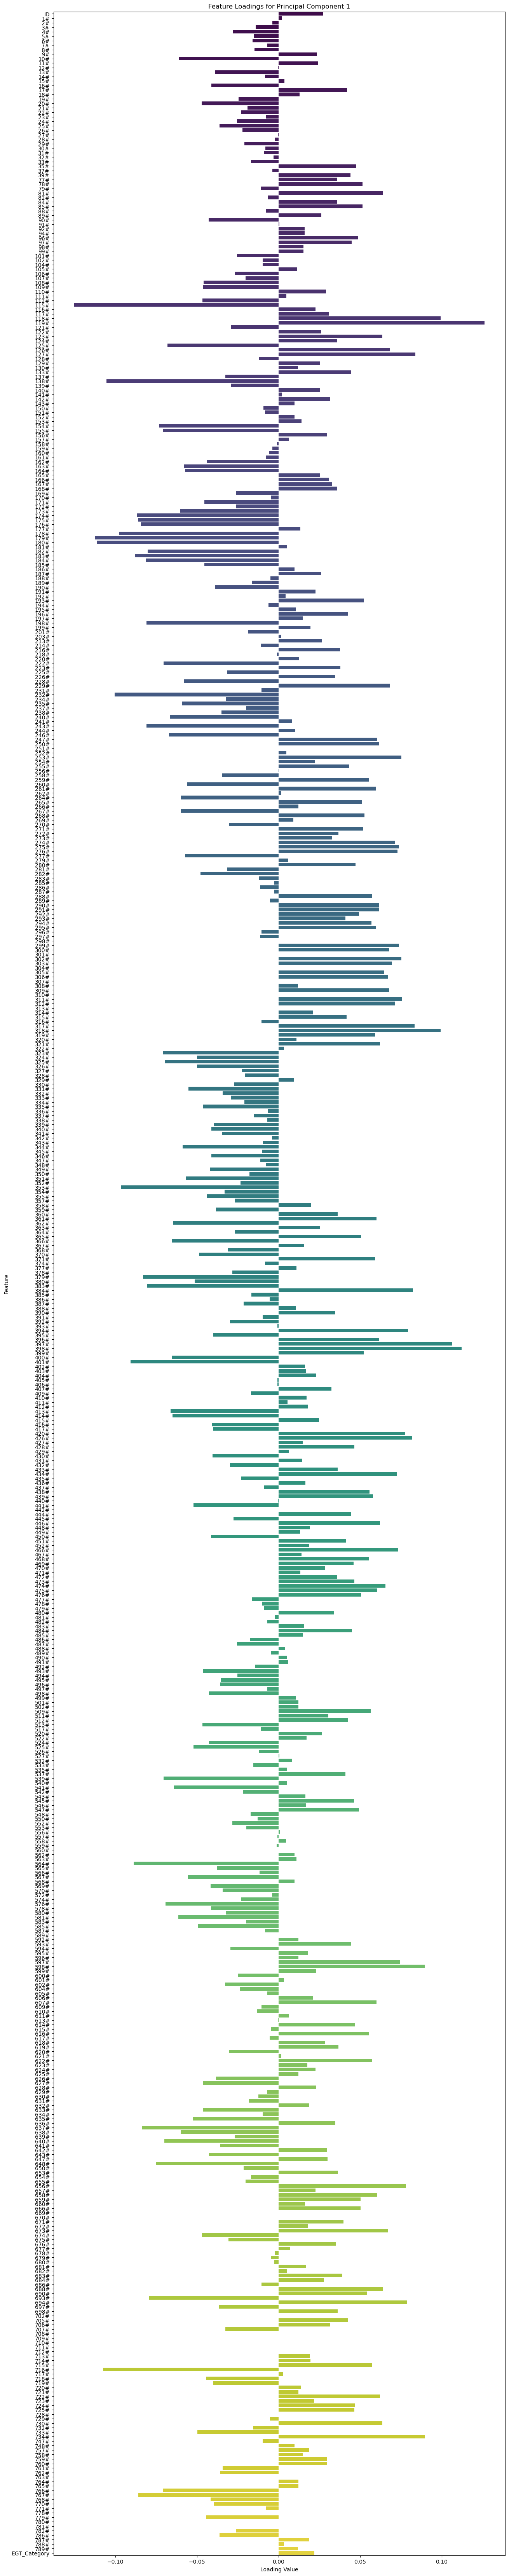

Top features for each principal component above the threshold:
PC1: ['119#', '115#', '179#', '398#', '180#', '716#', '397#', '138#', '232#', '318#']
PC2: ['647#', '137#', '314#', '192#', '241#', '240#', '196#', '99#', '512#', '22#']
PC3: ['78#', '85#', '81#', '77#', '84#', '92#', '94#', '786#', '105#', '427#']
PC4: ['102#', '527#', '101#', '377#', '340#', '401#', '328#', '343#', '335#', '269#']
PC5: ['91#', '17#', '112#', '725#', '633#', '627#', '94#', '92#', '537#', '723#']
PC6: ['232#', '678#', '279#', '401#', '127#', '583#', '767#', '229#', '609#', '673#']
PC7: ['542#', '386#', '118#', '128#', '327#', '617#', '718#', '713#', '105#', '385#']
PC8: ['130#', '673#', '426#', '195#', '332#', '105#', '427#', '723#', '724#', '758#']


In [69]:
target = "EGT"

y = normalized_data_smote[target]
X = normalized_data_smote.drop(columns=[target])

random_seed = 49

# Initialize PCA
n_components = min(len(X.columns), len(X))  # You can set the number of components as needed
pca = PCA(n_components=n_components, random_state=random_seed)

# Fit PCA model
pca.fit(X)

# Transform the data
X_pca = pca.transform(X)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a DataFrame to display explained variance ratio for each principal component
pca_df = pd.DataFrame({'Principal Component': range(1, n_components + 1),
                       'Explained Variance Ratio': explained_variance_ratio})

# Filter principal components by explained variance ratio threshold
threshold = 0.06
filtered_pca_df = pca_df[pca_df['Explained Variance Ratio'] > threshold]

# Sort the DataFrame by explained variance ratio
sorted_pca_df = filtered_pca_df.sort_values(by='Explained Variance Ratio', ascending=False)

plt.figure(figsize=(15, 15))
sns.barplot(y='Explained Variance Ratio', x='Principal Component', data=sorted_pca_df, palette='viridis')
plt.title('Explained Variance Ratio of Principal Components from PCA')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.show()

# Get the principal components
principal_components = pca.components_

# Create a DataFrame for feature loadings
loadings_df = pd.DataFrame(principal_components.T, columns=[f'PC{i+1}' for i in range(n_components)], index=X.columns)

# Plotting the feature loadings for the first principal component (PC1)
plt.figure(figsize=(15, 85))
sns.barplot(x=loadings_df['PC1'].values, y=loadings_df.index, palette='viridis')
plt.title('Feature Loadings for Principal Component 1')
plt.xlabel('Loading Value')
plt.ylabel('Feature')
plt.show()

# Identify the most influential features for each principal component above the threshold
top_features = {}
for pc in sorted_pca_df['Principal Component']:
    pc_name = f'PC{pc}'
    top_features[pc_name] = loadings_df[pc_name].abs().sort_values(ascending=False).head(10).index.tolist()

print("Top features for each principal component above the threshold:")
for pc, features in top_features.items():
    print(f"{pc}: {features}")


In [70]:
text = """
Top features for each principal component above the threshold:
PC1: ['119#', '115#', '179#', '398#', '180#', '716#', '397#', '138#', '232#', '318#']
PC2: ['647#', '137#', '314#', '192#', '241#', '240#', '196#', '99#', '512#', '22#']
PC3: ['78#', '85#', '81#', '77#', '84#', '92#', '94#', '786#', '105#', '427#']
PC4: ['102#', '527#', '101#', '377#', '340#', '401#', '328#', '343#', '335#', '269#']
PC5: ['91#', '17#', '112#', '725#', '633#', '627#', '94#', '92#', '537#', '723#']
PC6: ['232#', '678#', '279#', '401#', '127#', '583#', '767#', '229#', '609#', '673#']
PC7: ['542#', '386#', '118#', '128#', '327#', '617#', '718#', '713#', '105#', '385#']
PC8: ['130#', '673#', '426#', '195#', '332#', '105#', '427#', '723#', '724#', '758#']
"""

# Extract numbers from the text
numbers = re.findall(r'\d+#', text)

# Count occurrences of each number
count = Counter(numbers)

# Get all the keys from the dictionary
unique_numbers = list(count.keys())

In [71]:
pca_normalized_data_smote=normalized_data_smote[unique_numbers]
pca_normalized_data_smote['EGT']=normalized_data_smote['EGT']
pca_normalized_data_smote

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\3338340563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_normalized_data_smote['EGT']=normalized_data_smote['EGT']


119#  115#      179#      398#      180#      716#      397#  \
0   0.994628   0.0  0.925000  0.275862  0.800000  0.000000  0.323529   
1   0.000000   1.0  0.725000  0.241379  0.700000  1.000000  0.382353   
2   1.000000   0.0  0.125000  0.775862  0.125000  0.000000  0.735294   
3   0.995822   0.0  0.025000  0.862069  0.000000  1.000000  0.970588   
4   0.996120   0.0  0.725000  0.000000  0.750000  1.000000  0.058824   
5   0.002985   1.0  1.000000  0.034483  0.850000  0.000000  0.000000   
6   0.001492   1.0  0.725000  0.137931  0.775000  1.000000  0.088235   
7   0.001492   1.0  0.975000  0.000000  1.000000  1.000000  0.088235   
8   0.994329   0.0  0.700000  0.689655  0.125000  1.000000  0.323529   
9   0.994628   0.0  0.000000  1.000000  0.025000  0.000000  1.000000   
10  0.002985   1.0  0.750000  0.241379  0.700000  1.000000  0.088235   
11  0.002985   1.0  0.975000  0.103448  0.925000  1.000000  0.117647   
12  0.994528   0.0  0.233596  0.896435  0.058371  0.333709  0.774256   
13  0.001492   1.0  0.939283  0.019706  0.967855  1.000000  0.088235   
14  0.995044   0.0  0.008728  0.951847  0.016272  0.349112  0.989732   
15  0.059228   0.0  0.714743  0.271530  0.667563  0.943588  0.124737   
16  0.280156   0.0  0.738699  0.290380  0.702599  0.721999  0.289354   
17  0.000092   1.0  0.725000  0.235023  0.704609  1.000000  0.364280   
18  0.994627   0.0  0.000545  0.999758  0.025078  0.000779  0.999473   
19  0.999970   0.0  0.129673  0.769819  0.129868  0.007788  0.730025   
20  0.618052   0.0  0.354511  0.531842  0.373637  0.382518  0.487782   
21  0.994909   0.0  0.437866  0.756612  0.076457  1.000000  0.574813   
22  0.995811   0.0  0.029770  0.860851  0.000883  1.000000  0.966016   
23  0.001492   1.0  0.730766  0.134750  0.780189  1.000000  0.088235   

        138#     232#      318#  ...      718#      713#  385#      130#  \
0   0.833333  1.00000  0.000000  ...  0.000000  0.000000   0.0  0.000000   
1   0.833333  1.00000  0.000000  ...  1.000000  1.000000   1.0  1.000000   
2   0.000000  0.00000  0.500000  ...  1.000000  1.000000   0.0  1.000000   
3   0.833333  0.06250  0.000000  ...  1.000000  1.000000   0.0  0.500000   
4   1.000000  1.00000  0.000000  ...  0.500000  0.000000   0.0  1.000000   
5   0.833333  0.06250  0.000000  ...  0.000000  1.000000   0.0  0.000000   
6   0.833333  0.15625  0.000000  ...  1.000000  1.000000   0.0  1.000000   
7   0.833333  1.00000  0.000000  ...  1.000000  1.000000   0.0  0.000000   
8   0.833333  0.06250  0.000000  ...  0.500000  0.200000   0.0  1.000000   
9   0.000000  0.15625  1.000000  ...  0.000000  1.000000   0.5  0.500000   
10  0.833333  1.00000  0.000000  ...  1.000000  1.000000   0.0  1.000000   
11  0.000000  0.12500  0.000000  ...  1.000000  1.000000   1.0  1.000000   
12  0.278091  0.09375  0.666291  ...  0.166854  0.733033   0.0  0.666854   
13  0.833333  0.87500  0.000000  ...  1.000000  1.000000   0.0  0.142867   
14  0.290926  0.09375  0.650888  ...  0.349112  1.000000   0.0  0.500000   
15  0.786324  0.93750  0.028206  ...  1.000000  1.000000   0.0  1.000000   
16  0.000000  0.06250  0.139001  ...  1.000000  1.000000   0.5  1.000000   
17  0.833333  0.93750  0.000000  ...  1.000000  1.000000   0.5  1.000000   
18  0.000649  0.12500  0.999221  ...  0.000389  0.999377   0.0  0.500389   
19  0.007788  0.00000  0.496106  ...  0.996106  0.992212   0.0  1.000000   
20  0.318765  0.03125  0.308741  ...  1.000000  1.000000   0.0  1.000000   
21  0.833333  0.06250  0.000000  ...  0.694173  0.510677   0.0  0.805827   
22  0.833333  0.06250  0.000000  ...  0.996467  0.994347   0.0  0.503533   
23  0.833333  0.15625  0.000000  ...  1.000000  1.000000   0.0  0.976938   

        426#      195#      332#  724#      758#   EGT  
0   0.833333  0.000000  0.950000   0.0  1.000000  0.00  
1   0.000000  0.250000  0.150000   0.0  0.000000  0.64  
2   1.000000  0.000000  0.350000   1.0  0.384615  0.84  
3   0.666667  0.000000  0.550000   0.0  0.384615  0.60  
4   0.000000  0.50000

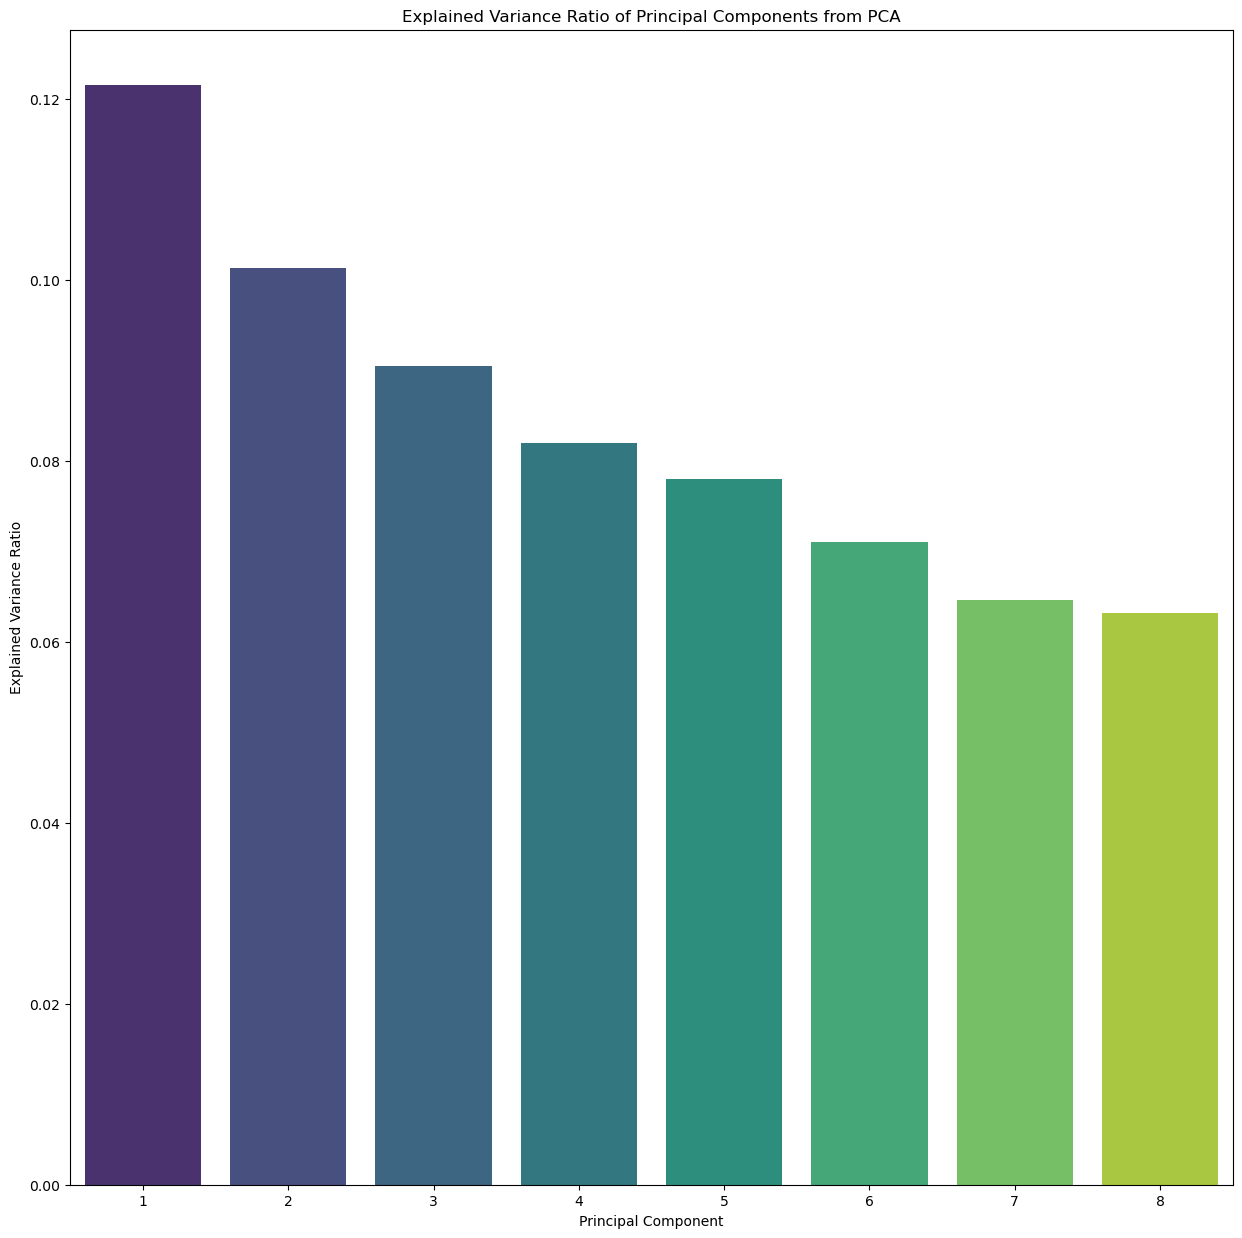

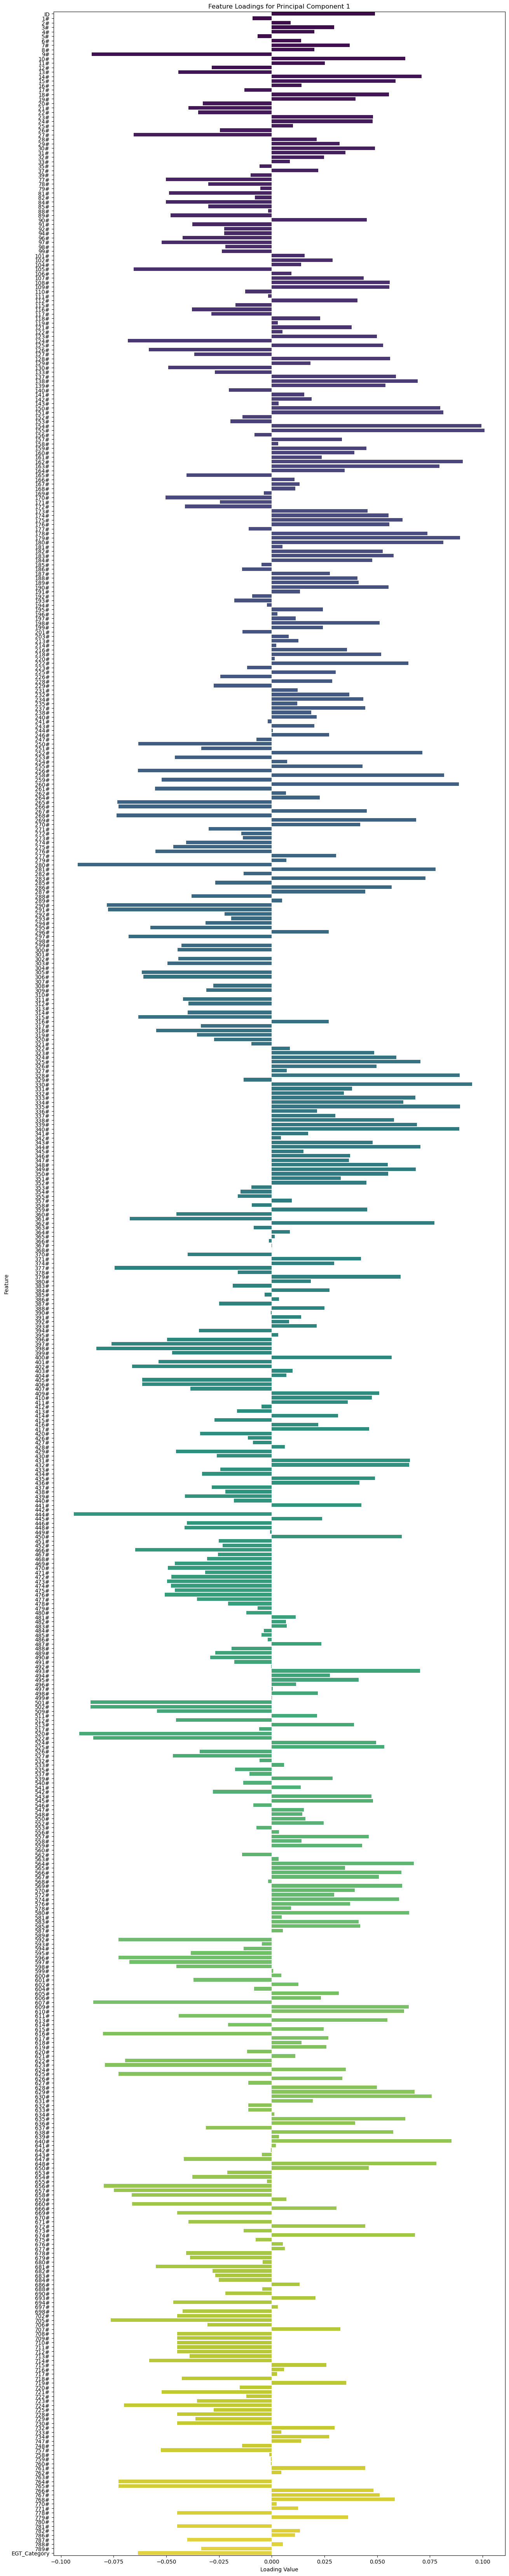

Top features for each principal component above the threshold:
PC1: ['155#', '154#', '330#', '444#', '280#', '520#', '162#', '179#', '335#', '328#']
PC2: ['497#', '496#', '499#', '477#', '321#', '482#', '481#', '550#', '486#', '489#']
PC3: ['346#', '347#', '734#', '13#', '702#', '708#', '709#', '781#', '710#', '778#']
PC4: ['97#', '426#', '439#', '627#', '633#', '420#', '484#', '119#', '658#', '693#']
PC5: ['79#', '288#', '323#', '140#', '636#', '143#', '526#', '164#', '394#', '309#']
PC6: ['632#', '292#', '94#', '92#', '169#', '370#', '371#', '593#', '334#', '789#']
PC7: ['594#', '650#', '624#', '240#', '228#', '20#', '367#', '368#', '193#', '451#']
PC8: ['345#', '748#', '747#', '186#', '104#', '562#', '391#', '152#', '329#', '517#']


In [72]:
target = "EGT"

y = standardized_data[target]
X = standardized_data.drop(columns=[target])

random_seed = 49

# Initialize PCA
n_components = min(len(X.columns), len(X))  # You can set the number of components as needed
pca = PCA(n_components=n_components, random_state=random_seed)

# Fit PCA model
pca.fit(X)

# Transform the data
X_pca = pca.transform(X)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a DataFrame to display explained variance ratio for each principal component
pca_df = pd.DataFrame({'Principal Component': range(1, n_components + 1),
                       'Explained Variance Ratio': explained_variance_ratio})

# Filter principal components by explained variance ratio threshold
threshold = 0.06
filtered_pca_df = pca_df[pca_df['Explained Variance Ratio'] > threshold]

# Sort the DataFrame by explained variance ratio
sorted_pca_df = filtered_pca_df.sort_values(by='Explained Variance Ratio', ascending=False)

plt.figure(figsize=(15, 15))
sns.barplot(y='Explained Variance Ratio', x='Principal Component', data=sorted_pca_df, palette='viridis')
plt.title('Explained Variance Ratio of Principal Components from PCA')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.show()

# Get the principal components
principal_components = pca.components_

# Create a DataFrame for feature loadings
loadings_df = pd.DataFrame(principal_components.T, columns=[f'PC{i+1}' for i in range(n_components)], index=X.columns)

# Plotting the feature loadings for the first principal component (PC1)
plt.figure(figsize=(15, 85))
sns.barplot(x=loadings_df['PC1'].values, y=loadings_df.index, palette='viridis')
plt.title('Feature Loadings for Principal Component 1')
plt.xlabel('Loading Value')
plt.ylabel('Feature')
plt.show()

# Identify the most influential features for each principal component above the threshold
top_features = {}
for pc in sorted_pca_df['Principal Component']:
    pc_name = f'PC{pc}'
    top_features[pc_name] = loadings_df[pc_name].abs().sort_values(ascending=False).head(10).index.tolist()

print("Top features for each principal component above the threshold:")
for pc, features in top_features.items():
    print(f"{pc}: {features}")


In [73]:
text = """
Top features for each principal component above the threshold:
PC1: ['155#', '154#', '330#', '444#', '280#', '520#', '162#', '179#', '335#', '328#']
PC2: ['497#', '496#', '499#', '477#', '321#', '482#', '481#', '550#', '486#', '489#']
PC3: ['346#', '347#', '734#', '13#', '702#', '708#', '709#', '781#', '710#', '778#']
PC4: ['97#', '426#', '439#', '627#', '633#', '420#', '484#', '119#', '658#', '693#']
PC5: ['79#', '288#', '323#', '140#', '636#', '143#', '526#', '164#', '394#', '309#']
PC6: ['632#', '292#', '94#', '92#', '169#', '370#', '371#', '593#', '334#', '789#']
PC7: ['594#', '650#', '624#', '240#', '228#', '20#', '367#', '368#', '193#', '451#']
PC8: ['345#', '748#', '747#', '186#', '104#', '562#', '391#', '152#', '329#', '517#']
"""

# Extract numbers from the text
numbers = re.findall(r'\d+#', text)

# Count occurrences of each number
count = Counter(numbers)

# Get all the keys from the dictionary
unique_numbers = list(count.keys())


In [74]:
pca_standardized_data=standardized_data[unique_numbers]
pca_standardized_data['EGT']=standardized_data['EGT']
pca_standardized_data

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\3088451810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_standardized_data['EGT']=standardized_data['EGT']


155#      154#      330#      444#      280#      520#      162#  \
0  -1.042834 -0.839149 -1.142122  1.096701  2.277770  0.144171 -0.240452   
1  -0.547720 -0.584861  0.269956  0.813682  1.843909  0.720854 -0.166467   
2   0.343485  0.432289  0.768336  0.530662 -0.759257  0.336399 -0.425416   
3  -0.003094  0.076286 -0.809868 -0.884436 -0.325396 -0.048057  0.277445   
4   0.888111  0.890006 -0.643741 -0.318397 -0.325396 -0.048057 -0.055489   
5   0.244463 -0.025429  0.685273  0.530662  0.108465 -0.048057 -0.018496   
6   0.789088  0.584861  0.768336  0.813682 -0.325396  0.528626  0.721357   
7  -0.646743 -0.686576 -0.975995 -0.035377 -0.325396  0.528626  0.055489   
8  -1.042834 -1.042579 -0.643741  1.379721  1.843909  0.528626 -2.570990   
9  -2.033062 -2.059729 -1.474375  0.530662 -0.325396  0.720854 -1.831137   
10  0.392997  0.381431 -0.809868 -0.035377 -0.759257 -0.048057  0.684364   
11  0.987134  1.195151  0.768336 -0.884436 -0.325396 -0.048057  0.351430   
12 -1.488437 -1.500296 -0.560678  0.247642 -0.325396  0.720854  0.314438   
13  1.680293  1.652869  2.263477 -2.865574 -1.193118 -3.315928  2.016100   
14  0.987134  0.991721  1.266717 -0.884436 -0.759257 -1.393651  0.536394   
15  0.492020  0.534004  0.269956 -0.035377 -0.325396  0.720854  0.351430   

        179#      335#      328#  ...      748#      747#      186#      104#  \
0  -0.868437 -0.414214 -0.827269  ...  0.258199 -0.258199  0.258199 -0.258199   
1  -1.237984  0.095588 -0.329663  ...  0.258199 -0.258199  0.258199 -0.258199   
2   0.388025  0.860292  1.362194  ...  0.258199 -0.258199  0.258199 -0.258199   
3   0.461934 -1.306369 -1.026311  ...  0.258199 -0.258199  0.258199 -0.258199   
4   0.388025  0.095588 -0.628227  ...  0.258199 -0.258199  0.258199 -0.258199   
5   0.388025  0.605390  0.466505  ...  0.258199 -0.258199  0.258199 -0.258199   
6   1.127120  1.242643  1.163152  ...  0.258199 -0.258199  0.258199 -0.258199   
7   1.127120 -1.688720 -1.424395  ...  0.258199 -0.258199  0.258199 -0.258199   
8  -1.385803 -1.306369 -0.429184  ...  0.258199 -0.258199  0.258199 -0.258199   
9  -1.681441 -0.924017 -1.523916  ...  0.258199 -0.258199  0.258199 -0.258199   
10  0.314115  0.223039  0.167942  ...  0.258199 -0.258199  0.258199 -0.258199   
11  0.388025  1.115193  0.964110  ...  0.258199 -0.258199  0.258199 -0.258199   
12 -1.755351 -1.051467 -0.528706  ...  0.258199 -0.258199  0.258199 -0.258199   
13  0.979301  1.624995  1.760278  ...  0.258199 -0.258199  0.258199 -0.258199   
14  0.166296  0.987742  1.163152  ...  0.258199 -0.258199  0.258199 -0.258199   
15  1.201029 -0.159313 -0.329663  ... -3.872983  3.872983 -3.872983  3.872983   

        562#      391#      152#      329#      517#       EGT  
0   0.258199 -0.258136  0.257783  0.242852  0.316972 -1.106777  
1   0.258199 -0.258383  0.258237  0.269155  0.316972  0.566461  
2   0.258199 -0.258053  0.258609  0.275871  0.316972 -0.270158  
3   0.258199 -0.258259  0.257824  0.246769  0.713186  2.100263  
4   0.258199 -0.257846  0.257576  0.256283  0.713186 -0.270158  
5   0.258199 -0.258012  0.258196  0.270274  0.237729  0.287588  
6   0.258199 -0.258177  0.258650  0.262439  0.316972  0.566461  
7   0.258199 -0.258012  0.257411  0.254604 -0.079243  0.287588  
8   0.258199 -0.258425  0.258237  0.250687  0.316972  1.542517  
9   0.258199 -0.258012  0.257370  0.249567  0.316972  0.705897  
10  0.258199 -0.258094  0.258155  0.249008  0.237729 -0.688468  
11  0.258199 -0.258301  0.258692  0.260760  0.237729  0.845334  
12  0.258199 -0.258053  0.257824  0.247889 -0.871672 -0.967341  
13  0.258199 -0.259168  0.259890  0.274752  0.237729 -1.385651  
14  0.258199 -0.258053  0.258527  0.261880  0.316972 -0.967341  
15 -3.872983  3.872983 -3.872983 -3.872790 -3.645173 -1.246214  

[16 rows x 81 columns]

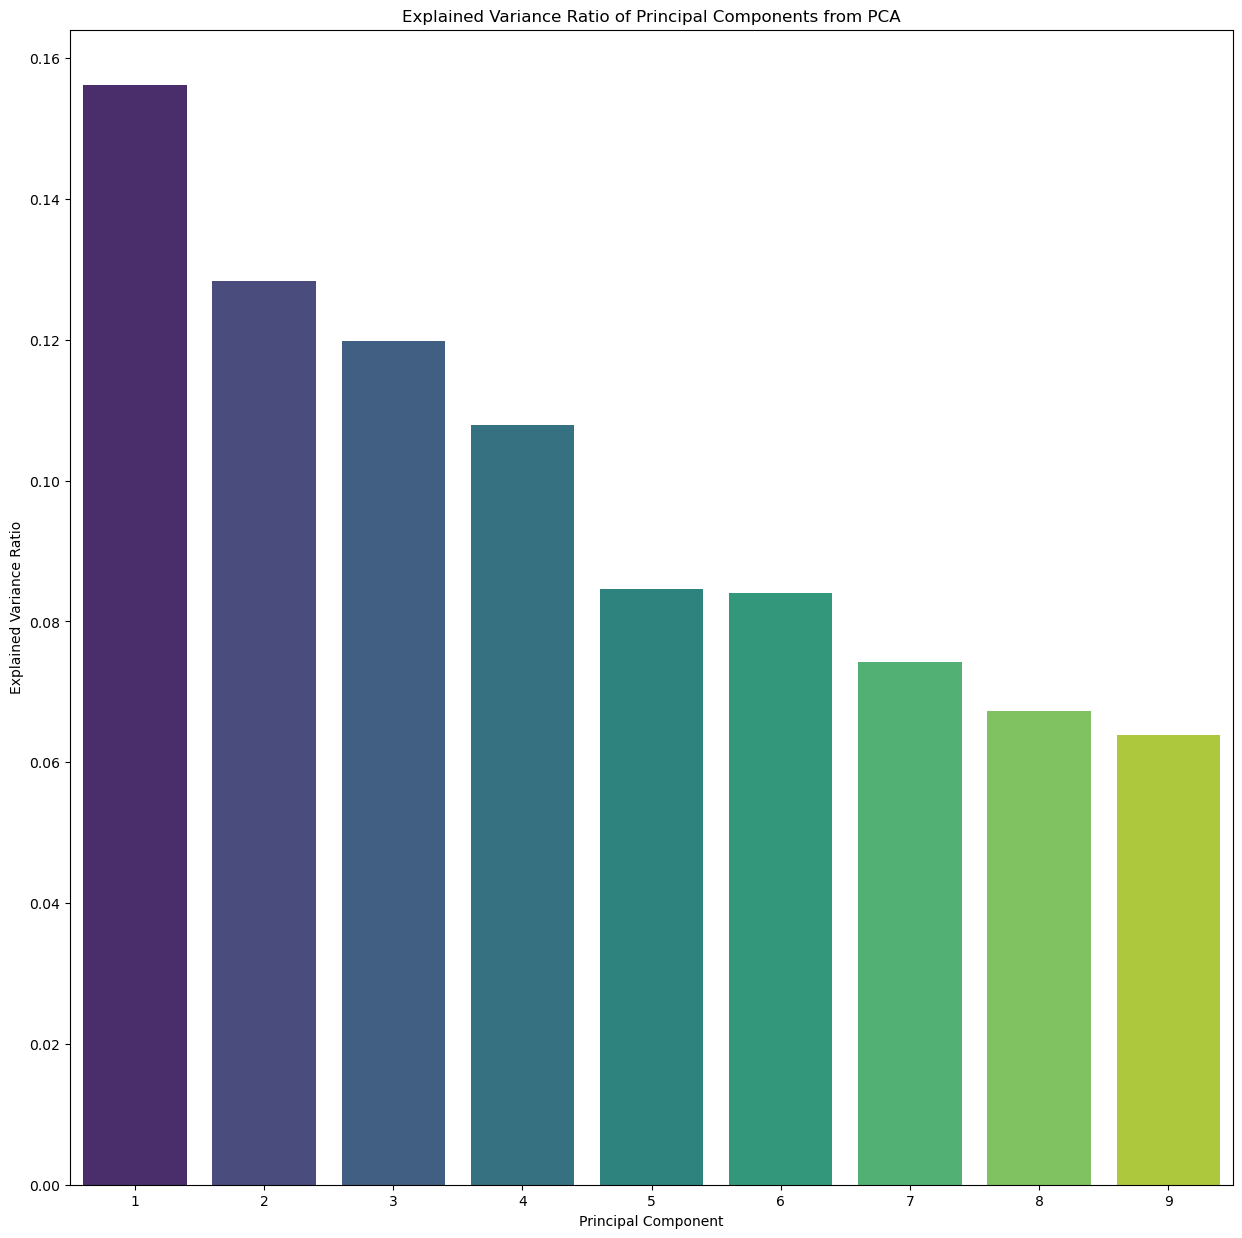

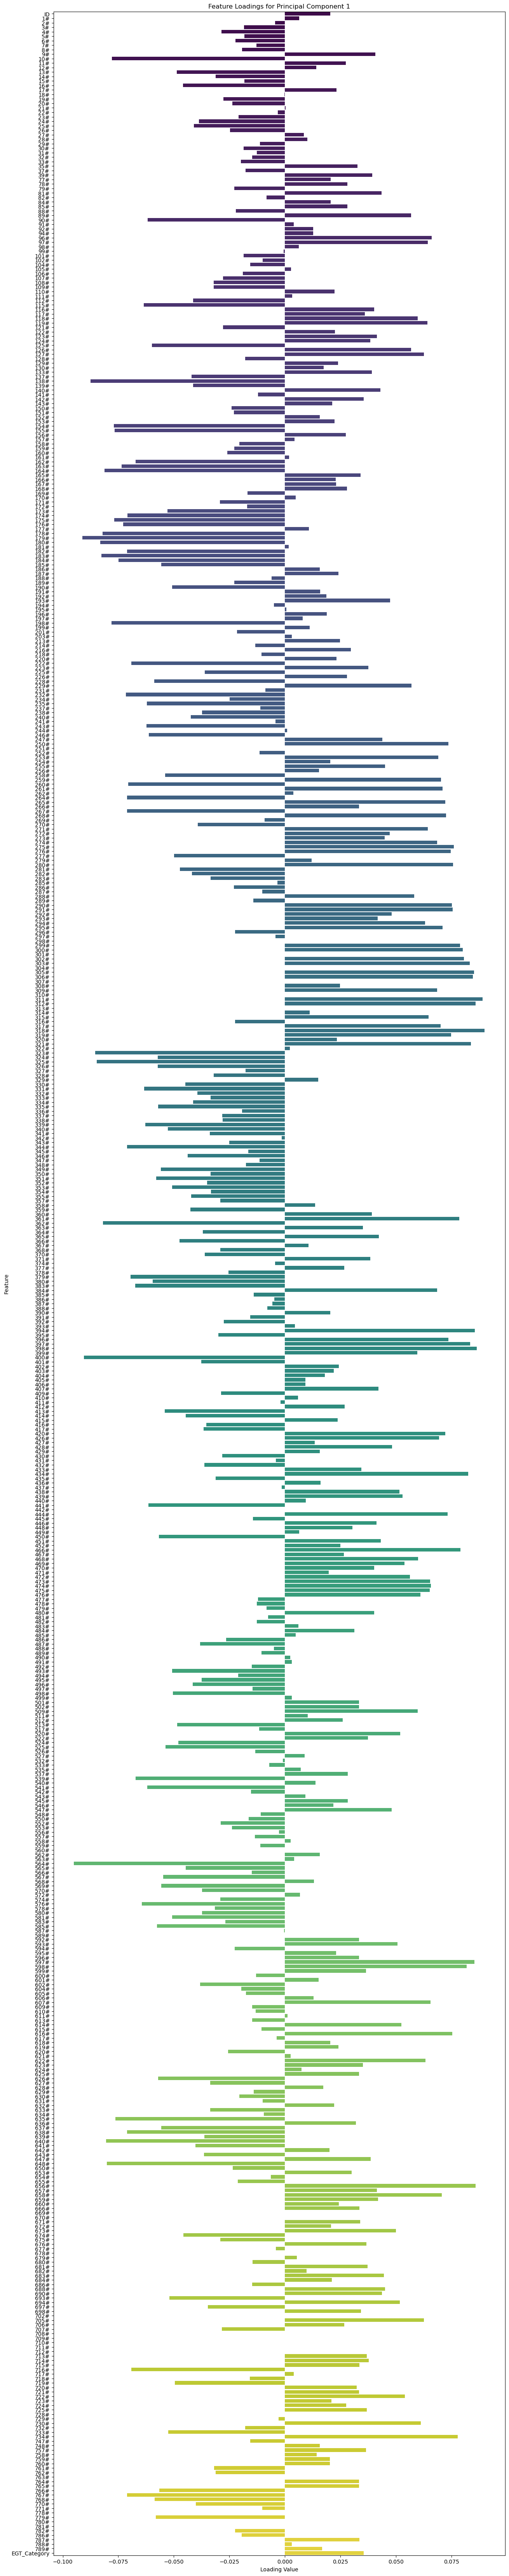

Top features for each principal component above the threshold:
PC1: ['564#', '179#', '400#', '318#', '311#', '138#', '398#', '656#', '312#', '394#']
PC2: ['572#', '99#', '26#', '240#', '22#', '98#', '677#', '192#', '241#', '782#']
PC3: ['365#', '366#', '715#', '477#', '123#', '623#', '165#', '718#', '409#', '269#']
PC4: ['471#', '197#', '631#', '671#', '437#', '158#', '620#', '472#', '440#', '172#']
PC5: ['156#', '392#', '697#', '698#', '262#', '678#', '771#', '417#', '279#', '634#']
PC6: ['601#', '378#', '605#', '231#', '370#', '643#', '641#', '371#', '600#', '639#']
PC7: ['347#', '559#', '30#', '480#', '367#', '714#', '729#', '542#', '492#', '657#']
PC8: ['393#', '1#', '24#', '6#', '5#', '410#', '690#', '4#', '415#', '8#']
PC9: ['130#', '673#', '452#', '517#', '9#', '286#', '289#', '226#', '332#', '191#']


In [75]:
target = "EGT"

y = standardized_data_smote[target]
X = standardized_data_smote.drop(columns=[target])

random_seed = 49

# Initialize PCA
n_components = min(len(X.columns), len(X))  # You can set the number of components as needed
pca = PCA(n_components=n_components, random_state=random_seed)

# Fit PCA model
pca.fit(X)

# Transform the data
X_pca = pca.transform(X)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a DataFrame to display explained variance ratio for each principal component
pca_df = pd.DataFrame({'Principal Component': range(1, n_components + 1),
                       'Explained Variance Ratio': explained_variance_ratio})

# Filter principal components by explained variance ratio threshold
threshold = 0.06
filtered_pca_df = pca_df[pca_df['Explained Variance Ratio'] > threshold]

# Sort the DataFrame by explained variance ratio
sorted_pca_df = filtered_pca_df.sort_values(by='Explained Variance Ratio', ascending=False)

plt.figure(figsize=(15, 15))
sns.barplot(y='Explained Variance Ratio', x='Principal Component', data=sorted_pca_df, palette='viridis')
plt.title('Explained Variance Ratio of Principal Components from PCA')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.show()

# Get the principal components
principal_components = pca.components_

# Create a DataFrame for feature loadings
loadings_df = pd.DataFrame(principal_components.T, columns=[f'PC{i+1}' for i in range(n_components)], index=X.columns)

# Plotting the feature loadings for the first principal component (PC1)
plt.figure(figsize=(15, 85))
sns.barplot(x=loadings_df['PC1'].values, y=loadings_df.index, palette='viridis')
plt.title('Feature Loadings for Principal Component 1')
plt.xlabel('Loading Value')
plt.ylabel('Feature')
plt.show()

# Identify the most influential features for each principal component above the threshold
top_features = {}
for pc in sorted_pca_df['Principal Component']:
    pc_name = f'PC{pc}'
    top_features[pc_name] = loadings_df[pc_name].abs().sort_values(ascending=False).head(10).index.tolist()

print("Top features for each principal component above the threshold:")
for pc, features in top_features.items():
    print(f"{pc}: {features}")

In [76]:
text = """
Top features for each principal component above the threshold:
PC1: ['564#', '179#', '400#', '318#', '311#', '138#', '398#', '656#', '312#', '394#']
PC2: ['572#', '99#', '26#', '240#', '22#', '98#', '677#', '192#', '241#', '782#']
PC3: ['365#', '366#', '715#', '477#', '123#', '623#', '165#', '718#', '409#', '269#']
PC4: ['471#', '197#', '631#', '671#', '437#', '158#', '620#', '472#', '440#', '172#']
PC5: ['156#', '392#', '697#', '698#', '262#', '678#', '771#', '417#', '279#', '634#']
PC6: ['601#', '378#', '605#', '231#', '370#', '643#', '641#', '371#', '600#', '639#']
PC7: ['347#', '559#', '30#', '480#', '367#', '714#', '729#', '542#', '492#', '657#']
PC8: ['393#', '1#', '24#', '6#', '5#', '410#', '690#', '4#', '415#', '8#']
PC9: ['130#', '673#', '452#', '517#', '9#', '286#', '289#', '226#', '332#', '191#']
"""

# Extract numbers from the text
numbers = re.findall(r'\d+#', text)

# Count occurrences of each number
count = Counter(numbers)

# Get all the keys from the dictionary
unique_numbers = list(count.keys())

In [77]:
pca_standardized_data_smote=standardized_data_smote[unique_numbers]
pca_standardized_data_smote['EGT']=standardized_data_smote['EGT']
pca_standardized_data_smote

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\749463063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_standardized_data_smote['EGT']=standardized_data_smote['EGT']


564#      179#      400#      318#      311#      138#      398#  \
0   1.810014  1.106196  2.390594 -0.615458 -0.350735  0.728808 -0.520565   
1   0.968435  0.547677 -0.210742 -0.615458  0.182386  0.728808 -0.617161   
2  -1.556300 -1.127880 -1.771544  0.926898  2.314868 -1.519170  0.880079   
3   0.547646 -1.407140  0.309525 -0.615458 -0.883855  0.728808  1.121570   
4   1.810014  0.547677  0.829792 -0.615458 -0.883855  1.178404 -1.293334   
5   0.575700  1.315641 -0.210742 -0.615458 -0.350735  0.728808 -1.196738   
6   0.547646  0.547677  0.309525 -0.615458 -1.416976  0.728808 -0.906949   
7   0.126857  1.245826  0.309525 -0.615458 -0.350735  0.728808 -1.293334   
8  -0.714722  0.477862 -0.210742 -0.615458 -0.883855  0.728808  0.638589   
9  -1.556300 -1.476955 -1.251277  2.469254  1.248627 -1.519170  1.507954   
10  0.126857  0.617492  1.350059 -0.615458 -0.350735  0.728808 -0.617161   
11  0.968435  1.245826  1.350059 -0.615458 -0.350735 -1.519170 -1.003545   
12 -1.275458 -0.824616 -0.904042  1.439859  0.536999 -0.769000  1.217840   
13  0.186973  1.146084  0.309525 -0.615458 -0.503065  0.728808 -1.238132   
14 -0.821788 -1.452582 -0.706383  1.392345  0.504153 -0.734375  1.373063   
15  0.031907  0.519033  1.173965 -0.528452 -0.200364  0.601996 -0.532699   
16  0.266556  0.585933  0.482250 -0.186682  0.390306 -1.519170 -0.479895   
17  0.942579  0.547677 -0.178773 -0.615458  0.084109  0.728808 -0.634968   
18 -1.555645 -1.475433 -1.250467  2.466851  1.246966 -1.517419  1.507277   
19 -1.530082 -1.114830 -1.751284  0.914885  2.289955 -1.498160  0.863152   
20 -0.751502 -0.486949 -0.975497  0.336918  0.887369 -0.659277  0.196508   
21 -0.224485 -0.254173 -0.008698 -0.615458 -0.883855  0.728808  0.826153   
22  0.538726 -1.393820  0.305848 -0.615458 -0.883855  0.728808  1.118157   
23  0.537941  0.563778  0.309525 -0.615458 -1.392386  0.728808 -0.915860   

        656#      312#      394#  ...      673#      452#      517#        9#  \
0  -1.867630 -0.525748 -1.299132  ... -0.225798 -0.576439  0.253990 -1.738508   
1  -1.185235  0.562931  0.011084  ...  0.947358 -0.210385  0.253990  0.322243   
2   1.544347  2.195949  1.976408  ...  0.947358  0.277687  0.344294  1.261703   
3   0.861951 -0.525748  1.499966  ...  0.947358  1.619885  0.344294 -0.268707   
4  -1.867630 -1.070087 -0.524914  ... -1.398955 -1.674602  0.344294 -0.541454   
5  -1.185235  0.018591 -0.524914  ...  0.947358  0.277687 -4.170944 -2.677968   
6  -0.844037 -1.614427 -0.346248  ... -1.398955 -1.552584  0.795818  0.594990   
7   0.520754 -0.525748 -1.001356  ...  0.947358  1.497867 -0.107230  0.049497   
8   0.179556 -1.070087 -1.001356  ... -1.398955 -2.162674  0.253990  0.640447   
9   0.861951  1.107270  0.427971  ...  0.947358  0.277687 -1.010277  0.064649   
10  0.179556 -0.525748 -1.418243  ... -1.398955  0.155669  0.795818  0.973804   
11 -1.185235  0.018591 -0.882246  ... -1.398955  0.765759  0.344294 -2.102170   
12  0.634230  0.380667 -0.049008  ...  0.164374 -0.536683 -0.588381  0.256798   
13  0.325770 -0.681284 -0.907763  ...  0.612148  1.062059  0.021786  0.127430   
14  0.861951  0.537165  0.802216  ...  0.947358  0.746264 -0.537381 -0.051729   
15  0.256546 -0.372213 -1.226745  ... -1.266596  0.162552  0.770347  0.990045   
16 -0.426408  0.623900 -0.087536  ... -0.746677  0.630074  0.344294 -1.167009   
17 -1.164269  0.429138 -0.010873  ...  0.803184 -0.292860  0.287283  0.339003   
18  0.861420  1.105575  0.426857  ...  0.945531  0.275786 -1.009293  0.065098   
19  1.517773  2.170512  1.956926  ...  0.929084  0.262482  0.344294  1.247659   
20  0.630746  0.738410  1.087949  ...  0.049850 -0.422425  0.517011  1.006673   
21  0.444562 -0.858695 -0.029976  ... -0.487771 -0.693729  0.289059  0.287380   
22  0.857129 -0.529594  1.482290  ...  0.930779  1.593156  0.343656 -0.262283   
23 -0.812562 -1.589319 -0.361356  ... -1.344843 -1.482233  0.774992  0.582409   

        286#      289#      226#      332#      191#       EGT  
0  -0.043467  1.

### Models

In [78]:
# במשימות רגרסיה, דיוק אינו משמש בדרך כלל כמדד. עם זאת, אם אתה רוצה לחשב צורה של "דיוק", תוכל לשקול להגדיר זאת כאחוז התחזיות שנמצאות בטווח מסוים של הערכים בפועל.

In [79]:
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    accuracy = np.mean(np.abs((y_pred - y_true) / y_true) < 0.1)  # Accuracy within ±10%
    return rmse, r2, accuracy

def train_and_evaluate(X_train, y_train, X_test, y_test):
    # Define the models
    xgb_model = XGBRegressor()
    svm_model = SVR()
    ridge_model = Ridge()
    lasso_model = Lasso()

    # Train models
    xgb_model.fit(X_train, y_train)
    svm_model.fit(X_train, y_train)
    ridge_model.fit(X_train, y_train)
    lasso_model.fit(X_train, y_train)

    # Make predictions
    xgb_pred = xgb_model.predict(X_test)
    svm_pred = svm_model.predict(X_test)
    ridge_pred = ridge_model.predict(X_test)
    lasso_pred = lasso_model.predict(X_test)

    # Define the CLTSM model (example with LSTM)
    cltsm_model = Sequential()
    cltsm_model.add(LSTM(50, input_shape=(X_train.shape[1], 1), return_sequences=True))
    cltsm_model.add(LSTM(50))
    cltsm_model.add(Dense(1))
    cltsm_model.compile(optimizer='adam', loss='mse')

    # Reshape data for LSTM
    X_train_cltsm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
    X_test_cltsm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

    # Train CLTSM model
    cltsm_model.fit(X_train_cltsm, y_train, epochs=50, batch_size=32, verbose=0)

    # Make predictions with CLTSM
    cltsm_pred = cltsm_model.predict(X_test_cltsm).flatten()

    # Calculate metrics for each model
    xgb_metrics = calculate_metrics(y_test, xgb_pred)
    svm_metrics = calculate_metrics(y_test, svm_pred)
    ridge_metrics = calculate_metrics(y_test, ridge_pred)
    lasso_metrics = calculate_metrics(y_test, lasso_pred)
    cltsm_metrics = calculate_metrics(y_test, cltsm_pred)

    return xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics


#### Basic data

In [80]:
target = "EGT"

y = normalized_data[target]
X = normalized_data.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.414417 -2.809943  0.000000
1               SVM  0.341205 -1.566601  0.066667
2  Ridge Regression  0.350594 -1.756385  0.000000
3  Lasso Regression  0.349260 -1.707736  0.066667
4             CLTSM  0.333129 -1.513867  0.066667

In [81]:
target = "EGT"

y = standardized_data[target]
X = standardized_data.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=52)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  1.357648 -1.591111  0.066667
1               SVM  1.061029 -0.345673  0.000000
2  Ridge Regression  1.156208 -0.614467  0.000000
3  Lasso Regression  0.995751 -0.126480  0.000000
4             CLTSM  1.347253 -1.191738  0.066667

#### Basic data Smote

In [82]:
target = "EGT"

y = normalized_data_smote[target]
X = normalized_data_smote.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.247443 -0.259012  0.416667
1               SVM  0.233978  0.059672  0.083333
2  Ridge Regression  0.206792  0.175185  0.583333
3  Lasso Regression  0.303381 -0.580334  0.041667
4             CLTSM  0.277052 -0.307685  0.041667

In [83]:
target = "EGT"

y = standardized_data_smote[target]
X = standardized_data_smote.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.889004 -0.259316  0.083333
1               SVM  0.772308  0.178011  0.125000
2  Ridge Regression  0.734098  0.177379  0.375000
3  Lasso Regression  1.090324 -0.580334  0.000000
4             CLTSM  0.792998  0.204876  0.083333

#### Data with feature selection by person correlation 

In [84]:
target = "EGT"

y = Pearson_correlation_normalized_data[target]
X = Pearson_correlation_normalized_data.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.387885 -2.593266  0.000000
1               SVM  0.242693 -0.362974  0.200000
2  Ridge Regression  0.157880  0.337563  0.266667
3  Lasso Regression  0.349260 -1.707736  0.066667
4             CLTSM  0.222504 -0.080752  0.133333

In [85]:
target = "EGT"

y = Pearson_correlation_normalized_data_somte[target]
X = Pearson_correlation_normalized_data_somte.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.182891  0.414041  0.500000
1               SVM  0.194278  0.345269  0.208333
2  Ridge Regression  0.133246  0.698663  0.250000
3  Lasso Regression  0.303381 -0.580334  0.041667
4             CLTSM  0.211018  0.223247  0.166667

In [86]:
target = "EGT"

y = Pearson_correlation_standardized_data[target]
X = Pearson_correlation_standardized_data.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  1.353972 -2.602326  0.066667
1               SVM  0.900437 -0.534998  0.000000
2  Ridge Regression  0.498677  0.446944  0.200000
3  Lasso Regression  1.217491 -1.707736  0.000000
4             CLTSM  0.592636  0.373933  0.200000

In [87]:
target = "EGT"

y = Pearson_correlation_standardized_data_somte[target]
X = Pearson_correlation_standardized_data_somte.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.656871  0.414845  0.166667
1               SVM  0.712872  0.294644  0.125000
2  Ridge Regression  0.511740  0.661156  0.208333
3  Lasso Regression  1.090324 -0.580334  0.000000
4             CLTSM  0.481179  0.690132  0.208333

#### Data with feature selection by Random forest

In [88]:
target = "EGT"

y = Random_Forest_feature_importance_normalized_data_filtered[target]
X = Random_Forest_feature_importance_normalized_data_filtered.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.428183 -2.964362  0.122222
1               SVM  0.339890 -1.535056  0.000000
2  Ridge Regression  0.313323 -1.174322  0.066667
3  Lasso Regression  0.349260 -1.707736  0.066667
4             CLTSM  0.348244 -1.646967  0.000000

In [89]:
target = "EGT"

y = Random_Forest_feature_importance_normalized_data_smote_filtered[target]
X = Random_Forest_feature_importance_normalized_data_smote_filtered.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.229633 -0.240854  0.375000
1               SVM  0.196132  0.290847  0.333333
2  Ridge Regression  0.153041  0.600283  0.416667
3  Lasso Regression  0.303381 -0.580334  0.041667
4             CLTSM  0.274197 -0.377942  0.125000

In [90]:
target = "EGT"

y = Random_Forest_feature_importance_standardized_data_filtered[target]
X = Random_Forest_feature_importance_standardized_data_filtered.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  1.412095 -2.524726  0.055556
1               SVM  0.947389 -0.705346  0.000000
2  Ridge Regression  1.124142 -1.324904  0.000000
3  Lasso Regression  1.217491 -1.707736  0.000000
4             CLTSM  1.429241 -2.665562  0.133333

In [91]:
target = "EGT"

y = Random_Forest_feature_importance_standardized_data_smote_filtered[target]
X = Random_Forest_feature_importance_standardized_data_smote_filtered.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.839319 -0.161843  0.166667
1               SVM  0.660041  0.363715  0.250000
2  Ridge Regression  0.522332  0.650690  0.375000
3  Lasso Regression  1.090324 -0.580334  0.000000
4             CLTSM  0.927389 -0.130962  0.041667

#### Data with feature selection by select K best mutual information

In [92]:
target = "EGT"

y = SelectKBest_Mutual_Information_normalized_data_filtered[target]
X = SelectKBest_Mutual_Information_normalized_data_filtered.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.358842 -1.789440  0.122222
1               SVM  0.311864 -1.211782  0.188889
2  Ridge Regression  0.274513 -0.806351  0.188889
3  Lasso Regression  0.349260 -1.707736  0.066667
4             CLTSM  0.308937 -1.133421  0.133333

In [93]:
target = "EGT"

y = SelectKBest_Mutual_Information_normalized_data_smote_filtered[target]
X = SelectKBest_Mutual_Information_normalized_data_smote_filtered.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.211945  0.120440  0.416667
1               SVM  0.205950  0.250054  0.166667
2  Ridge Regression  0.155746  0.554086  0.416667
3  Lasso Regression  0.303381 -0.580334  0.041667
4             CLTSM  0.283614 -0.445067  0.083333

In [94]:
target = "EGT"

y = SelectKBest_Mutual_Information_standardized_data_filtered[target]
X =SelectKBest_Mutual_Information_standardized_data_filtered.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  1.081636 -1.426973  0.066667
1               SVM  1.148350 -1.470560  0.000000
2  Ridge Regression  1.032786 -1.299622  0.000000
3  Lasso Regression  1.217491 -1.707736  0.000000
4             CLTSM  0.982182 -0.970122  0.066667

In [95]:
target = "EGT"

y = SelectKBest_Mutual_Information_standardized_data_smote_filtered[target]
X = SelectKBest_Mutual_Information_standardized_data_smote_filtered.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.831244 -0.050665  0.125000
1               SVM  0.693268  0.323489  0.250000
2  Ridge Regression  0.597386  0.425252  0.333333
3  Lasso Regression  1.090324 -0.580334  0.000000
4             CLTSM  1.297747 -1.700664  0.041667

#### Data with feature selection by select K best F regression

In [96]:
target = "EGT"

y = SelectKBest_f_regression_normalized_data_filtered[target]
X = SelectKBest_f_regression_normalized_data_filtered.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.389946 -2.784861  0.000000
1               SVM  0.259573 -0.558755  0.255556
2  Ridge Regression  0.165030  0.279530  0.200000
3  Lasso Regression  0.349260 -1.707736  0.066667
4             CLTSM  0.314510 -1.360480  0.066667

In [97]:
target = "EGT"

y = SelectKBest_f_regression_normalized_data_smote_filtered[target]
X = SelectKBest_f_regression_normalized_data_smote_filtered.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.181312  0.434418  0.375000
1               SVM  0.192710  0.360257  0.291667
2  Ridge Regression  0.144532  0.656881  0.250000
3  Lasso Regression  0.303381 -0.580334  0.041667
4             CLTSM  0.205001  0.254995  0.125000

In [98]:
target = "EGT"

y = SelectKBest_f_regression_standardized_data_filtered[target]
X = SelectKBest_f_regression_standardized_data_filtered.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  1.371092 -2.858081  0.000000
1               SVM  0.940610 -0.676460  0.000000
2  Ridge Regression  0.527009  0.374166  0.133333
3  Lasso Regression  1.217491 -1.707736  0.000000
4             CLTSM  0.865013 -0.425264  0.066667

In [99]:
target = "EGT"

y = SelectKBest_f_regression_standardized_data_smote_filtered[target]
X = SelectKBest_f_regression_standardized_data_smote_filtered.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.652897  0.431394  0.208333
1               SVM  0.721327  0.280458  0.125000
2  Ridge Regression  0.607736  0.530232  0.208333
3  Lasso Regression  1.090324 -0.580334  0.000000
4             CLTSM  0.374530  0.814934  0.125000

#### Data with feature selection by PCA

In [100]:
target = "EGT"

y = pca_normalized_data[target]
X = pca_normalized_data.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.490650 -4.202212  0.000000
1               SVM  0.341056 -1.554599  0.055556
2  Ridge Regression  0.328271 -1.476997  0.066667
3  Lasso Regression  0.349260 -1.707736  0.066667
4             CLTSM  0.329424 -1.450378  0.000000

In [101]:
target = "EGT"

y = pca_normalized_data_smote[target]
X = pca_normalized_data_smote.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.241151 -0.056945  0.333333
1               SVM  0.232975  0.091981  0.125000
2  Ridge Regression  0.177430  0.481137  0.458333
3  Lasso Regression  0.303381 -0.580334  0.041667
4             CLTSM  0.272714 -0.277928  0.125000

In [102]:
target = "EGT"

y = pca_standardized_data[target]
X = pca_standardized_data.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  1.417369 -2.820140  0.000000
1               SVM  1.223252 -1.757795  0.066667
2  Ridge Regression  1.460158 -2.973537  0.000000
3  Lasso Regression  1.217491 -1.707736  0.000000
4             CLTSM  1.699522 -4.890445  0.000000

In [103]:
target = "EGT"

y = pca_standardized_data_smote[target]
X = pca_standardized_data_smote.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.960594 -0.483729  0.166667
1               SVM  0.726308  0.257394  0.125000
2  Ridge Regression  0.625264  0.438837  0.333333
3  Lasso Regression  1.090324 -0.580334  0.000000
4             CLTSM  0.629207  0.409041  0.083333

### Attempt to improve results

in all models, the best results were obtained in normalized data with Smote model for Class Imbalance

Two-thirds of the results indicated that the best model is ridge regression.

The selection of features that produced the three best results: Pearson correlation, random forest importamce, seleckKbest f regression

We will examine whether changing the threshold value for selecting the features improves the model

#### Pearson correlation normalized data smote

In [104]:
corr_matrix = normalized_data_smote.corr()

In [105]:
column_name = 'EGT'

# List to store indices of rows where the value in the specified column is greater than 0.4 or less than -0.4
indices_above_0_5_or_below_neg_0_5 = []

# Iterate over the rows and check the value in the specified column
for idx, value in corr_matrix[column_name].items():
    if value > 0.5 or value < -0.5:
        indices_above_0_5_or_below_neg_0_5.append(idx)
        
print(len(indices_above_0_5_or_below_neg_0_5))


43


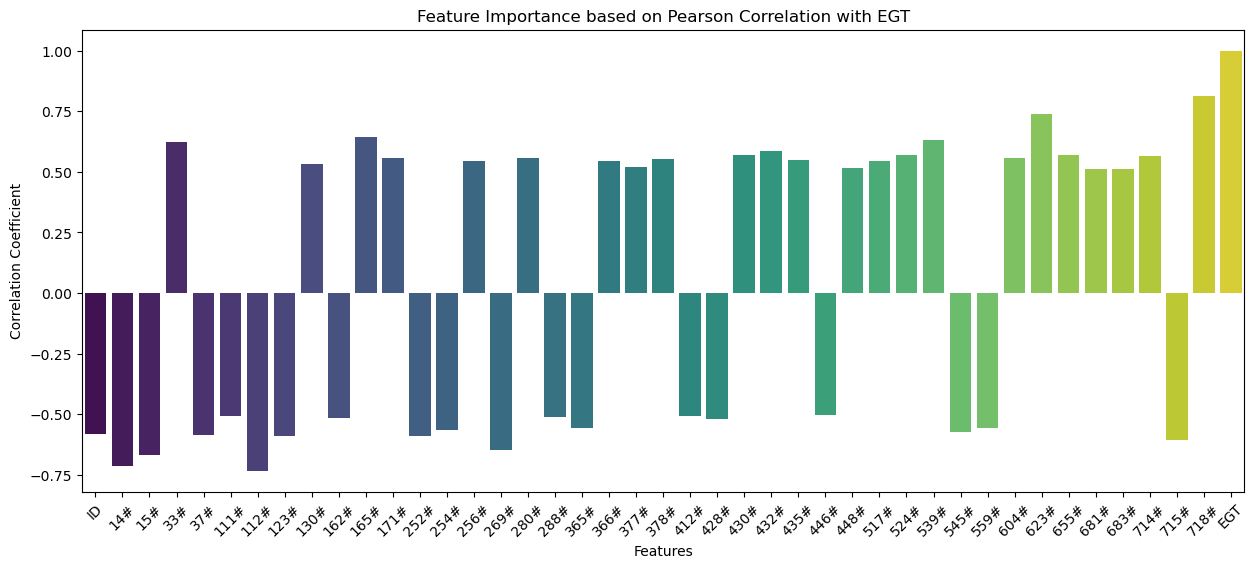

In [106]:
# Extract the correlation values for the selected features
important_features = corr_matrix.loc[indices_above_0_5_or_below_neg_0_5, column_name]

# Create a bar plot for feature importance
plt.figure(figsize=(15, 6))
sns.barplot(x=important_features.index, y=important_features.values, palette="viridis")
plt.title('Feature Importance based on Pearson Correlation with EGT')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

In [107]:
column_name = 'EGT'

# List to store indices of rows where the value in the specified column is greater than 0.4 or less than -0.4
indices_above_0_6_or_below_neg_0_6 = []

# Iterate over the rows and check the value in the specified column
for idx, value in corr_matrix[column_name].items():
    if value > 0.6 or value < -0.6:
        indices_above_0_6_or_below_neg_0_6.append(idx)
        
print(len(indices_above_0_6_or_below_neg_0_6))


11


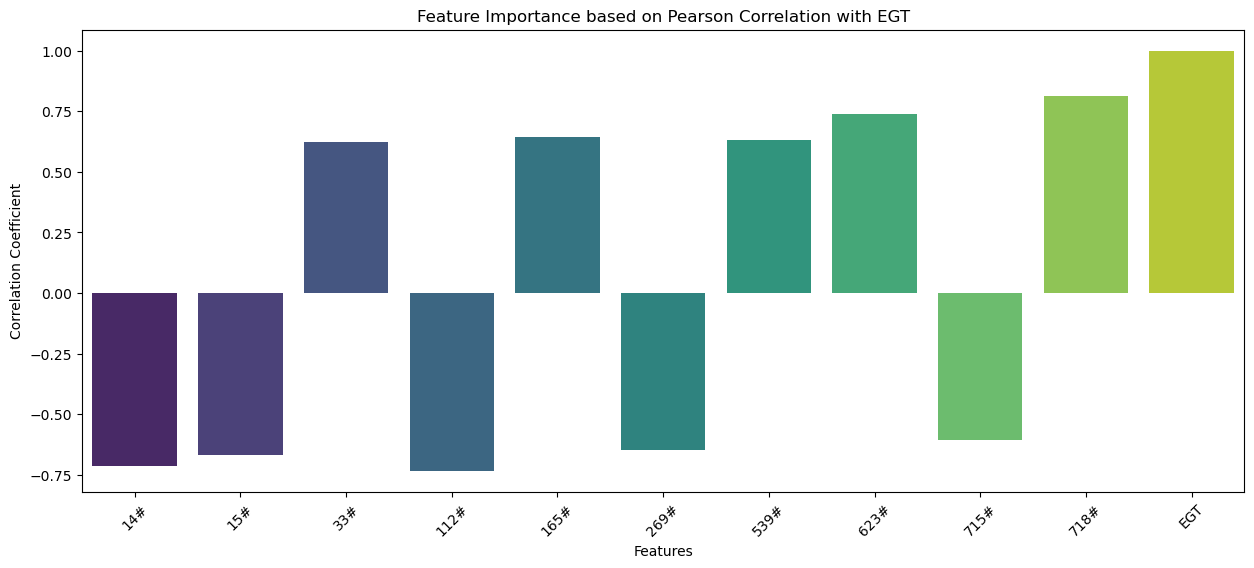

In [108]:
# Extract the correlation values for the selected features
important_features = corr_matrix.loc[indices_above_0_6_or_below_neg_0_6, column_name]

# Create a bar plot for feature importance
plt.figure(figsize=(15, 6))
sns.barplot(x=important_features.index, y=important_features.values, palette="viridis")
plt.title('Feature Importance based on Pearson Correlation with EGT')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

Too sharp

In [109]:
column_name = 'EGT'

# List to store indices of rows where the value in the specified column is greater than 0.4 or less than -0.4
indices_above_0_55_or_below_neg_0_55 = []

# Iterate over the rows and check the value in the specified column
for idx, value in corr_matrix[column_name].items():
    if value > 0.55 or value < -0.55:
        indices_above_0_55_or_below_neg_0_55.append(idx)
        
print(len(indices_above_0_55_or_below_neg_0_55))


28


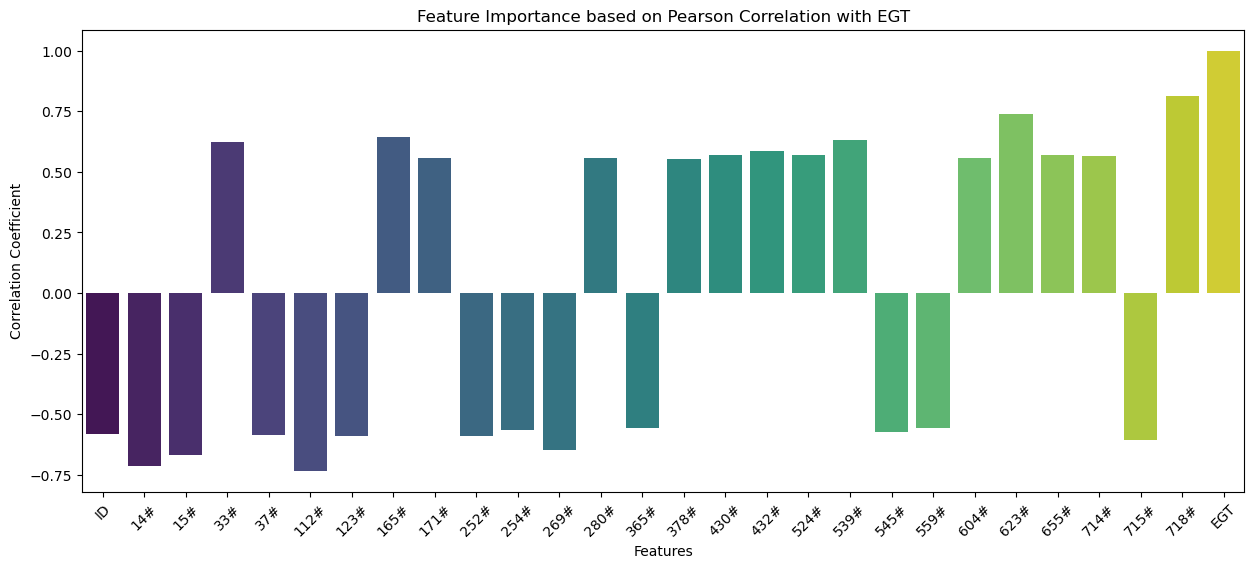

In [110]:
# Extract the correlation values for the selected features
important_features = corr_matrix.loc[indices_above_0_55_or_below_neg_0_55, column_name]

# Create a bar plot for feature importance
plt.figure(figsize=(15, 6))
sns.barplot(x=important_features.index, y=important_features.values, palette="viridis")
plt.title('Feature Importance based on Pearson Correlation with EGT')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

In [111]:
Pearson_correlation_normalized_data_somte = normalized_data_smote[indices_above_0_55_or_below_neg_0_55]

In [112]:
target = "EGT"

y = Pearson_correlation_normalized_data_somte[target]
X = Pearson_correlation_normalized_data_somte.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.186248  0.393678  0.500000
1               SVM  0.190479  0.374485  0.291667
2  Ridge Regression  0.148181  0.639589  0.250000
3  Lasso Regression  0.303381 -0.580334  0.041667
4             CLTSM  0.209005  0.242214  0.125000

Doesn't improve the metrics

In [113]:
column_name = 'EGT'

# List to store indices of rows where the value in the specified column is greater than 0.4 or less than -0.4
indices_above_0_45_or_below_neg_0_45 = []

# Iterate over the rows and check the value in the specified column
for idx, value in corr_matrix[column_name].items():
    if value > 0.45 or value < -0.45:
        indices_above_0_45_or_below_neg_0_45.append(idx)
        
print(len(indices_above_0_45_or_below_neg_0_45))


70


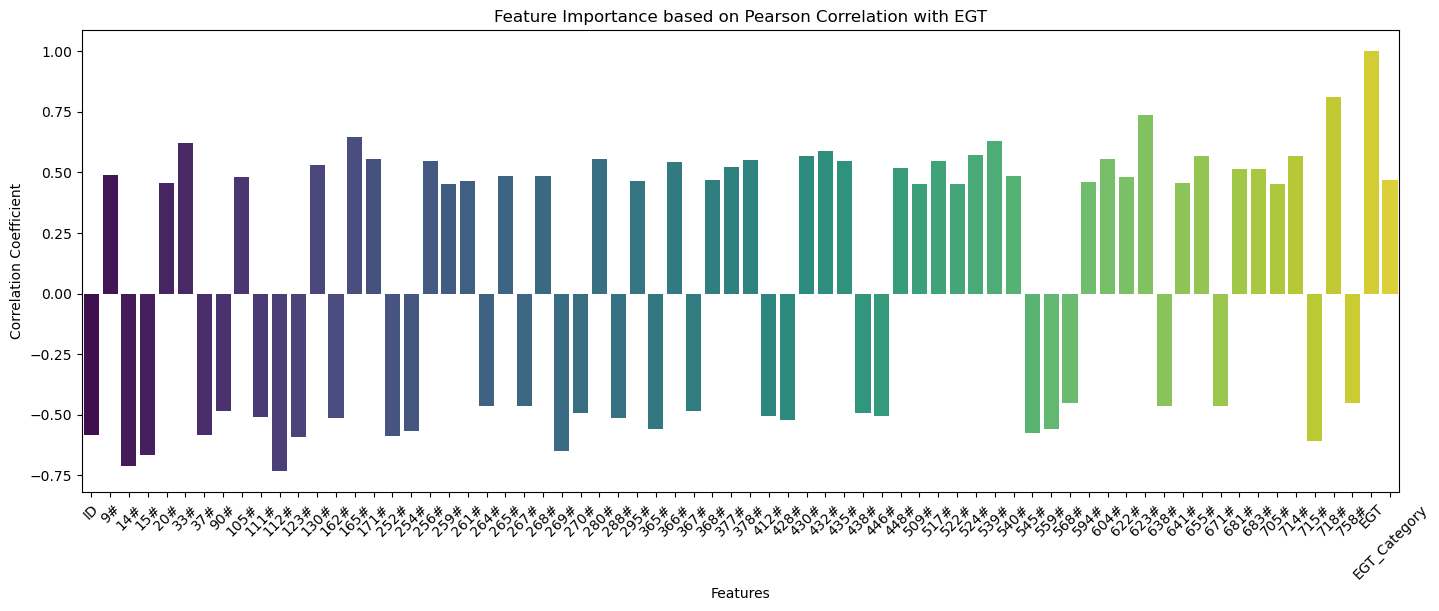

In [114]:
# Extract the correlation values for the selected features
important_features = corr_matrix.loc[indices_above_0_45_or_below_neg_0_45, column_name]

# Create a bar plot for feature importance
plt.figure(figsize=(17, 6))
sns.barplot(x=important_features.index, y=important_features.values, palette="viridis")
plt.title('Feature Importance based on Pearson Correlation with EGT')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

In [115]:
Pearson_correlation_normalized_data_somte = normalized_data_smote[indices_above_0_45_or_below_neg_0_45]

In [116]:
target = "EGT"

y =Pearson_correlation_normalized_data_somte[target]
X = Pearson_correlation_normalized_data_somte.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.199236  0.276572  0.500000
1               SVM  0.196313  0.339891  0.166667
2  Ridge Regression  0.127921  0.717530  0.500000
3  Lasso Regression  0.303381 -0.580334  0.041667
4             CLTSM  0.249141 -0.065868  0.208333

Improves the metrics a little but dosent reduce features

#### Random Forest feature importance normalized data smote

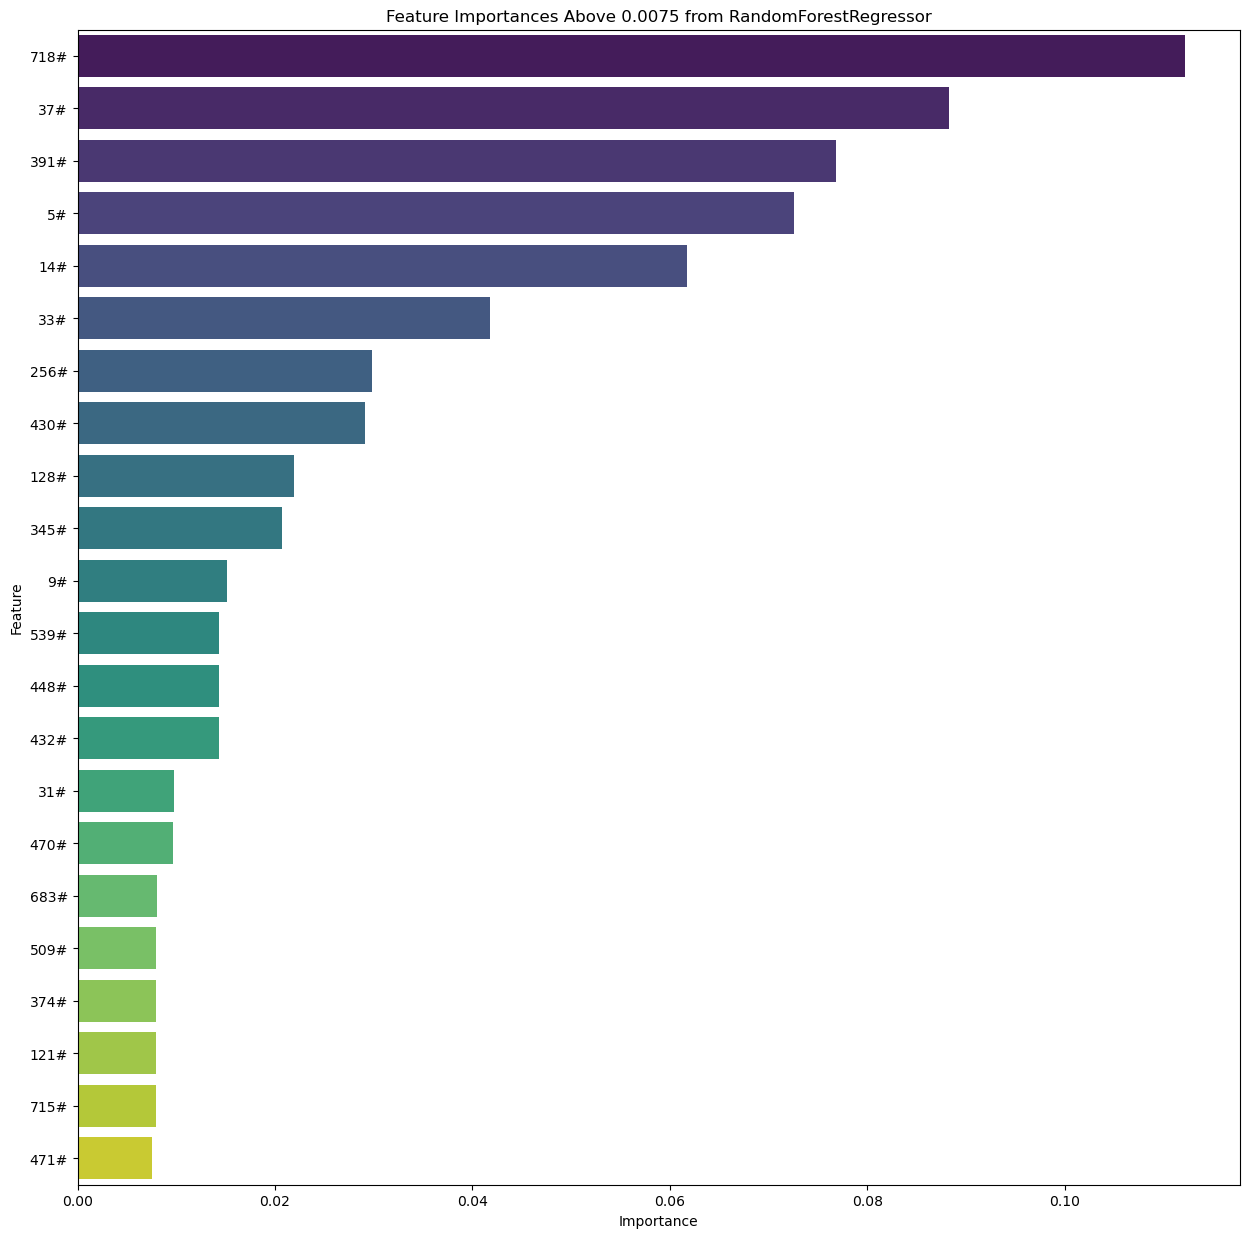

In [117]:
target = "EGT"

# Create the target vector and feature matrix
y = normalized_data_smote[target]
X = normalized_data_smote.drop(columns=[target])

# Initialize and train the RandomForestRegressor with a random seed
random_seed = 42 
model = RandomForestRegressor(random_state=random_seed)
model.fit(X, y)

# Get feature importances
importance = model.feature_importances_

# Create a DataFrame to hold feature names and their importances
features_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Filter features with importance above the threshold
threshold = 0.0075
Random_Forest_feature_importance_normalized_data_smote = features_importance_df[features_importance_df['Importance'] > threshold]

# Sort the DataFrame by importance
Random_Forest_feature_importance_normalized_data_smote = Random_Forest_feature_importance_normalized_data_smote.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='Importance', y='Feature', data=Random_Forest_feature_importance_normalized_data_smote, palette='viridis')
plt.title(f'Feature Importances Above {threshold} from RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [118]:
len(Random_Forest_feature_importance_normalized_data_smote)

22

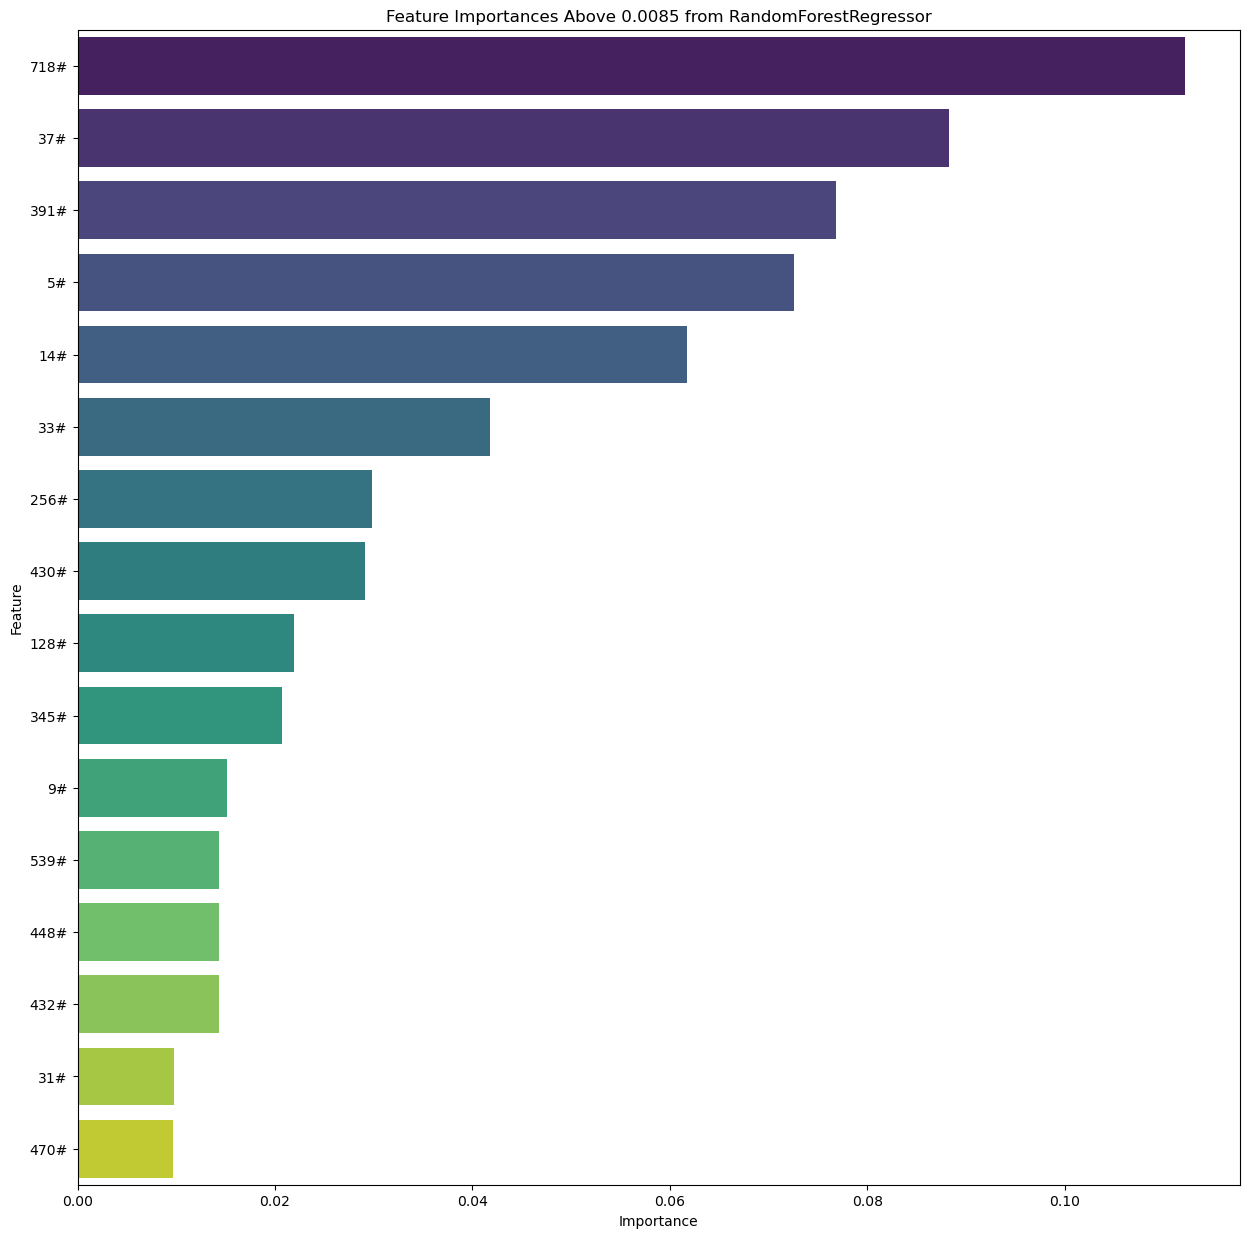

In [119]:
target = "EGT"

# Create the target vector and feature matrix
y = normalized_data_smote[target]
X = normalized_data_smote.drop(columns=[target])

# Initialize and train the RandomForestRegressor with a random seed
random_seed = 42 
model = RandomForestRegressor(random_state=random_seed)
model.fit(X, y)

# Get feature importances
importance = model.feature_importances_

# Create a DataFrame to hold feature names and their importances
features_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Filter features with importance above the threshold
threshold = 0.0085
Random_Forest_feature_importance_normalized_data_smote = features_importance_df[features_importance_df['Importance'] > threshold]

# Sort the DataFrame by importance
Random_Forest_feature_importance_normalized_data_smote = Random_Forest_feature_importance_normalized_data_smote.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='Importance', y='Feature', data=Random_Forest_feature_importance_normalized_data_smote, palette='viridis')
plt.title(f'Feature Importances Above {threshold} from RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [120]:
len(Random_Forest_feature_importance_normalized_data_smote)

16

In [121]:
Random_Forest_feature_importance_normalized_data_smote.set_index('Feature', inplace=True)
important_features = Random_Forest_feature_importance_normalized_data_smote.index

Random_Forest_feature_importance_normalized_data_smote = normalized_data_smote[important_features]
Random_Forest_feature_importance_normalized_data_smote["EGT"]=normalized_data_smote["EGT"]

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\66481443.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Random_Forest_feature_importance_normalized_data_smote["EGT"]=normalized_data_smote["EGT"]


In [122]:
target = "EGT"

y =Random_Forest_feature_importance_normalized_data_smote[target]
X = Random_Forest_feature_importance_normalized_data_smote.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.233258 -0.306065  0.375000
1               SVM  0.189042  0.363465  0.333333
2  Ridge Regression  0.161288  0.570057  0.291667
3  Lasso Regression  0.303381 -0.580334  0.041667
4             CLTSM  0.260524 -0.192848  0.083333

Doesn't improve the metrics

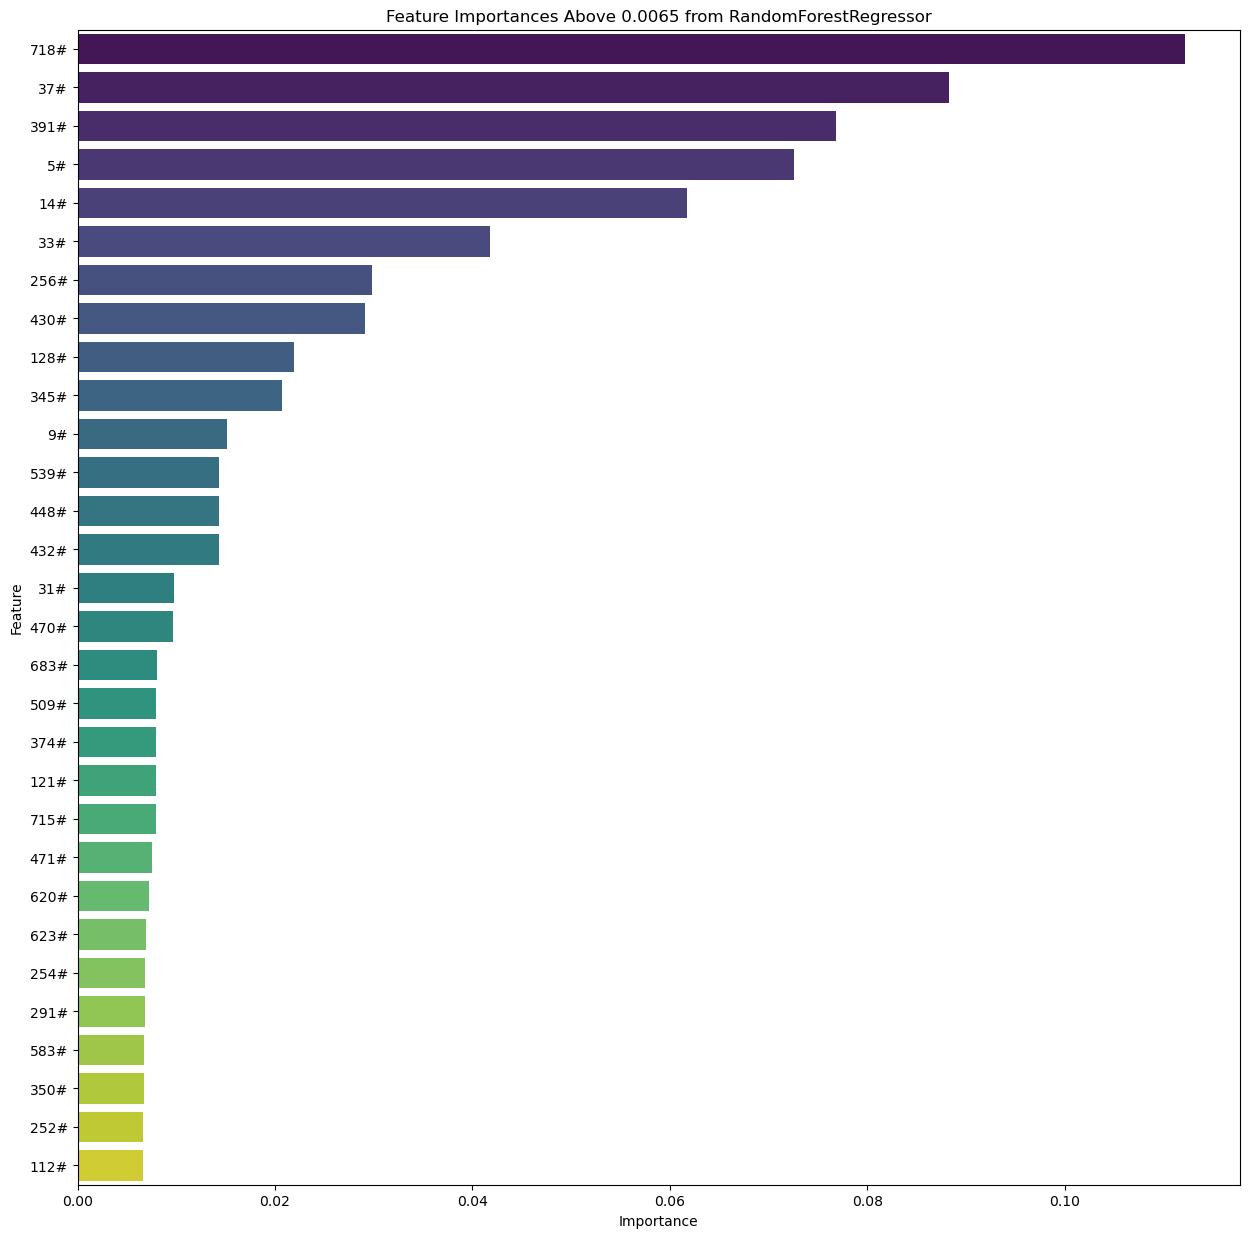

In [123]:
target = "EGT"

# Create the target vector and feature matrix
y = normalized_data_smote[target]
X = normalized_data_smote.drop(columns=[target])

# Initialize and train the RandomForestRegressor with a random seed
random_seed = 42 
model = RandomForestRegressor(random_state=random_seed)
model.fit(X, y)

# Get feature importances
importance = model.feature_importances_

# Create a DataFrame to hold feature names and their importances
features_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Filter features with importance above the threshold
threshold = 0.0065
Random_Forest_feature_importance_normalized_data_smote = features_importance_df[features_importance_df['Importance'] > threshold]

# Sort the DataFrame by importance
Random_Forest_feature_importance_normalized_data_smote = Random_Forest_feature_importance_normalized_data_smote.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='Importance', y='Feature', data=Random_Forest_feature_importance_normalized_data_smote, palette='viridis')
plt.title(f'Feature Importances Above {threshold} from RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [124]:
len(Random_Forest_feature_importance_normalized_data_smote)

30

In [125]:
Random_Forest_feature_importance_normalized_data_smote.set_index('Feature', inplace=True)
important_features = Random_Forest_feature_importance_normalized_data_smote.index

Random_Forest_feature_importance_normalized_data_smote = normalized_data_smote[important_features]
Random_Forest_feature_importance_normalized_data_smote["EGT"]=normalized_data_smote["EGT"]

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\66481443.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Random_Forest_feature_importance_normalized_data_smote["EGT"]=normalized_data_smote["EGT"]


In [126]:
target = "EGT"

y =Random_Forest_feature_importance_normalized_data_smote[target]
X = Random_Forest_feature_importance_normalized_data_smote.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.229352 -0.239557  0.416667
1               SVM  0.194377  0.311781  0.208333
2  Ridge Regression  0.144676  0.629592  0.458333
3  Lasso Regression  0.303381 -0.580334  0.041667
4             CLTSM  0.304372 -0.610806  0.166667

Since it greatly improves the indices and the number of features is still relatively low, we will try to further lower the threshold value

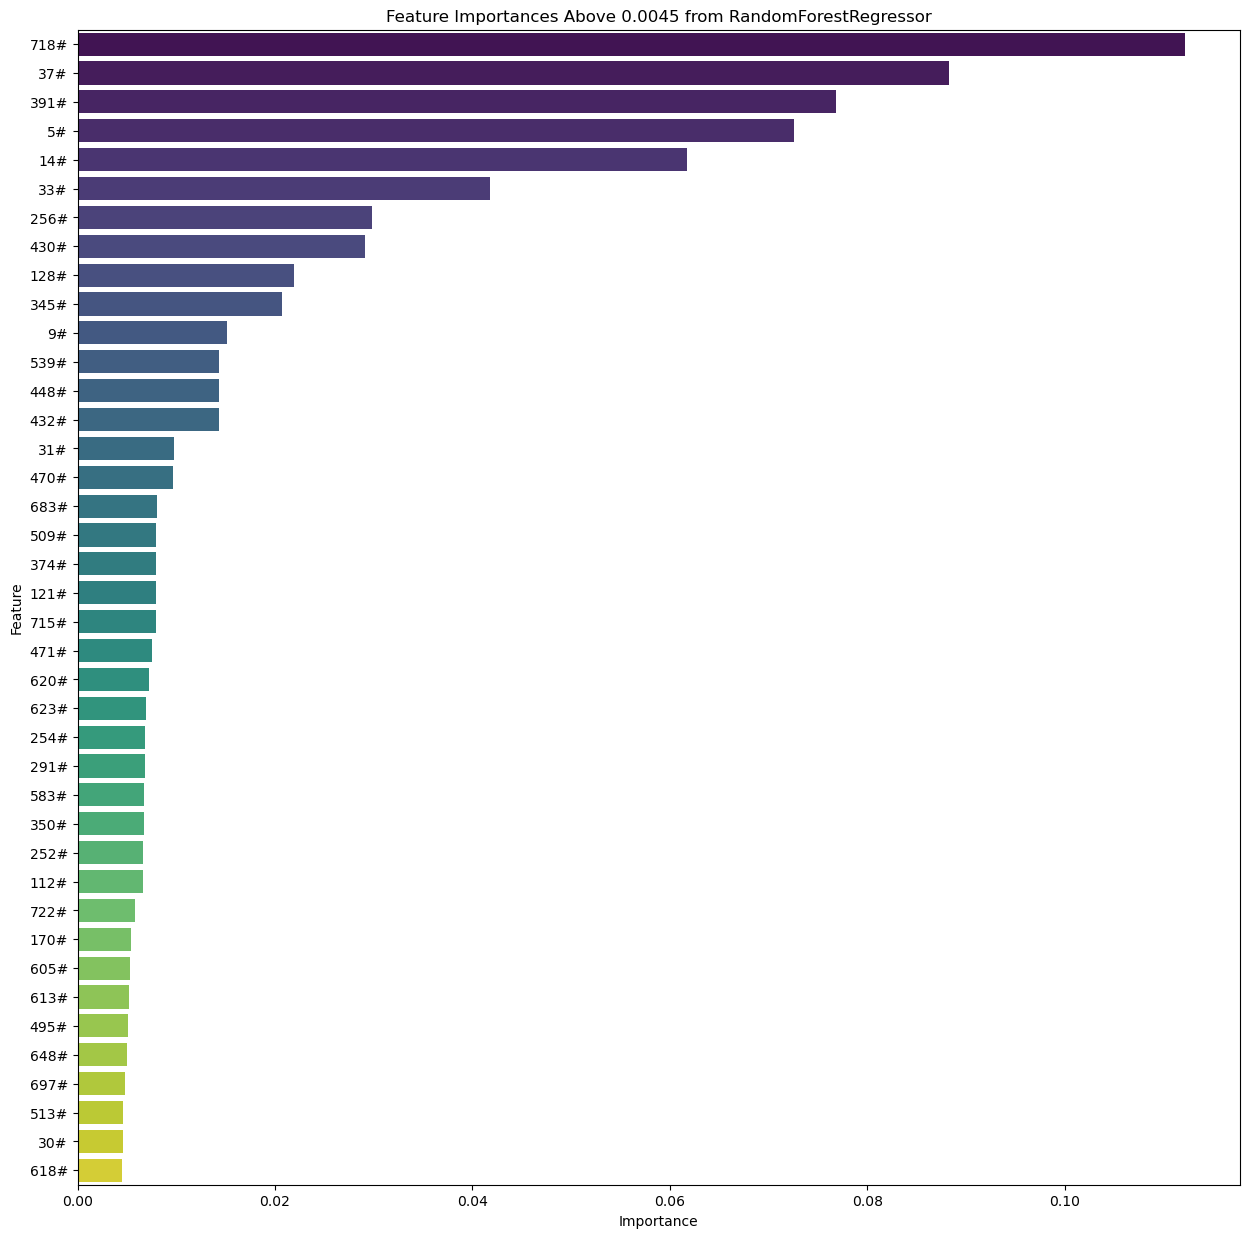

In [127]:
target = "EGT"

# Create the target vector and feature matrix
y = normalized_data_smote[target]
X = normalized_data_smote.drop(columns=[target])

# Initialize and train the RandomForestRegressor with a random seed
random_seed = 42 
model = RandomForestRegressor(random_state=random_seed)
model.fit(X, y)

# Get feature importances
importance = model.feature_importances_

# Create a DataFrame to hold feature names and their importances
features_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Filter features with importance above the threshold
threshold = 0.0045
Random_Forest_feature_importance_normalized_data_smote = features_importance_df[features_importance_df['Importance'] > threshold]

# Sort the DataFrame by importance
Random_Forest_feature_importance_normalized_data_smote = Random_Forest_feature_importance_normalized_data_smote.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='Importance', y='Feature', data=Random_Forest_feature_importance_normalized_data_smote, palette='viridis')
plt.title(f'Feature Importances Above {threshold} from RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [128]:
len(Random_Forest_feature_importance_normalized_data_smote)

40

In [129]:
Random_Forest_feature_importance_normalized_data_smote.set_index('Feature', inplace=True)
important_features = Random_Forest_feature_importance_normalized_data_smote.index

Random_Forest_feature_importance_normalized_data_smote = normalized_data_smote[important_features]
Random_Forest_feature_importance_normalized_data_smote["EGT"]=normalized_data_smote["EGT"]

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\66481443.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Random_Forest_feature_importance_normalized_data_smote["EGT"]=normalized_data_smote["EGT"]


In [130]:
target = "EGT"

y =Random_Forest_feature_importance_normalized_data_smote[target]
X = Random_Forest_feature_importance_normalized_data_smote.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.229557 -0.240496  0.333333
1               SVM  0.198864  0.295429  0.291667
2  Ridge Regression  0.157101  0.561200  0.458333
3  Lasso Regression  0.303381 -0.580334  0.041667
4             CLTSM  0.319160 -0.744685  0.041667

Raises the indicators a little, so we will not use this improvement

#### SelectKBest f regression normalized data smote 

In [131]:
# Assuming standardized_data is already defined
target = "EGT"

y = normalized_data_smote[target]
X = normalized_data_smote.drop(columns=[target])

random_seed = 46
k_best = SelectKBest(score_func=f_regression, k='all')
model = k_best  # Use the instance of SelectKBest directly
model.fit(X, y)

# Get mutual information scores
f_scores = k_best.scores_

# Create a DataFrame to display f_regression scores
f_df = pd.DataFrame({'Feature': X.columns, 'F Score': f_scores})

# Filter features with f_regression score above the threshold
threshold = 8
filtered_f_df = f_df[f_df['F Score'] > threshold]

# Sort the DataFrame by f_regression score
filtered_f_df = filtered_f_df.sort_values(by='F Score', ascending=False)

print(len(filtered_f_df))

35


C:\Users\liron firuz\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms


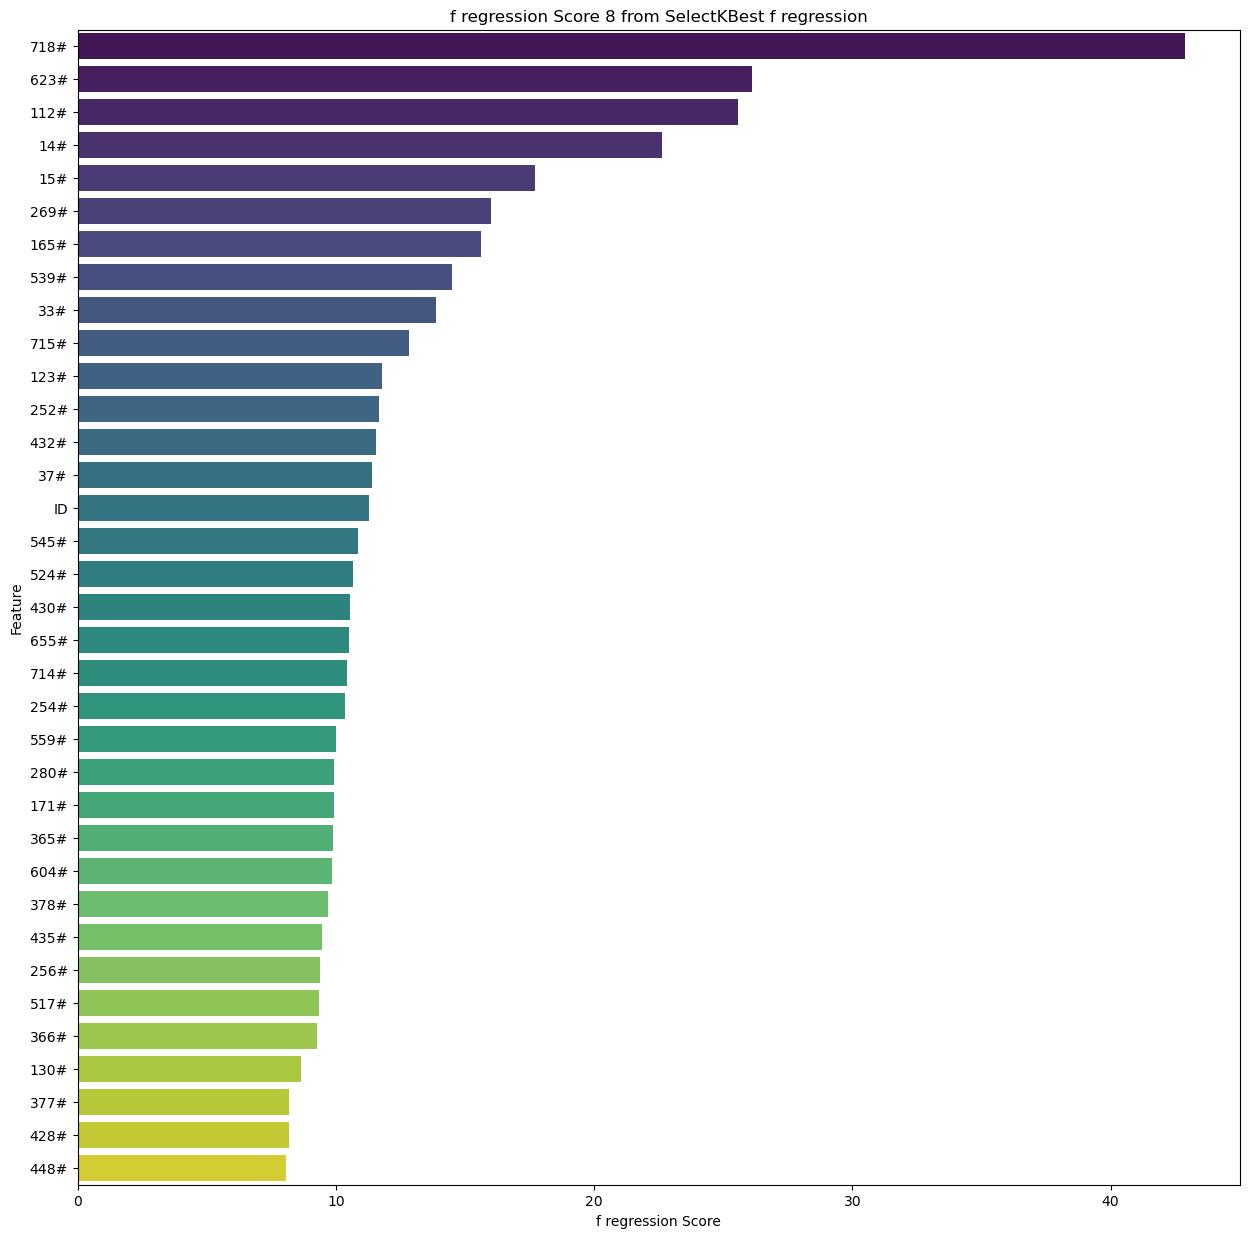

In [132]:
# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='F Score', y='Feature', data=filtered_f_df, palette='viridis')
plt.title(f'f regression Score {threshold} from SelectKBest f regression')
plt.xlabel('f regression Score')
plt.ylabel('Feature')
plt.show()

In [133]:
filtered_f_df.set_index('Feature', inplace=True)
important_features = filtered_f_df.index

SelectKBest_f_regression_normalized_data_smote_filtered = normalized_data_smote[important_features]
SelectKBest_f_regression_normalized_data_smote_filtered["EGT"]=normalized_data_smote["EGT"]

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\320388466.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SelectKBest_f_regression_normalized_data_smote_filtered["EGT"]=normalized_data_smote["EGT"]


718#      623#  112#       14#       15#      269#      165#  \
0   0.000000  0.000000   1.0  1.000000  1.000000  1.000000  0.128571   
1   1.000000  0.392863   1.0  0.000000  0.000000  0.629630  0.328571   
2   1.000000  1.000000   0.0  0.142857  0.142857  0.185185  1.000000   
3   1.000000  0.392863   1.0  0.285714  0.428571  0.259259  0.800000   
4   0.500000  0.392857   1.0  0.428571  0.571429  0.814815  0.542857   
5   0.000000  0.000000   1.0  0.571429  0.571429  1.000000  0.014286   
6   1.000000  0.392863   1.0  0.285714  0.142857  0.000000  0.385714   
7   1.000000  0.392863   1.0  0.285714  0.142857  0.629630  0.314286   
8   0.500000  0.392863   1.0  0.714286  0.714286  1.000000  0.471429   
9   0.000000  0.000000   1.0  0.285714  0.285714  1.000000  0.000000   
10  1.000000  0.392863   0.0  0.142857  0.000000  0.259259  0.371429   
11  1.000000  0.392863   1.0  0.285714  0.428571  1.000000  0.557143   
12  0.166854  0.131102   1.0  0.428732  0.428732  1.000000  0.157320   
13  1.000000  0.392863   1.0  0.285714  0.142857  0.539676  0.324490   
14  0.349112  0.137153   1.0  0.285714  0.335587  0.741399  0.279289   
15  1.000000  0.427112   0.0  0.142857  0.008059  0.255081  0.406887   
16  1.000000  0.561647   0.0  0.246000  0.349143  0.773480  0.680258   
17  1.000000  0.392863   1.0  0.017556  0.008778  0.590941  0.332083   
18  0.000389  0.000306   1.0  0.286048  0.286048  1.000000  0.000367   
19  0.996106  0.995271   0.0  0.145082  0.146195  0.190089  0.996440   
20  1.000000  0.767759   0.0  0.197503  0.142857  0.114348  0.765024   
21  0.694173  0.392863   1.0  0.547851  0.603329  0.712336  0.599028   
22  0.996467  0.392863   1.0  0.288743  0.430590  0.264494  0.797678   
23  1.000000  0.392863   1.0  0.285714  0.142857  0.014521  0.384067   

        539#       33#      715#  ...      378#      435#      256#      517#  \
0   0.250000  0.373796  1.000000  ...  0.400000  1.000000  0.142857  0.890909   
1   0.750000  0.658960  0.000000  ...  0.200000  0.423077  1.000000  0.890909   
2   0.250000  0.396917  0.000000  ...  0.400000  0.615385  0.714286  0.909091   
3   0.750000  0.741811  0.000000  ...  0.200000  0.743590  0.571429  0.909091   
4   0.500000  0.123314  0.000000  ...  0.200000  0.358974  0.000000  0.909091   
5   0.500000  0.104046  0.000000  ...  0.400000  0.102564  0.428571  0.000000   
6   0.500000  0.312139  0.000000  ...  0.400000  0.358974  0.285714  1.000000   
7   0.750000  0.000000  0.000000  ...  0.600000  0.423077  0.571429  0.818182   
8   0.250000  0.678227  0.000000  ...  0.000000  0.615385  0.142857  0.890909   
9   0.000000  0.048170  1.000000  ...  0.200000  0.000000  0.285714  0.636364   
10  1.000000  1.000000  0.000000  ...  1.000000  0.871795  0.428571  1.000000   
11  0.750000  0.610790  0.000000  ...  0.200000  0.602564  0.142857  0.909091   
12  0.083427  0.258425  0.666291  ...  0.133258  0.205359  0.238042  0.721308   
13  0.714283  0.044594  0.000000  ...  0.571427  0.413919  0.530609  0.844158   
14  0.261834  0.290328  0.650888  ...  0.200000  0.259596  0.385460  0.731576   
15  0.957691  0.965979  0.000000  ...  0.966153  0.857330  0.444689  0.994872   
16  0.610999  0.551333  0.000000  ...  0.255600  0.606128  0.301715  0.909091   
17  0.734638  0.637648  0.000000  ...  0.212289  0.419138  0.956109  0.897612   
18  0.000195  0.048660  0.999221  ...  0.199844  0.000479  0.285603  0.636562   
19  0.251947  0.394786  0.000000  ...  0.398442  0.613388  0.708723  0.909091   
20  0.345630  0.364488  0.000000  ...  0.400000  0.517303  0.550349  0.943865   
21  0.444173  0.702920  0.000000  ...  0.077669  0.665173  0.309292  0.897970   
22  0.746467  0.741362  0.000000  ...  0.198587  0.742684  0.568400  0.908962   
23  0.505766  0.304940  0.000000  ...  0.404612  0.360453  0.292304  0.995807   

    366#      130#      377#      428#      448#   EGT  
0   0.50  0.000000  0.000000  0.500000  0.000000  0.00  
1   1.00  1.000000  0.166667  0.250000  0.823529  0.64  
2   1.00  

In [134]:
# Assuming standardized_data is already defined
target = "EGT"

y = normalized_data_smote[target]
X = normalized_data_smote.drop(columns=[target])

random_seed = 46
k_best = SelectKBest(score_func=f_regression, k='all')
model = k_best  # Use the instance of SelectKBest directly
model.fit(X, y)

# Get mutual information scores
f_scores = k_best.scores_

# Create a DataFrame to display f_regression scores
f_df = pd.DataFrame({'Feature': X.columns, 'F Score': f_scores})

# Filter features with f_regression score above the threshold
threshold = 9
filtered_f_df = f_df[f_df['F Score'] > threshold]

# Sort the DataFrame by f_regression score
filtered_f_df = filtered_f_df.sort_values(by='F Score', ascending=False)

print(len(filtered_f_df))

31


C:\Users\liron firuz\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms


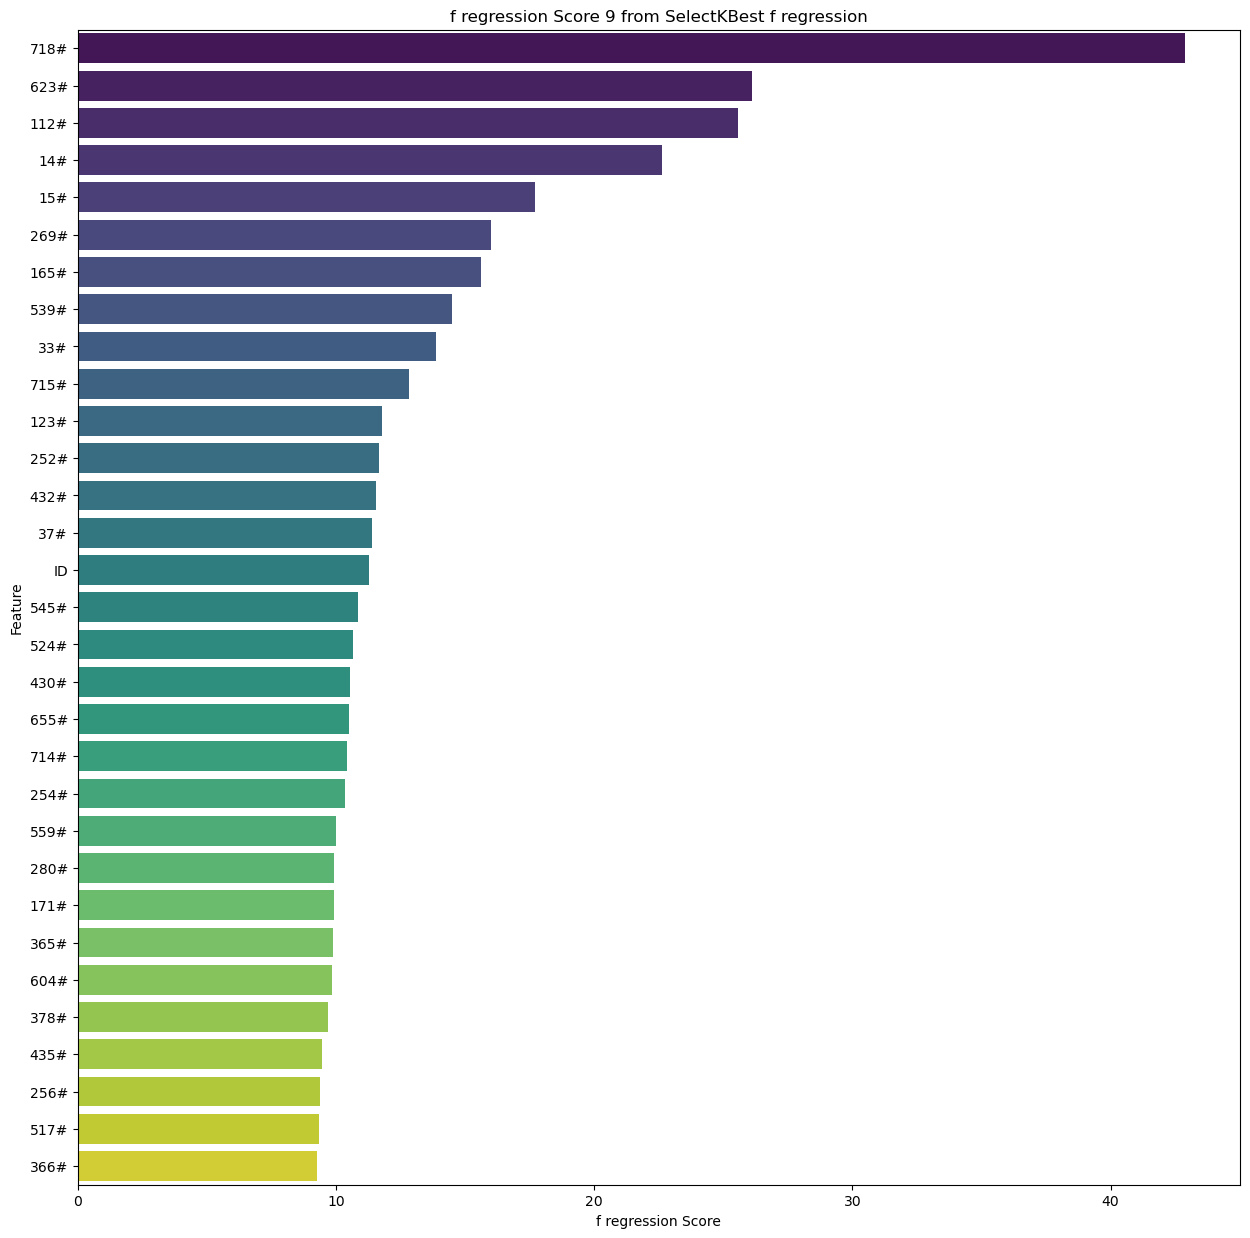

In [135]:
# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='F Score', y='Feature', data=filtered_f_df, palette='viridis')
plt.title(f'f regression Score {threshold} from SelectKBest f regression')
plt.xlabel('f regression Score')
plt.ylabel('Feature')
plt.show()

In [136]:
filtered_f_df.set_index('Feature', inplace=True)
important_features = filtered_f_df.index

SelectKBest_f_regression_normalized_data_smote_filtered = normalized_data_smote[important_features]
SelectKBest_f_regression_normalized_data_smote_filtered["EGT"]=normalized_data_smote["EGT"]

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\2194642081.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SelectKBest_f_regression_normalized_data_smote_filtered["EGT"]=normalized_data_smote["EGT"]


In [137]:
target = "EGT"

y =SelectKBest_f_regression_normalized_data_smote_filtered[target]
X = SelectKBest_f_regression_normalized_data_smote_filtered.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.181353  0.434802  0.375000
1               SVM  0.191340  0.368581  0.250000
2  Ridge Regression  0.151592  0.623352  0.291667
3  Lasso Regression  0.303381 -0.580334  0.041667
4             CLTSM  0.223876  0.098913  0.125000

Slightly raises the indices so we will not use this improvement

In [138]:
# Assuming standardized_data is already defined
target = "EGT"

y = normalized_data_smote[target]
X = normalized_data_smote.drop(columns=[target])

random_seed = 46
k_best = SelectKBest(score_func=f_regression, k='all')
model = k_best  # Use the instance of SelectKBest directly
model.fit(X, y)

# Get mutual information scores
f_scores = k_best.scores_

# Create a DataFrame to display f_regression scores
f_df = pd.DataFrame({'Feature': X.columns, 'F Score': f_scores})

# Filter features with f_regression score above the threshold
threshold = 7
filtered_f_df = f_df[f_df['F Score'] > threshold]

# Sort the DataFrame by f_regression score
filtered_f_df = filtered_f_df.sort_values(by='F Score', ascending=False)

print(len(filtered_f_df))

44


C:\Users\liron firuz\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms


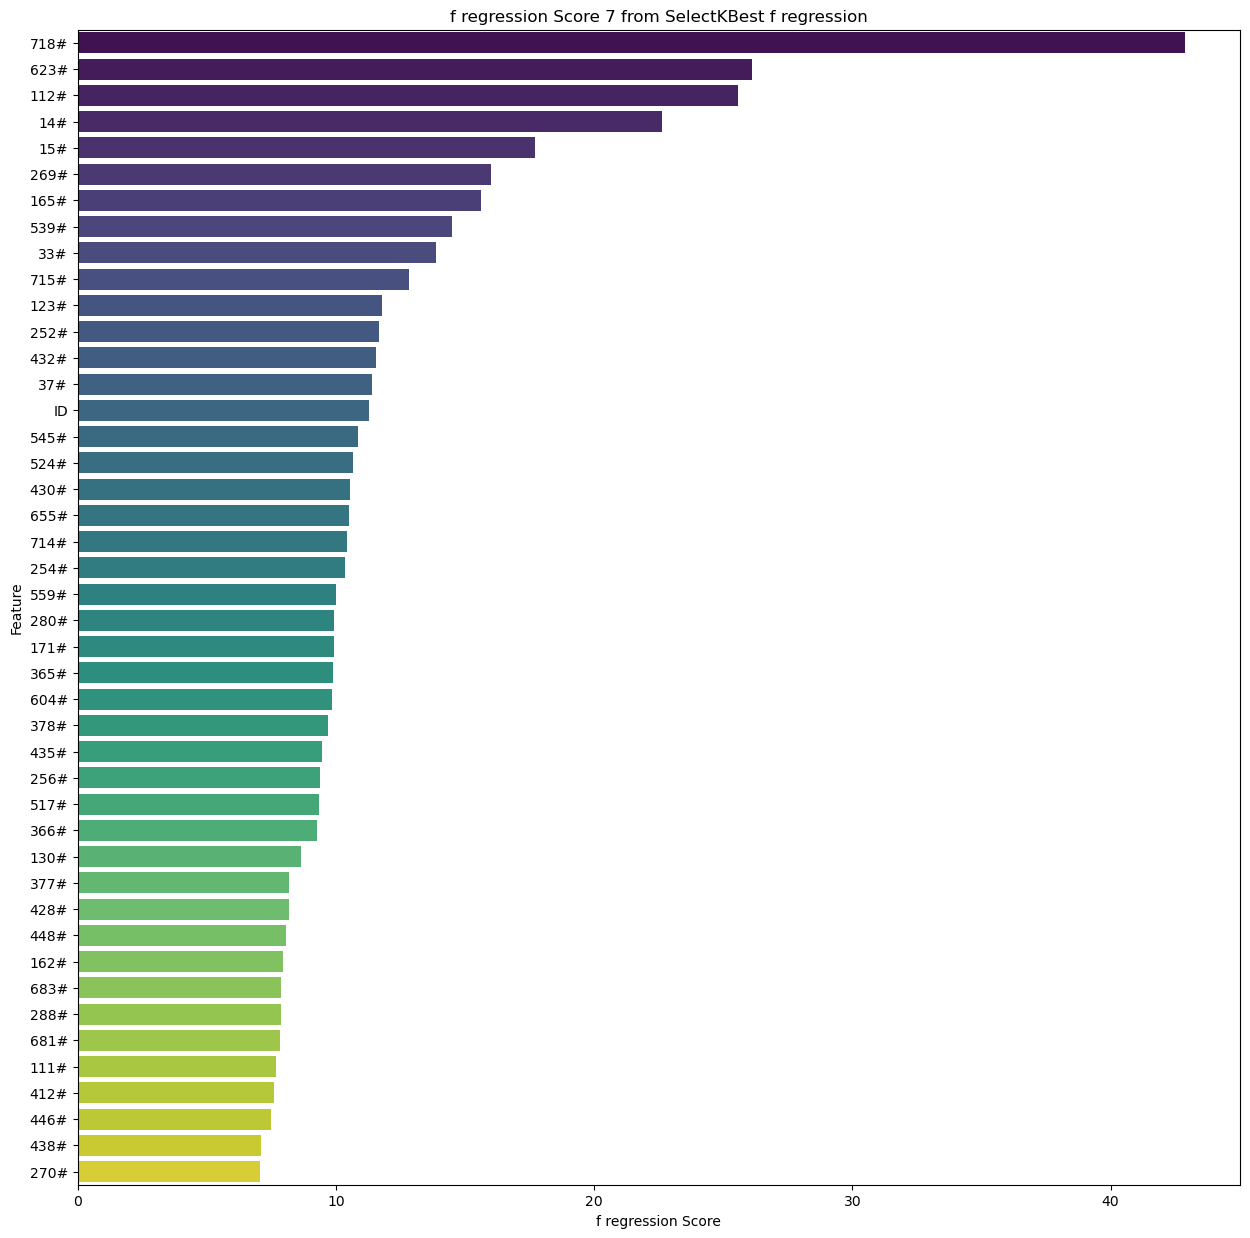

In [139]:
# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='F Score', y='Feature', data=filtered_f_df, palette='viridis')
plt.title(f'f regression Score {threshold} from SelectKBest f regression')
plt.xlabel('f regression Score')
plt.ylabel('Feature')
plt.show()

In [140]:
filtered_f_df.set_index('Feature', inplace=True)
important_features = filtered_f_df.index

SelectKBest_f_regression_normalized_data_smote_filtered = normalized_data_smote[important_features]
SelectKBest_f_regression_normalized_data_smote_filtered["EGT"]=normalized_data_smote["EGT"]

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\2194642081.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SelectKBest_f_regression_normalized_data_smote_filtered["EGT"]=normalized_data_smote["EGT"]


In [141]:
target = "EGT"

y =SelectKBest_f_regression_normalized_data_smote_filtered[target]
X = SelectKBest_f_regression_normalized_data_smote_filtered.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.180440  0.439470  0.375000
1               SVM  0.194854  0.339938  0.208333
2  Ridge Regression  0.129222  0.714708  0.250000
3  Lasso Regression  0.303381 -0.580334  0.041667
4             CLTSM  0.213151  0.218038  0.250000

In [142]:
# Assuming standardized_data is already defined
target = "EGT"

y = normalized_data_smote[target]
X = normalized_data_smote.drop(columns=[target])

random_seed = 46
k_best = SelectKBest(score_func=f_regression, k='all')
model = k_best  # Use the instance of SelectKBest directly
model.fit(X, y)

# Get mutual information scores
f_scores = k_best.scores_

# Create a DataFrame to display f_regression scores
f_df = pd.DataFrame({'Feature': X.columns, 'F Score': f_scores})

# Filter features with f_regression score above the threshold
threshold = 6
filtered_f_df = f_df[f_df['F Score'] > threshold]

# Sort the DataFrame by f_regression score
filtered_f_df = filtered_f_df.sort_values(by='F Score', ascending=False)

print(len(filtered_f_df))

59


C:\Users\liron firuz\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms


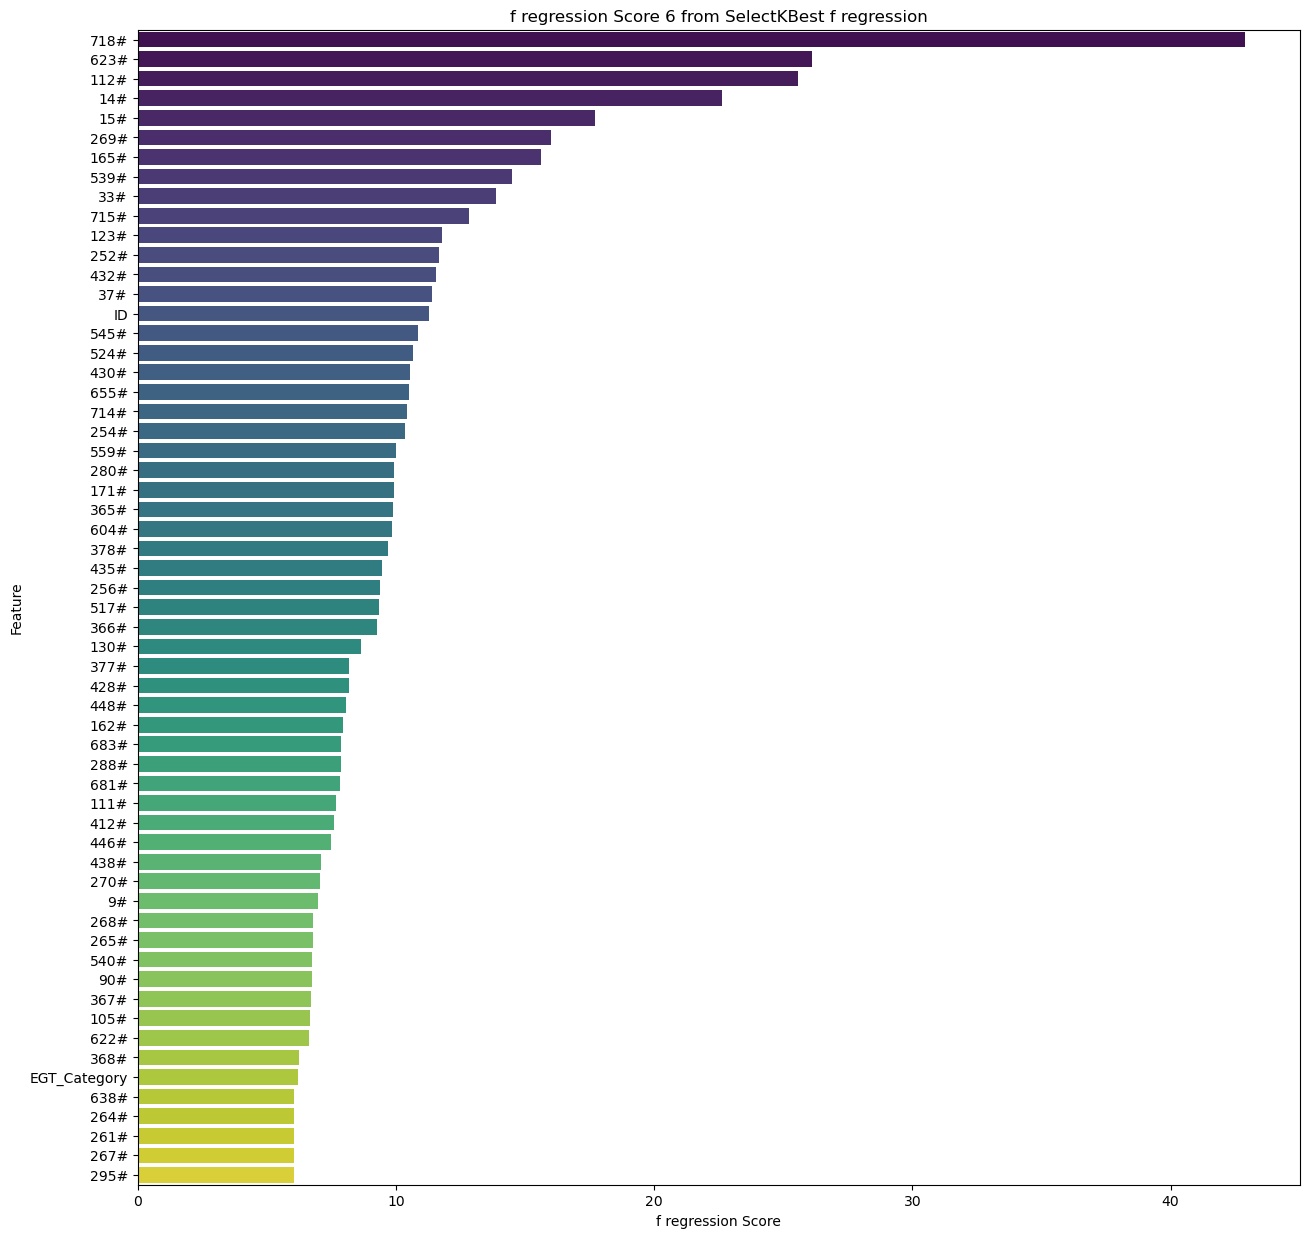

In [143]:
# Plotting
plt.figure(figsize=(15, 15))
sns.barplot(x='F Score', y='Feature', data=filtered_f_df, palette='viridis')
plt.title(f'f regression Score {threshold} from SelectKBest f regression')
plt.xlabel('f regression Score')
plt.ylabel('Feature')
plt.show()

In [144]:
filtered_f_df.set_index('Feature', inplace=True)
important_features = filtered_f_df.index

SelectKBest_f_regression_normalized_data_smote_filtered = normalized_data_smote[important_features]
SelectKBest_f_regression_normalized_data_smote_filtered["EGT"]=normalized_data_smote["EGT"]

C:\Users\liron firuz\AppData\Local\Temp\ipykernel_24760\2194642081.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SelectKBest_f_regression_normalized_data_smote_filtered["EGT"]=normalized_data_smote["EGT"]


In [145]:
target = "EGT"

y =SelectKBest_f_regression_normalized_data_smote_filtered[target]
X = SelectKBest_f_regression_normalized_data_smote_filtered.drop(columns=[target])

kf = KFold(n_splits=3, shuffle=True, random_state=51)

xgb_results = []
svm_results = []
ridge_results = []
lasso_results = []
cltsm_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_metrics, svm_metrics, ridge_metrics, lasso_metrics, cltsm_metrics = train_and_evaluate(X_train, y_train, X_test, y_test)

    xgb_results.append(xgb_metrics)
    svm_results.append(svm_metrics)
    ridge_results.append(ridge_metrics)
    lasso_results.append(lasso_metrics)
    cltsm_results.append(cltsm_metrics)

# Calculate mean metrics
mean_xgb_metrics = np.mean(xgb_results, axis=0)
mean_svm_metrics = np.mean(svm_results, axis=0)
mean_ridge_metrics = np.mean(ridge_results, axis=0)
mean_lasso_metrics = np.mean(lasso_results, axis=0)
mean_cltsm_metrics = np.mean(cltsm_results, axis=0)

# Compile the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Ridge Regression', 'Lasso Regression', 'CLTSM'],
    'RMSE': [mean_xgb_metrics[0], mean_svm_metrics[0], mean_ridge_metrics[0], mean_lasso_metrics[0], mean_cltsm_metrics[0]],
    'R^2': [mean_xgb_metrics[1], mean_svm_metrics[1], mean_ridge_metrics[1], mean_lasso_metrics[1], mean_cltsm_metrics[1]],
    'Accuracy': [mean_xgb_metrics[2], mean_svm_metrics[2], mean_ridge_metrics[2], mean_lasso_metrics[2], mean_cltsm_metrics[2]]
})

# Display the metrics dataframe
metrics_df

C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


C:\Users\liron firuz\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Model      RMSE       R^2  Accuracy
0           XGBoost  0.180462  0.439289  0.375000
1               SVM  0.195282  0.344763  0.166667
2  Ridge Regression  0.130989  0.708006  0.375000
3  Lasso Regression  0.303381 -0.580334  0.041667
4             CLTSM  0.274547 -0.275810  0.125000

select k best f regression feature selection model when there are 44 features is the best